# Toy Distributions for L2HMC

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import setup_directories, train_dynamics
from dynamics.base_dynamics import BaseDynamics
from dynamics.generic_dynamics import GenericDynamics
from network.generic_network import GenericNetwork
from config import (State, NetWeights, MonteCarloStates,
                    DynamicsConfig, NetworkConfig, lrConfig,
                    BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

sns.set_palette('bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2020-08-12 10:33:47,470:INFO:Number of devices: 1



### Plot examples of (toy) target distributions:

<IPython.core.display.Javascript object>


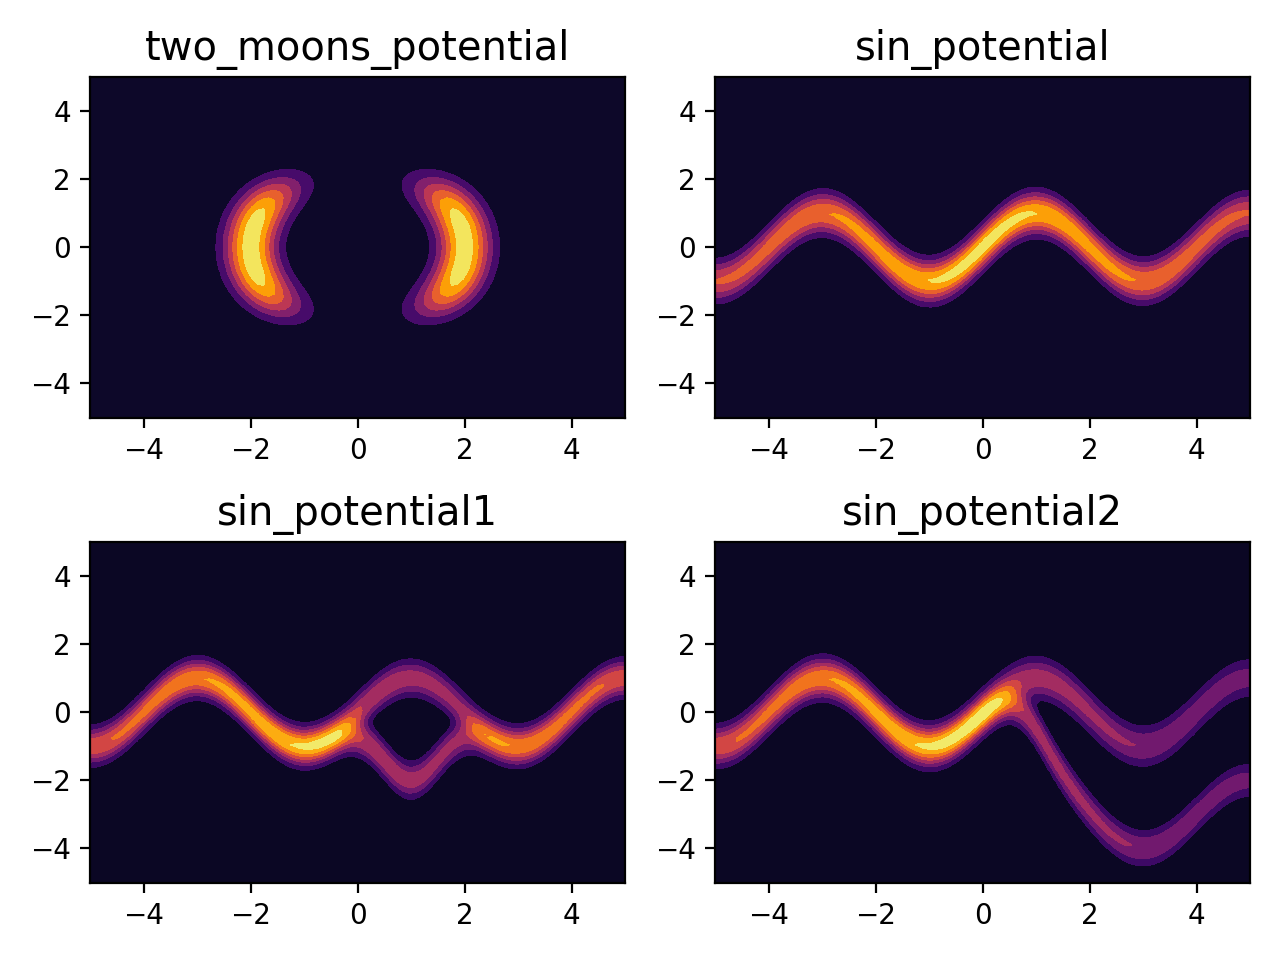

In [2]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons_potential', 'sin_potential', 'sin_potential1', 'sin_potential2']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}')
plt.show()

## Define parameters of the model and target distribution:

In [4]:
import datetime

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE='sin_potential'
POTENTIAL_FN = sin_potential

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')
log_dir = os.path.join(BASE_DIR, MODEL_TYPE, date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)


flags = AttrDict({
    'restore': False,
    'horovod': False,
    'profiler': False,
    'xdim': 2,
    'eps': 0.2,
    'batch_size': 256,
    'num_steps': 10,
    'beta_init': 0.5,
    'beta_final': 1.,
    'compile': True,
    'hmc_steps': 1000,
    'lr_init': 1e-3,
    'train_steps': 10000,
    'clip_value': 0.,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 50,
    'warmup_steps': 500,
    'print_steps': 10,
    'units': [100, 100],
    'hmc': False,
    'eps_trainable': True,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.25,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

## Train:

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [5]:
x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = lrConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
    hmc_flags = AttrDict(dict(flags))
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 1000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_trainable=flags.eps_trainable,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    flags.eps = hmc_dynamics.eps.numpy()

2020-08-12 10:34:11,311:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408

2020-08-12 10:34:11,312:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training_hmc

2020-08-12 10:34:11,313:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training_hmc/train_data

2020-08-12 10:34:11,313:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training_hmc/checkpoints

2020-08-12 10:34:11,314:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training_hmc/summaries

2020-08-12 10:34:11,315:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training_hmc/dynamics_configs

2020-08-12 10:34:11,316:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training_hmc/FLAGS.z.

2020-08-12 10:34:21,742:INFO:Compi

training:   0%|          | 3/1001 [00:00<00:33, 29.39step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/1000    0.01697      0.7709      0.981        0.2         0.5          0      


training:   2%|▏         | 18/1001 [00:00<00:23, 41.87step/s]

    10/1000    0.01221     -0.2557      0.9823       0.2         0.5          0      
    20/1000    0.01087       10.9       0.9825       0.2         0.5          0      


training:   5%|▍         | 47/1001 [00:00<00:14, 64.68step/s]

    30/1000    0.009775     1.161       0.9843      0.2001       0.5          0      
    40/1000    0.009383     7.998       0.9798      0.2003       0.5          0      


training:   6%|▋         | 65/1001 [00:00<00:12, 73.29step/s]

    50/1000    0.009432    -0.4958      0.9841      0.2005       0.5          0      
    60/1000     0.0112      8.029       0.9789      0.2003       0.5          0      


training:   8%|▊         | 85/1001 [00:01<00:11, 82.94step/s]

    70/1000    0.008811    -0.6835      0.9822      0.2006       0.5          0      
    80/1000    0.008956    -0.6873      0.9849      0.201        0.5          0      


training:  11%|█         | 106/1001 [00:01<00:10, 87.92step/s]

    90/1000    0.008467     14.37       0.9783      0.2009       0.5          0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   100/1000    0.008609     33.55       0.984       0.2001       0.5          0      


training:  13%|█▎        | 128/1001 [00:01<00:09, 95.40step/s]

   110/1000    0.009216     3.542       0.9856      0.2001       0.5          0      
   120/1000    0.008307      2.48       0.9784      0.2006       0.5          0      
   130/1000    0.008793     2.535       0.986       0.201        0.5          0      


training:  15%|█▍        | 150/1001 [00:01<00:08, 100.40step/s]

   140/1000    0.009747     2.749       0.9789      0.2014       0.5          0      
   150/1000    0.008763      29.6       0.9868      0.2009       0.5          0      
   160/1000    0.008489     18.28       0.9814      0.1997       0.5          0      


training:  18%|█▊        | 182/1001 [00:02<00:08, 99.53step/s] 

   170/1000    0.009511     -1.566      0.9807      0.1983       0.5          0      
   180/1000    0.008014     12.71       0.9795      0.1972       0.5          0      
   190/1000    0.008654     42.61       0.9845      0.1962       0.5          0      


training:  21%|██▏       | 215/1001 [00:02<00:08, 96.50step/s] 

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   200/1000    0.01044      3.802       0.9807      0.1945       0.5          0      
   210/1000    0.008719    0.02689      0.9867      0.1935       0.5          0      


training:  24%|██▎       | 237/1001 [00:02<00:08, 92.58step/s]

   220/1000    0.008629     3.448       0.9828      0.1932       0.5          0      
   230/1000     0.0148      0.7017      0.984       0.193        0.5          0      


training:  26%|██▌       | 257/1001 [00:02<00:08, 91.12step/s]

   240/1000    0.009601    -0.08234     0.9857      0.1928       0.5          0      
   250/1000    0.008483     -1.557      0.979       0.1925       0.5          0      


training:  28%|██▊       | 277/1001 [00:03<00:08, 88.46step/s]

   260/1000    0.009201     12.28       0.9836      0.1917       0.5          0      
   270/1000    0.01007      8.945       0.986       0.1901       0.5          0      


training:  30%|██▉       | 297/1001 [00:03<00:07, 90.33step/s]

   280/1000    0.008963    -0.9803      0.9865      0.1898       0.5          0      
   290/1000    0.01031      -1.002      0.9869      0.1897       0.5          0      


training:  32%|███▏      | 318/1001 [00:03<00:07, 92.25step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   300/1000    0.01066      0.5771      0.9814      0.1901       0.5          0      
   310/1000    0.009023     0.2355      0.9852      0.1895       0.5          0      


training:  34%|███▍      | 339/1001 [00:03<00:06, 96.86step/s]

   320/1000    0.008765     1.142       0.9838      0.1902       0.5          0      
   330/1000    0.008518     0.6343      0.9818      0.1906       0.5          0      


training:  36%|███▌      | 358/1001 [00:04<00:08, 79.03step/s]

   340/1000    0.01304      41.47       0.9863      0.1898       0.5          0      
   350/1000    0.008995     37.08       0.9804      0.1891       0.5          0      


training:  38%|███▊      | 380/1001 [00:04<00:06, 91.32step/s]

   360/1000    0.008366     0.1272      0.9823      0.1878       0.5          0      
   370/1000    0.008923    -0.6494      0.9891      0.187        0.5          0      
   380/1000    0.008464     3.248       0.9867      0.1862       0.5          0      


training:  40%|████      | 403/1001 [00:04<00:06, 95.40step/s]

   390/1000    0.00806     -0.1412      0.9819      0.1875       0.5          0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   400/1000    0.008732     1.063       0.984       0.1875       0.5          0      


training:  42%|████▏     | 425/1001 [00:04<00:05, 99.41step/s]

   410/1000    0.008194     24.69       0.985       0.1863       0.5          0      
   420/1000    0.009498     -1.491      0.9888      0.1843       0.5          0      
   430/1000    0.008781     4.654       0.9843      0.1812       0.5          0      


training:  46%|████▌     | 458/1001 [00:05<00:05, 97.46step/s] 

   440/1000    0.009787     3.853       0.9848      0.1794       0.5          0      
   450/1000    0.009447     9.578       0.9856      0.1783       0.5          0      


training:  48%|████▊     | 480/1001 [00:05<00:05, 102.02step/s]

   460/1000    0.008797    -0.9007      0.9871      0.1754       0.5          0      
   470/1000    0.008358    -0.3873      0.9862      0.1726       0.5          0      
   480/1000    0.008325     0.9816      0.9863      0.1717       0.5          0      


training:  50%|█████     | 502/1001 [00:05<00:05, 96.43step/s] 

   490/1000    0.008238    -0.7467      0.9847      0.1716       0.5          0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   500/1000    0.00906      2.575       0.9816      0.1715       0.5          0      


training:  52%|█████▏    | 524/1001 [00:05<00:04, 102.31step/s]

   510/1000    0.008136    -0.3354      0.9843      0.1714       0.5          0      
   520/1000    0.008025    -0.9371      0.9848      0.1716       0.5          0      
   530/1000    0.008121     2.359       0.9893      0.1714       0.5          0      


training:  56%|█████▌    | 557/1001 [00:06<00:04, 92.93step/s] 

   540/1000    0.007951    -0.8202      0.9889      0.1715       0.5          0      
   550/1000    0.01001      3.218       0.9841      0.1707       0.5          0      


training:  58%|█████▊    | 578/1001 [00:06<00:04, 94.97step/s]

   560/1000    0.009345     0.8646      0.9859      0.1698       0.5          0      
   570/1000    0.008199    0.09292      0.9883      0.1696       0.5          0      


training:  60%|█████▉    | 599/1001 [00:06<00:04, 96.82step/s]

   580/1000    0.008386     -1.261      0.9869      0.1689       0.5          0      
   590/1000    0.008842     0.2874      0.9838      0.169        0.5          0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


training:  62%|██████▏   | 620/1001 [00:06<00:03, 96.52step/s]

   600/1000    0.01029     -0.5235      0.9871      0.1691       0.5          0      
   610/1000    0.008728    -0.8656      0.9866      0.1696       0.5          0      


training:  63%|██████▎   | 631/1001 [00:06<00:03, 97.66step/s]

   620/1000    0.008574     0.5251      0.9865      0.1695       0.5          0      
   630/1000    0.008312     0.6794      0.9854      0.1691       0.5          0      
   640/1000    0.009538     0.2491      0.9864      0.1687       0.5          0      


training:  66%|██████▌   | 662/1001 [00:07<00:03, 95.19step/s]

   650/1000    0.009338     7.329       0.9853      0.1687       0.5          0      
   660/1000    0.009226    -0.08335     0.9849      0.1701       0.5          0      


training:  68%|██████▊   | 685/1001 [00:07<00:03, 102.36step/s]

   670/1000    0.008418      6.05       0.9882      0.1715       0.5          0      
   680/1000    0.00824     -0.2248      0.9836      0.1685       0.5          0      
   690/1000    0.00833      0.6716      0.9864      0.1658       0.5          0      


training:  72%|███████▏  | 719/1001 [00:07<00:02, 102.07step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   700/1000    0.009768     0.7597      0.9875      0.1647       0.5          0      
   710/1000    0.009253    -0.5815      0.986       0.1644       0.5          0      


training:  74%|███████▍  | 741/1001 [00:07<00:02, 104.24step/s]

   720/1000    0.007918     4.851       0.9843      0.1643       0.5          0      
   730/1000    0.009302     0.6006      0.9844      0.1639       0.5          0      
   740/1000    0.008495     0.3609      0.9889      0.1636       0.5          0      


training:  76%|███████▋  | 764/1001 [00:08<00:02, 103.87step/s]

   750/1000    0.00855     -0.5112      0.9889      0.1631       0.5          0      
   760/1000    0.007933     1.392       0.987       0.1626       0.5          0      
   770/1000    0.009293     0.6016      0.988       0.1635       0.5          0      


training:  80%|███████▉  | 797/1001 [00:08<00:02, 101.62step/s]

   780/1000    0.009561    -0.1734      0.9868      0.1627       0.5          0      
   790/1000    0.009253     10.64       0.9902      0.1618       0.5          0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


training:  82%|████████▏ | 819/1001 [00:08<00:01, 98.70step/s] 

   800/1000    0.009584     0.7493      0.9837      0.1617       0.5          0      
   810/1000    0.00858     -0.8649      0.9892      0.1616       0.5          0      


training:  83%|████████▎ | 829/1001 [00:08<00:01, 97.93step/s]

   820/1000    0.008531     0.2813      0.9867      0.162        0.5          0      
   830/1000    0.01348     -0.06704     0.9841      0.1638       0.5          0      


training:  86%|████████▌ | 859/1001 [00:09<00:01, 92.28step/s]

   840/1000    0.008485    -0.6532      0.9836      0.166        0.5          0      
   850/1000    0.009699    -0.1775      0.9896      0.1663       0.5          0      


training:  87%|████████▋ | 869/1001 [00:09<00:01, 91.53step/s]

   860/1000    0.008549     -1.404      0.9879      0.1663       0.5          0      
   870/1000    0.01166      13.93       0.9888      0.1658       0.5          0      


   880/1000    0.01084      0.511       0.9867      0.1663       0.5          0      
   890/1000    0.009375    -0.1323      0.9885      0.1684       0.5          0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  


training:  91%|█████████ | 909/1001 [00:09<00:01, 85.37step/s]

------------------------------------------------------------------------------------
   900/1000    0.01212      2.347       0.9886      0.1682       0.5          0      
   910/1000    0.01062      1.892       0.9879      0.1677       0.5          0      


training:  93%|█████████▎| 927/1001 [00:09<00:00, 76.03step/s]

   920/1000    0.01448      0.2905      0.9873      0.1673       0.5          0      
   930/1000    0.01227      5.216       0.9894      0.1669       0.5          0      


training:  95%|█████████▌| 951/1001 [00:10<00:00, 71.45step/s]

   940/1000    0.01207     -0.2676      0.985       0.1666       0.5          0      
   950/1000    0.01175     -0.2895      0.9858      0.1667       0.5          0      


training:  97%|█████████▋| 975/1001 [00:10<00:00, 69.48step/s]

   960/1000    0.01546      0.1914      0.9875      0.1672       0.5          0      
   970/1000    0.01461      20.36       0.9873      0.1675       0.5          0      


training:  99%|█████████▉| 990/1001 [00:10<00:00, 68.25step/s]

   980/1000    0.01277     0.06928      0.9892      0.1673       0.5          0      
   990/1000    0.01489      6.047       0.9892      0.167        0.5          0      


training: 100%|██████████| 1001/1001 [00:11<00:00, 90.82step/s]


------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/1000    0.01213      2.447       0.9885      0.1662       0.5          0      
2020-08-12 10:34:32,777:INFO:Checkpoint saved to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training_hmc/checkpoints/ckpt-2

2020-08-12 10:34:32,781:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training_hmc/outputs



### Create `GenericDynamics` object

In [6]:
def identity(x):
    return x

config = DynamicsConfig(eps=flags.eps,
                        num_steps=flags.num_steps,
                        hmc=flags.hmc,
                        eps_trainable=flags.eps_trainable,
                        model_type=flags.model_type)
                        

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = lrConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

dynamics = GenericDynamics(params=flags,
                           config=config,
                           lr_config=lr_config,
                           normalizer=identity,
                           network_config=net_config,
                           potential_fn=POTENTIAL_FN,
                           name=MODEL_TYPE)

### Train L2HMC sampler using HMC sampler as starting point

In [7]:
dirs = setup_directories(flags)
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

2020-08-12 10:39:27,445:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training

2020-08-12 10:39:27,446:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training/train_data

2020-08-12 10:39:27,447:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training/checkpoints

2020-08-12 10:39:27,448:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training/summaries

2020-08-12 10:39:27,449:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training/dynamics_configs

2020-08-12 10:39:27,450:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training/FLAGS.z.

2020-08-12 10:39:44,144:INFO:Compiled `dynamics.train_step` using tf.function!



training:   0%|          | 0/10001 [00:00<?, ?step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/10000    0.0503      932.9       0.4993      0.1662       0.5      -0.005229  


training:   0%|          | 16/10001 [00:00<11:52, 14.01step/s]

    10/10000   0.03592      689.6       0.5229      0.1661      0.5003     0.02599   


training:   0%|          | 25/10001 [00:01<08:00, 20.75step/s]

    20/10000   0.03364      617.4       0.5319      0.1658      0.5007     -0.01952  


training:   0%|          | 34/10001 [00:01<06:49, 24.35step/s]

    30/10000   0.03469      466.9       0.5591      0.1655      0.501      0.02778   


training:   0%|          | 46/10001 [00:01<06:07, 27.12step/s]

    40/10000   0.03486      710.4       0.5839      0.1651      0.5014     -0.01158  


training:   1%|          | 52/10001 [00:02<08:37, 19.21step/s]

    50/10000   0.03467      484.3       0.6302      0.1646      0.5017     0.02123   


training:   1%|          | 64/10001 [00:02<06:31, 25.36step/s]

    60/10000    0.0341      373.3       0.6531      0.1642      0.5021    -0.006493  


training:   1%|          | 76/10001 [00:03<06:08, 26.91step/s]

    70/10000   0.03601      238.2       0.6981      0.1637      0.5024     0.02289   


training:   1%|          | 85/10001 [00:03<05:57, 27.77step/s]

    80/10000   0.03409      335.1       0.7019      0.1633      0.5028     -0.02922  


training:   1%|          | 94/10001 [00:03<05:55, 27.85step/s]

    90/10000   0.03366      135.4       0.7244      0.1628      0.5031     0.02529   


training:   1%|          | 100/10001 [00:04<05:56, 27.78step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   100/10000   0.03678      85.37       0.6788      0.1623      0.5035     0.004332  


training:   1%|          | 115/10001 [00:04<06:47, 24.24step/s]

   110/10000   0.03727      207.8       0.7377      0.1619      0.5038     -0.01287  


training:   1%|          | 124/10001 [00:05<06:08, 26.84step/s]

   120/10000   0.03402      182.2       0.7069      0.1616      0.5042     0.003361  


training:   1%|▏         | 136/10001 [00:05<05:54, 27.80step/s]

   130/10000   0.03574      317.5       0.6879      0.1609      0.5045    -0.005468  


training:   1%|▏         | 145/10001 [00:05<05:51, 28.04step/s]

   140/10000   0.03373      149.5       0.7112      0.1597      0.5049     0.003204  


training:   2%|▏         | 151/10001 [00:06<08:14, 19.92step/s]

   150/10000    0.0334      108.1       0.7219      0.1582      0.5052    -0.002478  


training:   2%|▏         | 166/10001 [00:06<06:14, 26.25step/s]

   160/10000   0.03525      85.34       0.7304      0.1566      0.5056     -0.0176   


training:   2%|▏         | 175/10001 [00:07<06:01, 27.16step/s]

   170/10000   0.03429      140.3       0.7462      0.1558      0.5059     -0.00224  


training:   2%|▏         | 184/10001 [00:07<05:54, 27.71step/s]

   180/10000   0.03452      249.6       0.756       0.1554      0.5063    -0.004729  


training:   2%|▏         | 196/10001 [00:07<05:46, 28.29step/s]

   190/10000   0.03508      101.8       0.7842      0.155       0.5066    -0.002967  


training:   2%|▏         | 199/10001 [00:07<05:45, 28.41step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   200/10000   0.03563      51.79       0.7165      0.1546      0.507      0.003531  


training:   2%|▏         | 214/10001 [00:08<06:20, 25.70step/s]

   210/10000   0.03391      85.79       0.7673      0.1541      0.5073     0.01766   


training:   2%|▏         | 226/10001 [00:09<05:54, 27.60step/s]

   220/10000   0.03517      160.1       0.6714      0.1534      0.5077    -0.0007665 


training:   2%|▏         | 235/10001 [00:09<05:58, 27.21step/s]

   230/10000   0.03396      150.6       0.7426      0.1524      0.508     -0.004339  


training:   2%|▏         | 244/10001 [00:09<06:02, 26.94step/s]

   240/10000   0.03426      101.2       0.7332      0.1522      0.5084     0.002086  


training:   2%|▏         | 250/10001 [00:09<05:54, 27.51step/s]

   250/10000   0.03472      107.9       0.7208      0.151       0.5087     -0.01044  


training:   3%|▎         | 265/10001 [00:10<06:27, 25.11step/s]

   260/10000   0.03583      83.29       0.7597      0.1493      0.5091     0.005268  


training:   3%|▎         | 274/10001 [00:10<06:00, 27.01step/s]

   270/10000   0.03312      72.11       0.7997      0.1482      0.5094     -0.0043   


training:   3%|▎         | 286/10001 [00:11<05:50, 27.74step/s]

   280/10000   0.03595      102.7       0.7505      0.1469      0.5098     -0.01152  


training:   3%|▎         | 295/10001 [00:11<05:45, 28.13step/s]

   290/10000   0.03428      62.33       0.7638      0.1457      0.5102     0.01272   


training:   3%|▎         | 301/10001 [00:12<08:21, 19.33step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   300/10000   0.03578      4.766       0.7632      0.1453      0.5105     -0.01668  


training:   3%|▎         | 316/10001 [00:12<06:13, 25.96step/s]

   310/10000   0.03452      119.3       0.7703      0.1451      0.5109     0.003624  


training:   3%|▎         | 325/10001 [00:12<05:53, 27.39step/s]

   320/10000   0.03385      10.98       0.7718      0.1444      0.5112     0.00643   


training:   3%|▎         | 334/10001 [00:13<05:44, 28.09step/s]

   330/10000   0.03375      28.38       0.7768      0.1437      0.5116     0.006222  


training:   3%|▎         | 346/10001 [00:13<05:40, 28.34step/s]

   340/10000   0.03527      12.01       0.7615      0.1433      0.5119     0.001339  


training:   4%|▎         | 352/10001 [00:13<08:05, 19.88step/s]

   350/10000   0.03326      1.547       0.7817      0.1426      0.5123     0.001868  


training:   4%|▎         | 364/10001 [00:14<06:28, 24.82step/s]

   360/10000   0.03618      139.7       0.7499      0.1419      0.5126     -0.01058  


training:   4%|▍         | 376/10001 [00:14<05:58, 26.85step/s]

   370/10000   0.03497      10.12       0.7862      0.1407      0.513     -0.003909  


training:   4%|▍         | 385/10001 [00:15<05:49, 27.49step/s]

   380/10000   0.03365      40.32       0.8066      0.1397      0.5133    -0.002474  


training:   4%|▍         | 394/10001 [00:15<05:40, 28.24step/s]

   390/10000   0.03356        66        0.7931      0.139       0.5137     0.006214  


training:   4%|▍         | 400/10001 [00:15<05:40, 28.18step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   400/10000   0.03769      802.3       0.5818      0.139       0.5141     0.002284  


training:   4%|▍         | 415/10001 [00:16<06:13, 25.68step/s]

   410/10000   0.03324      82.57       0.7113      0.135       0.5144     0.002526  


training:   4%|▍         | 424/10001 [00:16<05:48, 27.50step/s]

   420/10000   0.03298      9.926       0.7884      0.1326      0.5148     0.00549   


training:   4%|▍         | 436/10001 [00:17<05:37, 28.32step/s]

   430/10000   0.03459      40.68       0.7667      0.1316      0.5151     0.01974   


training:   4%|▍         | 445/10001 [00:17<05:40, 28.03step/s]

   440/10000   0.03391      33.09       0.7745      0.1311      0.5155     0.005292  


training:   5%|▍         | 451/10001 [00:17<07:57, 20.01step/s]

   450/10000   0.03329      2.403       0.7866      0.1301      0.5158     0.01311   


training:   5%|▍         | 466/10001 [00:18<05:58, 26.61step/s]

   460/10000   0.03537      35.45       0.7516      0.1303      0.5162     0.02447   


training:   5%|▍         | 475/10001 [00:18<05:46, 27.50step/s]

   470/10000   0.03399      22.21       0.7553      0.1317      0.5166     0.001919  


training:   5%|▍         | 484/10001 [00:18<05:38, 28.12step/s]

   480/10000   0.03385      105.4       0.7891      0.1312      0.5169     0.005665  


training:   5%|▍         | 496/10001 [00:19<05:53, 26.85step/s]

   490/10000   0.03683      12.05       0.7348      0.1303      0.5173     0.001347  


training:   5%|▍         | 499/10001 [00:19<05:59, 26.42step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   500/10000   0.03569       3.43       0.7881      0.1298      0.5176    -0.004129  


training:   5%|▌         | 514/10001 [00:20<06:16, 25.21step/s]

   510/10000    0.0328      18.99       0.7585      0.1294      0.518      -0.02391  


training:   5%|▌         | 526/10001 [00:20<05:43, 27.55step/s]

   520/10000   0.03436      5.369       0.8088      0.1284      0.5184    0.0007802  


training:   5%|▌         | 535/10001 [00:20<05:37, 28.08step/s]

   530/10000   0.03333      50.06       0.7695      0.1277      0.5187     0.006279  


training:   5%|▌         | 544/10001 [00:21<05:37, 28.04step/s]

   540/10000   0.03287      38.34       0.7526      0.1271      0.5191     0.006707  


training:   5%|▌         | 550/10001 [00:21<05:35, 28.16step/s]

   550/10000   0.03658      8.192       0.7825      0.1251      0.5194     0.02348   


training:   6%|▌         | 565/10001 [00:22<06:11, 25.37step/s]

   560/10000   0.03403      1.021       0.8111      0.1238      0.5198     -0.01362  


training:   6%|▌         | 574/10001 [00:22<05:48, 27.04step/s]

   570/10000   0.03305      25.65       0.7852      0.1231      0.5202     0.009972  


training:   6%|▌         | 586/10001 [00:22<05:38, 27.83step/s]

   580/10000   0.03563      35.62       0.7907      0.1218      0.5205     0.003386  


training:   6%|▌         | 595/10001 [00:23<05:41, 27.53step/s]

   590/10000   0.03384      18.65       0.7735      0.1209      0.5209     0.004691  


training:   6%|▌         | 601/10001 [00:23<08:06, 19.32step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   600/10000    0.0385      0.9505      0.8252      0.1211      0.5212    -0.009113  


training:   6%|▌         | 616/10001 [00:24<06:15, 24.96step/s]

   610/10000   0.03772      80.29       0.7432      0.124       0.5216     0.003597  


training:   6%|▌         | 625/10001 [00:24<06:14, 25.03step/s]

   620/10000    0.0385      12.49       0.7312      0.125       0.522     -0.009839  


training:   6%|▋         | 634/10001 [00:24<05:52, 26.55step/s]

   630/10000    0.0346      26.57       0.7533      0.1242      0.5223     -0.00531  


training:   6%|▋         | 646/10001 [00:25<05:46, 27.03step/s]

   640/10000    0.0366      58.16       0.7626      0.1228      0.5227    -0.005701  


training:   7%|▋         | 652/10001 [00:25<08:04, 19.31step/s]

   650/10000   0.03657      2.629       0.7322      0.1221      0.523      0.007959  


training:   7%|▋         | 664/10001 [00:26<06:14, 24.91step/s]

   660/10000   0.03472      3.363       0.7786      0.1211      0.5234      0.0135   


training:   7%|▋         | 676/10001 [00:26<05:53, 26.40step/s]

   670/10000   0.03684      68.61       0.7401      0.1204      0.5238     0.00128   


training:   7%|▋         | 685/10001 [00:26<05:48, 26.76step/s]

   680/10000   0.03546      3.143       0.7484      0.1196      0.5241     0.005336  


training:   7%|▋         | 694/10001 [00:27<05:46, 26.83step/s]

   690/10000   0.03643      4.222       0.7855      0.1176      0.5245     0.004844  


training:   7%|▋         | 700/10001 [00:27<05:48, 26.72step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   700/10000   0.04076      0.2023       0.76       0.1234      0.5249    0.0003608  


training:   7%|▋         | 715/10001 [00:28<06:14, 24.76step/s]

   710/10000   0.03511      34.92       0.7222      0.1253      0.5252     0.01319   


training:   7%|▋         | 724/10001 [00:28<05:52, 26.32step/s]

   720/10000   0.03389      43.18       0.7123      0.1263      0.5256     0.002831  


training:   7%|▋         | 736/10001 [00:28<05:40, 27.18step/s]

   730/10000   0.03585       31.8       0.7273      0.128       0.526     -0.004204  


training:   7%|▋         | 745/10001 [00:29<05:41, 27.14step/s]

   740/10000   0.03574      127.1       0.6795      0.1313      0.5263     0.01181   


training:   8%|▊         | 751/10001 [00:29<08:16, 18.62step/s]

   750/10000   0.03962      3.888       0.7109      0.1313      0.5267     0.008136  


training:   8%|▊         | 766/10001 [00:30<06:12, 24.82step/s]

   760/10000   0.03746      10.25       0.7388      0.1302      0.527      -0.01045  


training:   8%|▊         | 775/10001 [00:30<06:05, 25.24step/s]

   770/10000   0.03703       36.1       0.7624      0.1289      0.5274    -0.007613  


training:   8%|▊         | 784/10001 [00:30<06:00, 25.54step/s]

   780/10000   0.03611      9.507       0.7955      0.1275      0.5278     0.007849  


training:   8%|▊         | 796/10001 [00:31<05:50, 26.27step/s]

   790/10000   0.03592      4.129       0.7592      0.1268      0.5281     0.006372  


training:   8%|▊         | 799/10001 [00:31<05:51, 26.18step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   800/10000   0.04216      0.5022      0.797       0.1265      0.5285    -0.001566  


training:   8%|▊         | 814/10001 [00:32<06:25, 23.81step/s]

   810/10000   0.03632      84.58       0.7328      0.1278      0.5289    -0.003675  


training:   8%|▊         | 826/10001 [00:32<05:58, 25.56step/s]

   820/10000   0.03961      8.563       0.7727      0.1275      0.5292    -0.003089  


training:   8%|▊         | 835/10001 [00:33<05:45, 26.53step/s]

   830/10000   0.03514      53.33       0.7614      0.1248      0.5296     0.005532  


training:   8%|▊         | 844/10001 [00:33<05:36, 27.24step/s]

   840/10000   0.03506      4.397       0.7785      0.1218       0.53      0.008062  


training:   8%|▊         | 850/10001 [00:33<05:41, 26.79step/s]

   850/10000   0.03673      6.217       0.7623      0.1205      0.5303    -0.001143  


training:   9%|▊         | 865/10001 [00:34<06:08, 24.80step/s]

   860/10000   0.03494       42.3       0.7244      0.1197      0.5307     -0.01424  


training:   9%|▊         | 874/10001 [00:34<05:57, 25.50step/s]

   870/10000   0.03673      10.13       0.7608      0.1184      0.5311     0.00604   


training:   9%|▉         | 886/10001 [00:35<05:39, 26.84step/s]

   880/10000   0.03618      22.17       0.8073      0.1149      0.5315    0.0007989  


training:   9%|▉         | 895/10001 [00:35<05:39, 26.80step/s]

   890/10000   0.03529      8.875       0.7748      0.1133      0.5318     0.004509  


training:   9%|▉         | 901/10001 [00:35<08:06, 18.70step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   900/10000   0.03829       33.9       0.7219      0.1135      0.5322     0.008116  


training:   9%|▉         | 916/10001 [00:36<05:59, 25.29step/s]

   910/10000   0.03701      33.15       0.7774      0.1123      0.5326    -0.002766  


training:   9%|▉         | 925/10001 [00:36<05:47, 26.12step/s]

   920/10000    0.0389      8.849       0.7782      0.1114      0.5329    -0.006145  


training:   9%|▉         | 934/10001 [00:37<05:34, 27.08step/s]

   930/10000   0.03434      1.331       0.7926      0.1107      0.5333     0.01285   


training:   9%|▉         | 946/10001 [00:37<05:37, 26.84step/s]

   940/10000   0.03775      4.551       0.7955      0.1105      0.5337     0.01384   


training:  10%|▉         | 952/10001 [00:37<07:56, 18.98step/s]

   950/10000   0.03538       7.32       0.8159      0.1068      0.534      0.009425  


training:  10%|▉         | 964/10001 [00:38<06:08, 24.52step/s]

   960/10000    0.0351      4.356       0.8347      0.1048      0.5344     -0.01858  


training:  10%|▉         | 976/10001 [00:38<05:42, 26.38step/s]

   970/10000   0.03763      14.17       0.8194      0.1042      0.5348     -0.02379  


training:  10%|▉         | 985/10001 [00:39<05:34, 26.98step/s]

   980/10000   0.03475      5.493       0.8155      0.1024      0.5351    -0.005101  


training:  10%|▉         | 994/10001 [00:39<05:36, 26.74step/s]

   990/10000   0.03443      4.856       0.7939     0.09839      0.5355     0.003091  


training:  10%|▉         | 1000/10001 [00:39<06:11, 24.25step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/10000    0.0389       27.7       0.7508     0.09424      0.5359     0.003732  


training:  10%|█         | 1015/10001 [00:40<06:08, 24.41step/s]

  1010/10000   0.03454      6.038       0.7748     0.09833      0.5363     0.006418  


training:  10%|█         | 1024/10001 [00:40<05:46, 25.89step/s]

  1020/10000   0.03766       51.7       0.7856     0.09919      0.5366    -0.003507  


training:  10%|█         | 1036/10001 [00:41<05:45, 25.94step/s]

  1030/10000   0.03637      35.03       0.8129     0.09797      0.537     -0.005567  


training:  10%|█         | 1045/10001 [00:41<05:40, 26.29step/s]

  1040/10000   0.03659      3.712       0.8019     0.09405      0.5374    -0.002327  


training:  11%|█         | 1051/10001 [00:41<07:56, 18.79step/s]

  1050/10000   0.03529      4.438       0.8194     0.09256      0.5378    -0.0003609 


training:  11%|█         | 1066/10001 [00:42<05:51, 25.39step/s]

  1060/10000   0.03605      3.319       0.8239     0.09302      0.5381     0.003605  


training:  11%|█         | 1075/10001 [00:42<05:35, 26.57step/s]

  1070/10000   0.03463      7.109       0.808      0.09591      0.5385    -0.009925  


training:  11%|█         | 1084/10001 [00:43<05:30, 27.00step/s]

  1080/10000   0.03528      3.664       0.8089     0.09715      0.5389     -0.00165  


training:  11%|█         | 1096/10001 [00:43<05:26, 27.26step/s]

  1090/10000    0.036       50.94       0.7841     0.09734      0.5392    0.0007966  


training:  11%|█         | 1099/10001 [00:43<05:27, 27.21step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1100/10000   0.03873      8.188       0.7592      0.1002      0.5396    -0.001429  


training:  11%|█         | 1114/10001 [00:44<06:25, 23.05step/s]

  1110/10000   0.03933      43.17       0.7753      0.1018       0.54      -0.01424  


training:  11%|█▏        | 1126/10001 [00:44<05:44, 25.79step/s]

  1120/10000   0.03564      59.56       0.7368      0.1033      0.5404     0.004651  


training:  11%|█▏        | 1135/10001 [00:45<05:35, 26.40step/s]

  1130/10000   0.03637      2.773       0.7709      0.1063      0.5407    -0.007569  


training:  11%|█▏        | 1144/10001 [00:45<05:20, 27.61step/s]

  1140/10000   0.03333      19.25       0.793       0.1067      0.5411     0.005738  


training:  11%|█▏        | 1150/10001 [00:45<05:21, 27.51step/s]

  1150/10000   0.03723      6.047       0.7817      0.1047      0.5415    -0.003022  


training:  12%|█▏        | 1165/10001 [00:46<05:59, 24.59step/s]

  1160/10000   0.03527      3.697       0.8155      0.1035      0.5419     0.002273  


training:  12%|█▏        | 1174/10001 [00:46<05:34, 26.37step/s]

  1170/10000    0.0346      0.869       0.7792      0.103       0.5422    -0.001352  


training:  12%|█▏        | 1186/10001 [00:47<05:26, 27.00step/s]

  1180/10000   0.03654      1.822       0.8109      0.0987      0.5426     0.006421  


training:  12%|█▏        | 1195/10001 [00:47<05:32, 26.50step/s]

  1190/10000   0.03691      3.061       0.8159     0.09699      0.543     -0.001706  


training:  12%|█▏        | 1198/10001 [00:47<05:35, 26.25step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1200/10000   0.03941      2.542       0.8029     0.09629      0.5434    -0.001956  


training:  12%|█▏        | 1216/10001 [00:48<06:01, 24.29step/s]

  1210/10000   0.03826      4.936       0.8071     0.09597      0.5437    -0.002185  


training:  12%|█▏        | 1225/10001 [00:48<05:44, 25.50step/s]

  1220/10000    0.0353      40.05       0.8013     0.09556      0.5441    -0.002394  


training:  12%|█▏        | 1234/10001 [00:49<05:42, 25.63step/s]

  1230/10000   0.03655      5.041       0.8213      0.0945      0.5445     -0.01434  


training:  12%|█▏        | 1246/10001 [00:49<05:53, 24.74step/s]

  1240/10000   0.04354      2.076       0.8339     0.09416      0.5449     -0.00949  


training:  12%|█▏        | 1249/10001 [00:49<05:48, 25.09step/s]

  1250/10000   0.03751      3.504       0.8031     0.09625      0.5453    -0.002505  


training:  13%|█▎        | 1264/10001 [00:50<06:27, 22.52step/s]

  1260/10000    0.0381       4.39       0.8054     0.09763      0.5456     0.01155   


training:  13%|█▎        | 1276/10001 [00:51<05:56, 24.46step/s]

  1270/10000   0.03903      5.031       0.826      0.09822      0.546     0.0005914  


training:  13%|█▎        | 1285/10001 [00:51<05:50, 24.86step/s]

  1280/10000   0.03838      6.419       0.7811     0.09675      0.5464     -0.01095  


training:  13%|█▎        | 1294/10001 [00:51<05:48, 24.98step/s]

  1290/10000   0.03773      44.71       0.7464     0.09549      0.5468     0.001793  


training:  13%|█▎        | 1300/10001 [00:52<05:49, 24.93step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1300/10000   0.04054      42.36       0.8195     0.09507      0.5472    -0.004258  


training:  13%|█▎        | 1315/10001 [00:52<06:26, 22.49step/s]

  1310/10000   0.03946      8.396       0.8199     0.09374      0.5475    0.0003167  


training:  13%|█▎        | 1324/10001 [00:53<05:58, 24.18step/s]

  1320/10000   0.03743      1.963       0.8313      0.0916      0.5479     0.001423  


training:  13%|█▎        | 1336/10001 [00:53<06:02, 23.91step/s]

  1330/10000   0.04343      44.46       0.8035     0.09153      0.5483    -0.001892  


training:  13%|█▎        | 1345/10001 [00:54<06:03, 23.83step/s]

  1340/10000   0.03854      3.383       0.8354     0.09134      0.5487    -0.007812  


training:  14%|█▎        | 1351/10001 [00:54<08:46, 16.43step/s]

  1350/10000   0.04147      4.588       0.8083     0.09085      0.5491    -0.001468  


training:  14%|█▎        | 1366/10001 [00:55<06:15, 22.98step/s]

  1360/10000     0.04       56.85       0.827      0.09099      0.5494    -0.001014  


training:  14%|█▎        | 1375/10001 [00:55<05:58, 24.08step/s]

  1370/10000   0.03795      8.159       0.8333      0.0909      0.5498     0.004892  


training:  14%|█▍        | 1384/10001 [00:55<05:49, 24.65step/s]

  1380/10000   0.03793      3.121       0.8164      0.0906      0.5502     0.003158  


training:  14%|█▍        | 1393/10001 [00:56<05:53, 24.33step/s]

  1390/10000   0.04203      1.871       0.8207     0.09152      0.5506     0.005225  


training:  14%|█▍        | 1399/10001 [00:56<05:51, 24.48step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1400/10000   0.04068      11.03       0.8077     0.09199      0.551     0.0009587  


training:  14%|█▍        | 1414/10001 [00:57<06:26, 22.21step/s]

  1410/10000   0.03894      32.97       0.813      0.09157      0.5513    0.0007985  


training:  14%|█▍        | 1426/10001 [00:57<05:57, 24.00step/s]

  1420/10000   0.03926      15.81       0.7935     0.09023      0.5517     0.004242  


training:  14%|█▍        | 1435/10001 [00:58<05:53, 24.20step/s]

  1430/10000   0.03902      6.774       0.8015     0.08896      0.5521    -0.001454  


training:  14%|█▍        | 1444/10001 [00:58<05:55, 24.05step/s]

  1440/10000   0.03875      2.718       0.8408     0.08808      0.5525     0.002604  


training:  14%|█▍        | 1450/10001 [00:58<05:53, 24.20step/s]

  1450/10000   0.04028      21.07       0.758      0.08786      0.5529    -3.296e-05 


training:  15%|█▍        | 1465/10001 [00:59<06:51, 20.76step/s]

  1460/10000   0.04358      5.956       0.8111     0.08705      0.5533    0.0007604  


training:  15%|█▍        | 1474/10001 [00:59<06:13, 22.85step/s]

  1470/10000   0.03915      7.014       0.7453     0.08886      0.5536     0.009248  


training:  15%|█▍        | 1483/10001 [01:00<05:59, 23.72step/s]

  1480/10000   0.04121      3.418       0.7809     0.09035      0.554       0.0015   


training:  15%|█▍        | 1495/10001 [01:00<05:53, 24.07step/s]

  1490/10000   0.03933        11        0.8027     0.09419      0.5544    -0.008946  


training:  15%|█▍        | 1498/10001 [01:01<05:51, 24.20step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1500/10000   0.04236       2.38       0.7593     0.09477      0.5548     0.001162  


training:  15%|█▌        | 1513/10001 [01:01<06:33, 21.58step/s]

  1510/10000   0.04035      128.4       0.7632     0.08772      0.5552    -0.0007489 


training:  15%|█▌        | 1525/10001 [01:02<06:00, 23.48step/s]

  1520/10000   0.03904      9.319       0.7886     0.08524      0.5556    -0.001565  


training:  15%|█▌        | 1534/10001 [01:02<05:55, 23.81step/s]

  1530/10000   0.04019      5.279       0.8385     0.08431      0.5559     -0.00113  


training:  15%|█▌        | 1543/10001 [01:03<05:55, 23.80step/s]

  1540/10000   0.04116      4.618       0.8155      0.0838      0.5563    0.0007005  


training:  15%|█▌        | 1549/10001 [01:03<05:53, 23.91step/s]

  1550/10000   0.04038      34.19       0.8402     0.08395      0.5567     0.001136  


training:  16%|█▌        | 1564/10001 [01:04<06:26, 21.82step/s]

  1560/10000   0.03932      9.277       0.8478     0.08462      0.5571    -0.001134  


training:  16%|█▌        | 1573/10001 [01:04<06:15, 22.47step/s]

  1570/10000   0.04406       4.93       0.8183     0.08109      0.5575    0.0005128  


training:  16%|█▌        | 1585/10001 [01:05<05:56, 23.59step/s]

  1580/10000   0.03896      6.874       0.8623     0.07951      0.5579    -0.003352  


training:  16%|█▌        | 1594/10001 [01:05<05:52, 23.85step/s]

  1590/10000   0.03887      10.86       0.8649     0.08048      0.5583    -0.001127  


training:  16%|█▌        | 1600/10001 [01:05<05:55, 23.66step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1600/10000   0.04247      44.42       0.8442      0.0814      0.5587     0.005165  


training:  16%|█▌        | 1615/10001 [01:06<06:26, 21.70step/s]

  1610/10000   0.03917      15.52       0.8295     0.08172      0.559     0.0006207  


training:  16%|█▌        | 1624/10001 [01:06<06:00, 23.23step/s]

  1620/10000   0.03916      3.285       0.8526      0.0824      0.5594     0.003995  


training:  16%|█▋        | 1633/10001 [01:07<05:57, 23.39step/s]

  1630/10000    0.0425      5.354       0.8526     0.08266      0.5598     0.001468  


training:  16%|█▋        | 1645/10001 [01:07<05:53, 23.66step/s]

  1640/10000   0.04125      3.024       0.8823     0.08459      0.5602    -0.003946  


training:  17%|█▋        | 1651/10001 [01:08<08:27, 16.45step/s]

  1650/10000   0.03975      3.522       0.8137     0.08423      0.5606    0.0003402  


training:  17%|█▋        | 1663/10001 [01:08<06:27, 21.54step/s]

  1660/10000   0.04312      3.467       0.8044     0.08199      0.561     -0.0008654 


training:  17%|█▋        | 1675/10001 [01:09<05:55, 23.42step/s]

  1670/10000   0.03935      20.28       0.8004      0.0822      0.5614    -0.006994  


training:  17%|█▋        | 1684/10001 [01:09<06:00, 23.07step/s]

  1680/10000   0.04128      8.178       0.7777      0.0875      0.5618    -0.007454  


training:  17%|█▋        | 1693/10001 [01:09<05:52, 23.57step/s]

  1690/10000   0.04059      46.32       0.7764     0.08755      0.5621    -0.006346  


training:  17%|█▋        | 1699/10001 [01:10<05:45, 24.02step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1700/10000   0.04269      14.75       0.7794     0.08629      0.5625     0.003367  


training:  17%|█▋        | 1714/10001 [01:10<06:26, 21.45step/s]

  1710/10000   0.04004      8.788       0.7907     0.08595      0.5629     0.001873  


training:  17%|█▋        | 1723/10001 [01:11<06:03, 22.80step/s]

  1720/10000   0.04097      41.61       0.8179     0.08495      0.5633     0.004228  


training:  17%|█▋        | 1735/10001 [01:11<05:54, 23.29step/s]

  1730/10000    0.0389      66.02       0.7848     0.08452      0.5637    -0.0007801 


training:  17%|█▋        | 1744/10001 [01:12<05:56, 23.18step/s]

  1740/10000   0.03881       19.3       0.8144     0.08227      0.5641    -0.002073  


training:  17%|█▋        | 1750/10001 [01:12<05:46, 23.81step/s]

  1750/10000   0.04409      22.32       0.831      0.08164      0.5645     0.004252  


training:  18%|█▊        | 1765/10001 [01:13<06:18, 21.74step/s]

  1760/10000   0.03933       19.2       0.8398     0.08202      0.5649    -0.003532  


training:  18%|█▊        | 1774/10001 [01:13<06:05, 22.54step/s]

  1770/10000   0.04267      27.35       0.8202     0.08121      0.5653    -0.005954  


training:  18%|█▊        | 1783/10001 [01:14<05:54, 23.19step/s]

  1780/10000   0.04105      14.51       0.7941     0.08104      0.5657     0.00663   


training:  18%|█▊        | 1795/10001 [01:14<06:04, 22.48step/s]

  1790/10000   0.04255      13.29       0.7743     0.07973      0.5661      0.0017   


training:  18%|█▊        | 1798/10001 [01:14<05:58, 22.88step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1800/10000   0.04181      5.219       0.7913     0.07988      0.5664     0.008549  


training:  18%|█▊        | 1813/10001 [01:15<06:21, 21.45step/s]

  1810/10000   0.04086      46.33       0.7793     0.08012      0.5668    -0.001469  


training:  18%|█▊        | 1825/10001 [01:16<05:45, 23.68step/s]

  1820/10000   0.03888       11.5       0.7851     0.08079      0.5672     0.01095   


training:  18%|█▊        | 1834/10001 [01:16<05:40, 24.01step/s]

  1830/10000    0.0396       53.6       0.7618     0.08026      0.5676     0.01302   


training:  18%|█▊        | 1843/10001 [01:16<05:53, 23.09step/s]

  1840/10000   0.04384       4.42       0.7708     0.07932      0.568     -0.001672  


training:  18%|█▊        | 1849/10001 [01:17<05:52, 23.12step/s]

  1850/10000   0.04244      4.449       0.7797     0.07744      0.5684     -0.00468  


training:  19%|█▊        | 1864/10001 [01:17<06:28, 20.95step/s]

  1860/10000   0.04049      5.316       0.7854     0.07603      0.5688     0.009323  


training:  19%|█▊        | 1873/10001 [01:18<06:03, 22.36step/s]

  1870/10000   0.04229      5.729       0.7884     0.07519      0.5692     0.004856  


training:  19%|█▉        | 1885/10001 [01:18<05:49, 23.25step/s]

  1880/10000   0.04074      3.271       0.8038     0.07211      0.5696    -0.0005846 


training:  19%|█▉        | 1894/10001 [01:19<05:46, 23.41step/s]

  1890/10000   0.03993      8.795       0.7982     0.06986       0.57      0.01002   


training:  19%|█▉        | 1900/10001 [01:19<05:59, 22.55step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1900/10000   0.05065       5.93       0.8156      0.0683      0.5704    -0.001939  


training:  19%|█▉        | 1915/10001 [01:20<06:41, 20.13step/s]

  1910/10000   0.04623      5.377       0.8126     0.06803      0.5708     0.002917  


training:  19%|█▉        | 1924/10001 [01:20<06:08, 21.92step/s]

  1920/10000   0.04193      5.187       0.8504     0.06892      0.5712     0.004949  


training:  19%|█▉        | 1933/10001 [01:21<05:56, 22.65step/s]

  1930/10000    0.0422      7.886       0.8271     0.07058      0.5716     0.000808  


training:  19%|█▉        | 1945/10001 [01:21<05:47, 23.20step/s]

  1940/10000   0.04031      44.32       0.7936     0.07138      0.572      -0.00483  


training:  20%|█▉        | 1951/10001 [01:22<08:20, 16.08step/s]

  1950/10000   0.04004       6.47       0.809      0.06913      0.5724    0.0009031  


training:  20%|█▉        | 1963/10001 [01:22<06:24, 20.91step/s]

  1960/10000    0.0437       46.3       0.7805     0.06923      0.5728    -0.004774  


training:  20%|█▉        | 1975/10001 [01:23<05:56, 22.52step/s]

  1970/10000    0.0415      69.11       0.7764     0.06182      0.5732    -0.0002708 


training:  20%|█▉        | 1984/10001 [01:23<06:02, 22.10step/s]

  1980/10000   0.04124      15.74       0.845      0.05558      0.5736    -0.0005862 


training:  20%|█▉        | 1993/10001 [01:23<05:52, 22.71step/s]

  1990/10000   0.04272      13.05       0.8221     0.05377      0.574     -0.002689  


training:  20%|█▉        | 1999/10001 [01:24<05:44, 23.23step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2000/10000   0.05215      6.574       0.8221     0.05403      0.5744     0.001867  


training:  20%|██        | 2014/10001 [01:25<06:37, 20.08step/s]

  2010/10000   0.04059      7.557       0.8328     0.05628      0.5748     0.008018  


training:  20%|██        | 2023/10001 [01:25<06:02, 22.00step/s]

  2020/10000   0.04211      8.563       0.8302     0.05781      0.5752    -0.002899  


training:  20%|██        | 2035/10001 [01:26<05:44, 23.10step/s]

  2030/10000   0.04032      11.88       0.8151     0.05896      0.5756    -0.002888  


training:  20%|██        | 2044/10001 [01:26<05:46, 22.95step/s]

  2040/10000   0.04212      9.663       0.8203     0.06103      0.576      0.003767  


training:  20%|██        | 2050/10001 [01:26<05:48, 22.80step/s]

  2050/10000   0.04327      36.04       0.7976     0.06302      0.5764     0.01869   


training:  21%|██        | 2065/10001 [01:27<06:17, 21.01step/s]

  2060/10000   0.04064       33.4       0.8129     0.06115      0.5768    -0.009261  


training:  21%|██        | 2074/10001 [01:27<05:50, 22.61step/s]

  2070/10000   0.04023      59.94       0.796      0.05818      0.5772     -0.01399  


training:  21%|██        | 2083/10001 [01:28<05:41, 23.19step/s]

  2080/10000   0.04135      5.604       0.8152     0.05688      0.5776    -0.008429  


training:  21%|██        | 2095/10001 [01:28<05:36, 23.49step/s]

  2090/10000   0.04021      24.77       0.8071     0.05455      0.578     -0.008105  


training:  21%|██        | 2098/10001 [01:29<05:37, 23.43step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2100/10000   0.04455      9.506       0.8446     0.04785      0.5784    -0.001535  


training:  21%|██        | 2113/10001 [01:29<06:35, 19.94step/s]

  2110/10000   0.04352      11.75       0.8401     0.04457      0.5788    0.0007749  


training:  21%|██        | 2125/10001 [01:30<05:51, 22.44step/s]

  2120/10000    0.0408      9.934       0.8742     0.04348      0.5792     0.007071  


training:  21%|██▏       | 2134/10001 [01:30<05:39, 23.19step/s]

  2130/10000   0.04028      15.91       0.8572     0.04499      0.5796    -0.002372  


training:  21%|██▏       | 2143/10001 [01:31<05:37, 23.28step/s]

  2140/10000   0.04217      9.219       0.8378     0.04767       0.58      0.004581  


training:  21%|██▏       | 2149/10001 [01:31<05:35, 23.40step/s]

  2150/10000    0.0398      6.126       0.866      0.04929      0.5804    -0.001299  


training:  22%|██▏       | 2164/10001 [01:32<06:09, 21.19step/s]

  2160/10000   0.04079      15.12       0.8407     0.05181      0.5808    -0.0006649 


training:  22%|██▏       | 2173/10001 [01:32<05:51, 22.26step/s]

  2170/10000    0.0422      7.157       0.8343     0.05365      0.5812    0.0001281  


training:  22%|██▏       | 2185/10001 [01:33<05:46, 22.56step/s]

  2180/10000   0.04466      9.803       0.823       0.0542      0.5816     0.002161  


training:  22%|██▏       | 2194/10001 [01:33<05:37, 23.10step/s]

  2190/10000   0.04079      51.74       0.8421     0.05515      0.582     -0.002788  


training:  22%|██▏       | 2200/10001 [01:33<05:38, 23.04step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2200/10000   0.04475      4.432       0.8486     0.05813      0.5824    -0.002129  


training:  22%|██▏       | 2215/10001 [01:34<06:25, 20.19step/s]

  2210/10000   0.04298      14.12       0.8543     0.05776      0.5828     0.001297  


training:  22%|██▏       | 2224/10001 [01:35<05:49, 22.22step/s]

  2220/10000    0.0406       7.82       0.8813     0.05216      0.5832    2.071e-06  


training:  22%|██▏       | 2233/10001 [01:35<05:40, 22.79step/s]

  2230/10000   0.04379      8.366       0.8791     0.04949      0.5836     0.001251  


training:  22%|██▏       | 2245/10001 [01:35<05:39, 22.83step/s]

  2240/10000   0.04125       12.4       0.8489     0.04814      0.584      0.001064  


training:  23%|██▎       | 2251/10001 [01:36<08:19, 15.53step/s]

  2250/10000   0.04284      8.775       0.8508     0.04779      0.5844    -0.001232  


training:  23%|██▎       | 2263/10001 [01:36<06:16, 20.56step/s]

  2260/10000   0.04408      9.886       0.8282     0.04563      0.5848     0.001287  


training:  23%|██▎       | 2275/10001 [01:37<05:41, 22.62step/s]

  2270/10000   0.04056      6.671       0.8509     0.04423      0.5852     0.003342  


training:  23%|██▎       | 2284/10001 [01:37<05:32, 23.19step/s]

  2280/10000   0.04025      13.43       0.8611      0.0441      0.5856    0.0004526  


training:  23%|██▎       | 2293/10001 [01:38<05:32, 23.18step/s]

  2290/10000   0.04197      12.63       0.8248     0.04619      0.586     -0.001813  


training:  23%|██▎       | 2299/10001 [01:38<05:30, 23.32step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2300/10000   0.04687      14.99       0.8561     0.04742      0.5864    -0.001901  


training:  23%|██▎       | 2314/10001 [01:39<06:15, 20.45step/s]

  2310/10000   0.04239      8.663       0.8494     0.04773      0.5868    1.376e-05  


training:  23%|██▎       | 2323/10001 [01:39<06:00, 21.31step/s]

  2320/10000    0.0432      13.01       0.8347     0.04836      0.5872    -0.001783  


training:  23%|██▎       | 2335/10001 [01:40<05:33, 22.97step/s]

  2330/10000   0.04083      19.75       0.8377     0.04879      0.5876    -0.0009775 


training:  23%|██▎       | 2344/10001 [01:40<05:29, 23.23step/s]

  2340/10000   0.04005       20.9       0.8547      0.0481      0.5881    -0.004796  


training:  23%|██▎       | 2350/10001 [01:40<05:29, 23.19step/s]

  2350/10000   0.04191      12.85       0.836      0.04846      0.5885    -0.0001096 


training:  24%|██▎       | 2365/10001 [01:41<05:53, 21.59step/s]

  2360/10000   0.04031       46.3       0.8328     0.04958      0.5889    -0.002471  


training:  24%|██▎       | 2374/10001 [01:42<05:32, 22.95step/s]

  2370/10000   0.04025      20.28       0.8227     0.05045      0.5893     -0.00167  


training:  24%|██▍       | 2383/10001 [01:42<05:27, 23.28step/s]

  2380/10000   0.04194      8.641       0.8757     0.04802      0.5897    0.0005692  


training:  24%|██▍       | 2395/10001 [01:42<05:19, 23.82step/s]

  2390/10000    0.0398       7.08       0.869      0.04701      0.5901    -0.004168  


training:  24%|██▍       | 2398/10001 [01:43<05:18, 23.90step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2400/10000   0.04354       16.4       0.8597     0.04815      0.5905    -0.003866  


training:  24%|██▍       | 2413/10001 [01:43<05:52, 21.50step/s]

  2410/10000   0.04026      16.98       0.8237     0.04871      0.5909    -0.001373  


training:  24%|██▍       | 2425/10001 [01:44<05:32, 22.76step/s]

  2420/10000   0.04377       22.8       0.8336     0.04862      0.5913    -0.005239  


training:  24%|██▍       | 2434/10001 [01:44<05:34, 22.63step/s]

  2430/10000   0.03868      6.764       0.8785     0.04915      0.5917    -0.001871  


training:  24%|██▍       | 2443/10001 [01:45<05:23, 23.35step/s]

  2440/10000   0.04128      8.807       0.8665     0.04938      0.5921    0.0006477  


training:  24%|██▍       | 2449/10001 [01:45<05:15, 23.95step/s]

  2450/10000   0.03921      10.24       0.8302     0.05066      0.5926     0.002356  


training:  25%|██▍       | 2464/10001 [01:46<05:43, 21.94step/s]

  2460/10000   0.03867      11.29       0.8312     0.05246      0.593     -0.003163  


training:  25%|██▍       | 2473/10001 [01:46<05:27, 23.00step/s]

  2470/10000   0.04237      43.13       0.8175     0.05144      0.5934    -0.003445  


training:  25%|██▍       | 2485/10001 [01:47<05:16, 23.77step/s]

  2480/10000   0.04036      17.95       0.8497     0.05008      0.5938     0.002759  


training:  25%|██▍       | 2494/10001 [01:47<05:12, 24.00step/s]

  2490/10000   0.03983       9.08       0.8031     0.05175      0.5942    -0.002742  


training:  25%|██▍       | 2500/10001 [01:47<05:13, 23.89step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2500/10000   0.04376      8.705       0.8253     0.05403      0.5946    -0.002448  


training:  25%|██▌       | 2515/10001 [01:48<05:48, 21.51step/s]

  2510/10000   0.04115       6.61       0.822      0.05544      0.595      0.004743  


training:  25%|██▌       | 2524/10001 [01:48<05:22, 23.20step/s]

  2520/10000    0.0393       19.6       0.8194     0.05714      0.5954     0.007953  


training:  25%|██▌       | 2533/10001 [01:49<05:21, 23.25step/s]

  2530/10000    0.0423      8.989       0.8356     0.05803      0.5959     0.01242   


training:  25%|██▌       | 2545/10001 [01:49<05:23, 23.06step/s]

  2540/10000   0.03983      4.404       0.836      0.05868      0.5963    -0.005544  


training:  26%|██▌       | 2551/10001 [01:50<07:36, 16.33step/s]

  2550/10000   0.03926      8.272       0.8182     0.05866      0.5967     0.002382  


training:  26%|██▌       | 2563/10001 [01:50<05:44, 21.58step/s]

  2560/10000   0.04259      10.38       0.839      0.06295      0.5971     0.003522  


training:  26%|██▌       | 2575/10001 [01:51<05:18, 23.30step/s]

  2570/10000   0.03997      35.03       0.8163     0.06646      0.5975     0.004864  


training:  26%|██▌       | 2584/10001 [01:51<05:13, 23.66step/s]

  2580/10000   0.04078      20.31       0.7945      0.0658      0.5979     -0.0127   


training:  26%|██▌       | 2593/10001 [01:52<05:10, 23.88step/s]

  2590/10000   0.04267      22.47       0.7516     0.06321      0.5983     0.002455  


training:  26%|██▌       | 2599/10001 [01:52<05:07, 24.10step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2600/10000   0.04263      4.309       0.7904     0.06393      0.5988    -0.001697  


training:  26%|██▌       | 2614/10001 [01:53<05:38, 21.80step/s]

  2610/10000   0.04096      18.75       0.8088     0.06714      0.5992     0.002986  


training:  26%|██▌       | 2623/10001 [01:53<05:22, 22.88step/s]

  2620/10000   0.04205      8.265       0.7837       0.07       0.5996     0.00136   


training:  26%|██▋       | 2635/10001 [01:53<05:10, 23.73step/s]

  2630/10000   0.03948      12.97       0.7627     0.07778       0.6      0.0001399  


training:  26%|██▋       | 2644/10001 [01:54<05:13, 23.48step/s]

  2640/10000   0.03922      2.206       0.7986     0.08135      0.6004     0.001123  


training:  26%|██▋       | 2650/10001 [01:54<05:23, 22.69step/s]

  2650/10000   0.04154      6.492       0.7914     0.08023      0.6008     0.00114   


training:  27%|██▋       | 2665/10001 [01:55<05:38, 21.69step/s]

  2660/10000   0.03906      8.618       0.7988      0.0846      0.6012    -0.005957  


training:  27%|██▋       | 2674/10001 [01:55<05:17, 23.05step/s]

  2670/10000   0.03973       7.17       0.7486     0.08677      0.6017     0.002337  


training:  27%|██▋       | 2683/10001 [01:56<05:19, 22.87step/s]

  2680/10000   0.04114      18.38       0.7652     0.08666      0.6021    -0.0006863 


training:  27%|██▋       | 2695/10001 [01:56<05:05, 23.90step/s]

  2690/10000   0.04027      4.171       0.7303     0.08763      0.6025    -0.0009454 


training:  27%|██▋       | 2698/10001 [01:56<05:04, 24.01step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2700/10000   0.04283      3.123       0.7536     0.08787      0.6029    -0.006181  


training:  27%|██▋       | 2713/10001 [01:57<05:36, 21.66step/s]

  2710/10000   0.04195       5.68       0.8029     0.08892      0.6033     0.004334  


training:  27%|██▋       | 2725/10001 [01:58<05:08, 23.60step/s]

  2720/10000   0.03944      7.009       0.7479     0.09121      0.6038     0.00111   


training:  27%|██▋       | 2734/10001 [01:58<05:03, 23.94step/s]

  2730/10000   0.03992      5.899       0.7064     0.09191      0.6042    -0.001084  


training:  27%|██▋       | 2743/10001 [01:58<05:02, 24.02step/s]

  2740/10000   0.04055      277.1       0.6744     0.09129      0.6046    -0.001792  


training:  27%|██▋       | 2749/10001 [01:59<05:05, 23.70step/s]

  2750/10000   0.04395      4.579       0.7597     0.08634      0.605     -0.0009535 


training:  28%|██▊       | 2764/10001 [01:59<05:37, 21.45step/s]

  2760/10000   0.03919      2.569       0.7795     0.08393      0.6054     0.009106  


training:  28%|██▊       | 2773/10001 [02:00<05:14, 23.02step/s]

  2770/10000   0.04139      4.033       0.7994     0.08305      0.6058    -0.001835  


training:  28%|██▊       | 2785/10001 [02:00<05:06, 23.58step/s]

  2780/10000   0.04006      6.175       0.7795     0.08285      0.6063     0.001052  


training:  28%|██▊       | 2794/10001 [02:01<05:03, 23.74step/s]

  2790/10000   0.03959      15.73       0.7274     0.08218      0.6067    -0.003341  


training:  28%|██▊       | 2800/10001 [02:01<05:07, 23.45step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2800/10000    0.0441      18.52       0.7798     0.08122      0.6071    -0.004419  


training:  28%|██▊       | 2815/10001 [02:02<05:36, 21.35step/s]

  2810/10000    0.0418      4.536       0.7539     0.08132      0.6075    -0.001522  


training:  28%|██▊       | 2824/10001 [02:02<05:12, 22.95step/s]

  2820/10000   0.03915      11.64       0.7829     0.08071      0.608      -0.00943  


training:  28%|██▊       | 2833/10001 [02:03<05:03, 23.64step/s]

  2830/10000    0.0407      4.423       0.7782     0.08033      0.6084    -0.0003334 


training:  28%|██▊       | 2845/10001 [02:03<04:56, 24.10step/s]

  2840/10000   0.03861      2.688       0.7959     0.08035      0.6088     0.003661  


training:  29%|██▊       | 2851/10001 [02:04<07:12, 16.51step/s]

  2850/10000   0.03945      3.087       0.7822     0.08004      0.6092    -0.003754  


training:  29%|██▊       | 2863/10001 [02:04<05:42, 20.82step/s]

  2860/10000   0.04369       2.27       0.8256     0.07947      0.6096    -0.002174  


training:  29%|██▊       | 2875/10001 [02:05<05:04, 23.39step/s]

  2870/10000   0.03918      5.465       0.7985     0.07786      0.6101    -0.001088  


training:  29%|██▉       | 2884/10001 [02:05<05:01, 23.63step/s]

  2880/10000   0.03888      3.124       0.7699      0.0761      0.6105     0.008034  


training:  29%|██▉       | 2893/10001 [02:05<04:59, 23.77step/s]

  2890/10000   0.04035       5.22       0.8121     0.07475      0.6109    -0.003299  


training:  29%|██▉       | 2899/10001 [02:06<04:57, 23.89step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2900/10000   0.04434      6.376       0.7924     0.07445      0.6113    -0.004704  


training:  29%|██▉       | 2914/10001 [02:06<05:30, 21.42step/s]

  2910/10000   0.04034      3.352       0.7902     0.07558      0.6118    0.0008078  


training:  29%|██▉       | 2923/10001 [02:07<05:08, 22.94step/s]

  2920/10000   0.04149      2.915       0.8201     0.07616      0.6122     0.009054  


training:  29%|██▉       | 2935/10001 [02:07<04:59, 23.62step/s]

  2930/10000    0.0391       3.5        0.7931     0.07653      0.6126    -0.000137  


training:  29%|██▉       | 2944/10001 [02:08<05:04, 23.18step/s]

  2940/10000   0.03984      6.998       0.8071     0.07671      0.613      0.001896  


training:  29%|██▉       | 2950/10001 [02:08<05:24, 21.74step/s]

  2950/10000   0.04869      10.79       0.7957     0.07722      0.6135     -0.00465  


training:  30%|██▉       | 2965/10001 [02:09<05:40, 20.65step/s]

  2960/10000   0.04056      7.111       0.8256     0.07675      0.6139     0.00484   


training:  30%|██▉       | 2974/10001 [02:09<05:42, 20.51step/s]

  2970/10000   0.05158      7.307       0.7935     0.07146      0.6143     0.003684  


training:  30%|██▉       | 2983/10001 [02:10<05:34, 20.97step/s]

  2980/10000   0.05354      3.999       0.8384     0.06758      0.6147    -0.004267  


training:  30%|██▉       | 2995/10001 [02:10<05:10, 22.53step/s]

  2990/10000   0.04205      6.754       0.8131     0.06568      0.6152     0.002546  


training:  30%|██▉       | 2998/10001 [02:10<05:10, 22.56step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3000/10000   0.04229      8.164       0.8172     0.06615      0.6156     0.004017  


training:  30%|███       | 3013/10001 [02:11<05:54, 19.73step/s]

  3010/10000   0.04271      9.852       0.7871     0.06727      0.616      -0.00107  


training:  30%|███       | 3025/10001 [02:12<05:18, 21.93step/s]

  3020/10000   0.04136      7.858       0.7998     0.06837      0.6164     0.01164   


training:  30%|███       | 3034/10001 [02:12<05:18, 21.85step/s]

  3030/10000   0.04682      6.932       0.8175     0.06907      0.6169     0.003789  


training:  30%|███       | 3043/10001 [02:13<05:09, 22.47step/s]

  3040/10000   0.04279      5.236       0.7985     0.06957      0.6173     0.006165  


training:  30%|███       | 3049/10001 [02:13<05:06, 22.68step/s]

  3050/10000   0.04157      6.661       0.7737      0.0683      0.6177     -0.00142  


training:  31%|███       | 3064/10001 [02:14<05:26, 21.21step/s]

  3060/10000   0.03991      12.36       0.7657      0.0676      0.6182    -0.006841  


training:  31%|███       | 3073/10001 [02:14<05:26, 21.23step/s]

  3070/10000    0.0456      4.743       0.7951     0.06803      0.6186    -0.008029  


training:  31%|███       | 3085/10001 [02:15<05:07, 22.51step/s]

  3080/10000   0.04207      4.405       0.7666     0.06901      0.619     0.0005367  


training:  31%|███       | 3094/10001 [02:15<05:03, 22.76step/s]

  3090/10000   0.04191      5.276       0.7579     0.06914      0.6194     0.005979  


training:  31%|███       | 3100/10001 [02:15<05:12, 22.06step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3100/10000   0.04592      6.816       0.745      0.06867      0.6199    -0.000138  


training:  31%|███       | 3115/10001 [02:16<05:36, 20.47step/s]

  3110/10000   0.04153      9.668       0.7756     0.06949      0.6203    0.0009467  


training:  31%|███       | 3124/10001 [02:17<05:06, 22.45step/s]

  3120/10000   0.04069      3.563       0.7672      0.0692      0.6207      0.0012   


training:  31%|███▏      | 3133/10001 [02:17<05:02, 22.71step/s]

  3130/10000   0.04195       5.81       0.8008     0.06855      0.6212    0.0006062  


training:  31%|███▏      | 3145/10001 [02:17<04:56, 23.12step/s]

  3140/10000   0.03947      38.79       0.7981     0.06731      0.6216     0.00136   


training:  32%|███▏      | 3151/10001 [02:18<07:13, 15.82step/s]

  3150/10000   0.04275      5.455       0.8006     0.06386      0.622      0.001326  


training:  32%|███▏      | 3163/10001 [02:18<05:29, 20.78step/s]

  3160/10000    0.0426      20.07       0.8117     0.06447      0.6225    0.0004291  


training:  32%|███▏      | 3175/10001 [02:19<05:06, 22.29step/s]

  3170/10000   0.04027      37.16       0.7839     0.06469      0.6229     0.00107   


training:  32%|███▏      | 3184/10001 [02:19<05:02, 22.53step/s]

  3180/10000    0.0408      8.648       0.8143     0.05882      0.6233    -0.001915  


training:  32%|███▏      | 3193/10001 [02:20<04:56, 22.93step/s]

  3190/10000   0.04167      11.67       0.8046     0.05625      0.6237    -0.003685  


training:  32%|███▏      | 3199/10001 [02:20<04:54, 23.08step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3200/10000   0.04505      10.61       0.8103     0.05543      0.6242    -0.004788  


training:  32%|███▏      | 3214/10001 [02:21<05:27, 20.71step/s]

  3210/10000   0.04109      8.908       0.7877     0.05571      0.6246     0.002114  


training:  32%|███▏      | 3223/10001 [02:21<05:06, 22.11step/s]

  3220/10000   0.04273      16.36       0.8044     0.05595      0.625      0.00372   


training:  32%|███▏      | 3235/10001 [02:22<05:05, 22.13step/s]

  3230/10000   0.04435      23.98       0.828      0.05567      0.6255     0.001668  


training:  32%|███▏      | 3244/10001 [02:22<04:59, 22.57step/s]

  3240/10000    0.0404      5.797       0.7677     0.05594      0.6259    -0.002479  


training:  32%|███▏      | 3250/10001 [02:22<05:21, 20.97step/s]

  3250/10000   0.04656      9.877       0.7751     0.05762      0.6263    -0.004228  


training:  33%|███▎      | 3265/10001 [02:23<05:47, 19.40step/s]

  3260/10000   0.04348      6.154       0.8107     0.05913      0.6268    -0.0005682 


training:  33%|███▎      | 3273/10001 [02:24<05:53, 19.06step/s]

  3270/10000   0.05612      3.936       0.8318     0.06046      0.6272     0.003059  


training:  33%|███▎      | 3284/10001 [02:24<05:50, 19.18step/s]

  3280/10000   0.05499      4.193       0.8219      0.0619      0.6277     0.002434  


training:  33%|███▎      | 3293/10001 [02:25<05:31, 20.23step/s]

  3290/10000   0.04796      8.918       0.8248     0.06252      0.6281    0.0009513  


training:  33%|███▎      | 3299/10001 [02:25<05:25, 20.57step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3300/10000   0.04554      9.222       0.8254     0.06122      0.6285    -0.001839  


training:  33%|███▎      | 3314/10001 [02:26<05:55, 18.84step/s]

  3310/10000   0.04633       26.5       0.8218     0.05452      0.629      0.003155  


training:  33%|███▎      | 3324/10001 [02:26<05:40, 19.63step/s]

  3320/10000   0.04809      15.35       0.8507     0.05241      0.6294     0.003723  


training:  33%|███▎      | 3333/10001 [02:27<05:29, 20.24step/s]

  3330/10000   0.04505      15.76       0.8398     0.05236      0.6298     0.001191  


training:  33%|███▎      | 3343/10001 [02:27<06:14, 17.76step/s]

  3340/10000   0.05869      41.45       0.8363     0.05281      0.6303    -0.001987  


training:  33%|███▎      | 3349/10001 [02:28<06:31, 16.98step/s]

  3350/10000   0.06663      7.152       0.7941     0.05805      0.6307    -0.002831  


training:  34%|███▎      | 3363/10001 [02:29<07:19, 15.10step/s]

  3360/10000   0.05017      6.635       0.7719     0.06334      0.6311    -0.0004176 


training:  34%|███▎      | 3373/10001 [02:30<06:24, 17.24step/s]

  3370/10000   0.04801      11.49       0.7776     0.06708      0.6316    -0.005319  


training:  34%|███▍      | 3383/10001 [02:30<06:19, 17.46step/s]

  3380/10000   0.05363      47.33       0.7688     0.06956      0.632     -0.002714  


training:  34%|███▍      | 3393/10001 [02:31<06:07, 17.96step/s]

  3390/10000   0.04798      7.441       0.7688     0.07049      0.6325    -0.006636  


training:  34%|███▍      | 3399/10001 [02:31<06:57, 15.81step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3400/10000   0.06388      15.88       0.8153     0.07071      0.6329    -0.001127  


training:  34%|███▍      | 3413/10001 [02:32<07:21, 14.91step/s]

  3410/10000   0.06552       6.68       0.8264     0.06972      0.6333    -0.002387  


training:  34%|███▍      | 3423/10001 [02:33<06:16, 17.45step/s]

  3420/10000   0.05028       7.2        0.8271     0.07028      0.6338    0.0006266  


training:  34%|███▍      | 3432/10001 [02:33<06:11, 17.67step/s]

  3430/10000   0.05319      9.495       0.7975     0.07032      0.6342    0.0005662  


training:  34%|███▍      | 3442/10001 [02:34<07:35, 14.41step/s]

  3440/10000   0.07599      17.55       0.7368     0.06911      0.6347    0.0006851  


training:  34%|███▍      | 3448/10001 [02:34<07:00, 15.60step/s]

  3450/10000   0.05004      4.689       0.7752     0.06851      0.6351     0.004199  


training:  35%|███▍      | 3463/10001 [02:35<06:56, 15.70step/s]

  3460/10000   0.05725      5.221       0.8104     0.06997      0.6355     -0.01009  


training:  35%|███▍      | 3473/10001 [02:36<06:10, 17.62step/s]

  3470/10000   0.05402      6.213       0.785      0.07415      0.636     -0.002932  


training:  35%|███▍      | 3483/10001 [02:36<05:40, 19.14step/s]

  3480/10000   0.04772      2.859       0.7799      0.0729      0.6364    -0.005042  


training:  35%|███▍      | 3493/10001 [02:37<05:46, 18.80step/s]

  3490/10000    0.0534      3.726       0.8062     0.07185      0.6369     0.001043  


training:  35%|███▍      | 3500/10001 [02:37<05:36, 19.35step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3500/10000   0.05154      5.448       0.8023      0.0721      0.6373     0.001883  


training:  35%|███▌      | 3514/10001 [02:38<06:22, 16.96step/s]

  3510/10000   0.05268      15.64       0.8169      0.0703      0.6377     0.003505  


training:  35%|███▌      | 3524/10001 [02:39<06:19, 17.05step/s]

  3520/10000   0.05642      12.11       0.7632     0.07127      0.6382    -0.006113  


training:  35%|███▌      | 3534/10001 [02:39<05:49, 18.48step/s]

  3530/10000   0.04589      8.606       0.7643     0.06754      0.6386    -0.001004  


training:  35%|███▌      | 3543/10001 [02:40<05:48, 18.55step/s]

  3540/10000   0.05077      23.24       0.7725     0.06478      0.6391     0.007681  


training:  35%|███▌      | 3549/10001 [02:40<05:42, 18.84step/s]

  3550/10000   0.05324      8.043       0.7684     0.06154      0.6395     0.002223  


training:  36%|███▌      | 3565/10001 [02:41<05:51, 18.31step/s]

  3560/10000   0.04791      10.06       0.7804     0.06114       0.64     -0.0004122 


training:  36%|███▌      | 3573/10001 [02:42<05:29, 19.53step/s]

  3570/10000   0.04656      16.91       0.7776     0.06488      0.6404    0.0008721  


training:  36%|███▌      | 3585/10001 [02:42<05:18, 20.16step/s]

  3580/10000   0.04799      14.12       0.8229     0.06366      0.6408    -0.002435  


training:  36%|███▌      | 3594/10001 [02:43<05:18, 20.09step/s]

  3590/10000   0.04719      13.43       0.8239     0.06221      0.6413     0.003604  


training:  36%|███▌      | 3599/10001 [02:43<05:22, 19.87step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3600/10000   0.05159      5.872       0.798      0.06026      0.6417     0.001818  


training:  36%|███▌      | 3612/10001 [02:44<06:30, 16.36step/s]

  3610/10000    0.0667      15.48       0.8113     0.05993      0.6422    -0.001772  


training:  36%|███▌      | 3624/10001 [02:45<06:10, 17.20step/s]

  3620/10000    0.0512      31.45       0.7912     0.06064      0.6426    0.0002439  


training:  36%|███▋      | 3633/10001 [02:45<05:32, 19.15step/s]

  3630/10000   0.04746      17.07       0.812      0.06332      0.6431    0.0004741  


training:  36%|███▋      | 3644/10001 [02:46<05:22, 19.71step/s]

  3640/10000   0.04848      9.596       0.8257     0.06194      0.6435    -0.0001835 


training:  36%|███▋      | 3648/10001 [02:46<05:27, 19.37step/s]

  3650/10000   0.04786      7.532       0.8026     0.06122      0.644     -0.001753  


training:  37%|███▋      | 3665/10001 [02:47<05:36, 18.81step/s]

  3660/10000   0.04963      9.788       0.7964     0.06126      0.6444     0.003187  


training:  37%|███▋      | 3674/10001 [02:47<05:13, 20.17step/s]

  3670/10000   0.04566      14.53       0.8409     0.06148      0.6449    0.0009967  


training:  37%|███▋      | 3683/10001 [02:48<05:02, 20.86step/s]

  3680/10000   0.04488       6.03       0.8154     0.06155      0.6453    -0.002912  


training:  37%|███▋      | 3695/10001 [02:48<05:03, 20.79step/s]

  3690/10000    0.0467      7.539       0.7932     0.06183      0.6457    -0.0001086 


training:  37%|███▋      | 3698/10001 [02:49<05:09, 20.40step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3700/10000   0.05668      8.797       0.8376     0.06286      0.6462    0.0003363  


training:  37%|███▋      | 3714/10001 [02:50<05:41, 18.39step/s]

  3710/10000   0.04557       20.9       0.8226     0.06535      0.6466     0.001792  


training:  37%|███▋      | 3725/10001 [02:50<05:22, 19.43step/s]

  3720/10000    0.0475      16.75       0.8026     0.06613      0.6471    -0.0006021 


training:  37%|███▋      | 3734/10001 [02:51<05:02, 20.73step/s]

  3730/10000   0.04888        39        0.8256      0.066       0.6475     -0.00186  


training:  37%|███▋      | 3743/10001 [02:51<05:01, 20.78step/s]

  3740/10000   0.04797      7.138       0.8184     0.06614      0.648      -0.00194  


training:  37%|███▋      | 3749/10001 [02:51<04:52, 21.35step/s]

  3750/10000   0.04479      13.39       0.8284     0.06711      0.6484     0.003526  


training:  38%|███▊      | 3764/10001 [02:52<05:26, 19.08step/s]

  3760/10000   0.04451      7.882       0.8135     0.06823      0.6489     0.000212  


training:  38%|███▊      | 3773/10001 [02:53<05:17, 19.59step/s]

  3770/10000   0.04802      4.127       0.8238      0.0687      0.6493     0.001612  


training:  38%|███▊      | 3784/10001 [02:53<05:25, 19.11step/s]

  3780/10000   0.04998      8.405       0.8136     0.06866      0.6498    -0.002602  


training:  38%|███▊      | 3793/10001 [02:54<05:04, 20.39step/s]

  3790/10000   0.04468      7.147       0.8096     0.06832      0.6502    -0.002692  


training:  38%|███▊      | 3799/10001 [02:54<05:06, 20.26step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3800/10000   0.05288      14.97       0.8057     0.06823      0.6507     0.003334  


training:  38%|███▊      | 3814/10001 [02:55<05:28, 18.84step/s]

  3810/10000   0.04768      5.453       0.8014     0.06887      0.6511    -0.000742  


training:  38%|███▊      | 3823/10001 [02:55<05:00, 20.59step/s]

  3820/10000   0.04441      12.67       0.7915     0.06931      0.6516     0.00171   


training:  38%|███▊      | 3835/10001 [02:56<04:58, 20.67step/s]

  3830/10000   0.04539      8.626       0.777      0.06921      0.652     0.0002818  


training:  38%|███▊      | 3844/10001 [02:56<05:02, 20.35step/s]

  3840/10000   0.04662      19.89       0.8035     0.06953      0.6525    0.0009008  


training:  38%|███▊      | 3850/10001 [02:57<05:09, 19.84step/s]

  3850/10000   0.04355      3.259       0.8031     0.07091      0.6529     0.001561  


training:  39%|███▊      | 3864/10001 [02:57<05:25, 18.86step/s]

  3860/10000   0.04246      4.698       0.7932     0.07126      0.6534     0.002028  


training:  39%|███▊      | 3873/10001 [02:58<05:10, 19.76step/s]

  3870/10000   0.04594      7.043       0.806      0.07145      0.6539    0.0002478  


training:  39%|███▉      | 3885/10001 [02:58<05:01, 20.29step/s]

  3880/10000   0.04888      6.506       0.791      0.07143      0.6543    0.0006899  


training:  39%|███▉      | 3894/10001 [02:59<04:54, 20.76step/s]

  3890/10000   0.04483      43.21       0.7844     0.06862      0.6548     0.001746  


training:  39%|███▉      | 3900/10001 [02:59<05:03, 20.07step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3900/10000    0.0465      6.092       0.781      0.06785      0.6552     0.001071  


training:  39%|███▉      | 3914/10001 [03:00<05:34, 18.18step/s]

  3910/10000   0.05017      10.54       0.7585     0.06664      0.6557     0.001392  


training:  39%|███▉      | 3923/10001 [03:01<04:58, 20.35step/s]

  3920/10000    0.0437      14.13       0.7808     0.06547      0.6561    -0.0003008 


training:  39%|███▉      | 3935/10001 [03:01<04:45, 21.22step/s]

  3930/10000   0.04339      8.277       0.818      0.06549      0.6566    0.0005154  


training:  39%|███▉      | 3944/10001 [03:01<04:37, 21.84step/s]

  3940/10000   0.04362       4.63       0.7942     0.06603      0.657      0.001611  


training:  39%|███▉      | 3950/10001 [03:02<04:39, 21.63step/s]

  3950/10000   0.04448      4.409       0.8142     0.06706      0.6575    0.0001805  


training:  40%|███▉      | 3964/10001 [03:03<05:28, 18.35step/s]

  3960/10000   0.05019      6.384       0.826      0.06798      0.6579     0.001578  


training:  40%|███▉      | 3973/10001 [03:03<05:13, 19.23step/s]

  3970/10000   0.05354      7.025       0.8304      0.0684      0.6584    -0.0006504 


training:  40%|███▉      | 3984/10001 [03:04<04:51, 20.62step/s]

  3980/10000   0.04502      15.89       0.8123     0.06984      0.6589    -0.0004939 


training:  40%|███▉      | 3994/10001 [03:04<05:50, 17.15step/s]

  3990/10000   0.05833      6.901       0.814      0.07204      0.6593    -0.001138  


training:  40%|███▉      | 4000/10001 [03:05<06:04, 16.46step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4000/10000   0.04741      2.101       0.7902     0.07338      0.6598    -0.0003718 


training:  40%|████      | 4013/10001 [03:05<05:55, 16.82step/s]

  4010/10000   0.04879      42.64       0.8123     0.07555      0.6602    0.0005597  


training:  40%|████      | 4025/10001 [03:06<05:06, 19.52step/s]

  4020/10000    0.0471      16.34       0.7783     0.07792      0.6607    0.0009421  


training:  40%|████      | 4034/10001 [03:06<04:53, 20.34step/s]

  4030/10000   0.04714      16.14       0.7618     0.07612      0.6611     0.000673  


training:  40%|████      | 4043/10001 [03:07<04:53, 20.33step/s]

  4040/10000   0.04571      5.824       0.7765     0.07634      0.6616     0.001774  


training:  40%|████      | 4048/10001 [03:07<05:04, 19.53step/s]

  4050/10000   0.04904      5.306       0.7326     0.07969      0.6621    -0.001041  


training:  41%|████      | 4065/10001 [03:08<05:14, 18.88step/s]

  4060/10000   0.04739      5.497       0.7388     0.08114      0.6625    -0.002112  


training:  41%|████      | 4074/10001 [03:09<05:08, 19.21step/s]

  4070/10000   0.04962      6.279       0.7403     0.08294      0.663     -0.0002497 


training:  41%|████      | 4083/10001 [03:09<05:25, 18.16step/s]

  4080/10000   0.05614      4.218       0.7602     0.08359      0.6634    0.0006877  


training:  41%|████      | 4093/10001 [03:10<05:04, 19.39step/s]

  4090/10000   0.04768      10.01       0.743      0.08264      0.6639    -0.002375  


training:  41%|████      | 4100/10001 [03:10<05:02, 19.49step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4100/10000   0.05193      10.73       0.7684     0.08012      0.6644    -0.005329  


training:  41%|████      | 4115/10001 [03:11<05:29, 17.87step/s]

  4110/10000   0.05007      3.985       0.7725     0.07776      0.6648    -0.006325  


training:  41%|████      | 4123/10001 [03:11<05:09, 19.00step/s]

  4120/10000   0.04894      4.132       0.7749     0.07671      0.6653     0.001336  


training:  41%|████▏     | 4133/10001 [03:12<04:56, 19.78step/s]

  4130/10000   0.04852      38.14       0.7796     0.07655      0.6657    -0.0009713 


training:  41%|████▏     | 4145/10001 [03:12<04:39, 20.93step/s]

  4140/10000   0.04419      5.619       0.7404      0.0765      0.6662     0.002691  


training:  41%|████▏     | 4148/10001 [03:13<04:35, 21.28step/s]

  4150/10000   0.04319      9.422       0.7496     0.07676      0.6667    -0.001964  


training:  42%|████▏     | 4163/10001 [03:13<04:54, 19.82step/s]

  4160/10000   0.04363       5.82       0.7638     0.07751      0.6671    -0.004249  


training:  42%|████▏     | 4175/10001 [03:14<04:57, 19.61step/s]

  4170/10000   0.05319      10.47       0.7513      0.0792      0.6676    -0.001396  


training:  42%|████▏     | 4183/10001 [03:14<04:47, 20.20step/s]

  4180/10000   0.04712      4.635       0.7611     0.07978      0.6681    -0.002387  


training:  42%|████▏     | 4193/10001 [03:15<05:13, 18.55step/s]

  4190/10000   0.05321      19.11       0.7739     0.07933      0.6685    -0.003393  


training:  42%|████▏     | 4199/10001 [03:15<05:14, 18.46step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4200/10000   0.04584       4.03       0.7921     0.08048      0.669     -0.002215  


training:  42%|████▏     | 4214/10001 [03:16<05:32, 17.43step/s]

  4210/10000   0.04742      5.929       0.7878     0.08085      0.6694    -0.002675  


training:  42%|████▏     | 4223/10001 [03:17<05:06, 18.84step/s]

  4220/10000   0.04768      29.25       0.7738     0.08126      0.6699    0.0002858  


training:  42%|████▏     | 4235/10001 [03:17<04:32, 21.15step/s]

  4230/10000   0.04564      3.635       0.8019      0.0811      0.6704    -0.001446  


training:  42%|████▏     | 4244/10001 [03:18<04:36, 20.83step/s]

  4240/10000   0.04558      5.544       0.7966     0.08012      0.6708    -0.0003339 


training:  42%|████▏     | 4250/10001 [03:18<04:30, 21.26step/s]

  4250/10000   0.04651      2.112       0.7944     0.07933      0.6713    -0.0002819 


training:  43%|████▎     | 4265/10001 [03:19<05:04, 18.83step/s]

  4260/10000   0.04508       3.64       0.8073     0.07979      0.6718    -0.0006529 


training:  43%|████▎     | 4273/10001 [03:19<05:15, 18.18step/s]

  4270/10000   0.05732       2.05       0.7984     0.07989      0.6722    7.465e-05  


training:  43%|████▎     | 4285/10001 [03:20<04:38, 20.49step/s]

  4280/10000   0.04848      42.46       0.8061     0.07967      0.6727     0.001817  


training:  43%|████▎     | 4294/10001 [03:20<04:25, 21.47step/s]

  4290/10000   0.04353      2.842       0.7939     0.07772      0.6732    -0.0009848 


training:  43%|████▎     | 4300/10001 [03:21<04:25, 21.49step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4300/10000   0.04787      4.955       0.8073     0.07673      0.6736     0.002826  


training:  43%|████▎     | 4314/10001 [03:22<05:00, 18.93step/s]

  4310/10000   0.04399      5.837       0.7825     0.07882      0.6741    -0.001868  


training:  43%|████▎     | 4323/10001 [03:22<04:34, 20.69step/s]

  4320/10000   0.04329      6.903       0.7863     0.08036      0.6746     0.002003  


training:  43%|████▎     | 4335/10001 [03:23<04:32, 20.76step/s]

  4330/10000   0.04855      13.76       0.8042     0.08059      0.675     0.0007823  


training:  43%|████▎     | 4344/10001 [03:23<04:26, 21.19step/s]

  4340/10000   0.04529      28.54       0.7924     0.08052      0.6755     0.001554  


training:  43%|████▎     | 4350/10001 [03:23<04:21, 21.59step/s]

  4350/10000   0.04688      6.717       0.8257      0.0802      0.676     2.221e-05  


training:  44%|████▎     | 4363/10001 [03:24<05:13, 17.96step/s]

  4360/10000   0.05024      8.764       0.8402     0.07866      0.6764    0.0009335  


training:  44%|████▎     | 4373/10001 [03:25<04:42, 19.91step/s]

  4370/10000   0.04554      3.944       0.8358     0.07681      0.6769    -0.0002696 


training:  44%|████▍     | 4385/10001 [03:25<04:31, 20.67step/s]

  4380/10000   0.04362       6.21       0.8324      0.0709      0.6774    -0.001812  


training:  44%|████▍     | 4394/10001 [03:26<04:54, 19.01step/s]

  4390/10000   0.05244      11.52       0.8234     0.06932      0.6779    0.0009457  


training:  44%|████▍     | 4400/10001 [03:26<04:43, 19.77step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4400/10000   0.04761      4.993       0.8048     0.06947      0.6783    -0.004702  


training:  44%|████▍     | 4413/10001 [03:27<05:21, 17.38step/s]

  4410/10000   0.04819      3.101       0.7936     0.07032      0.6788    -0.001694  


training:  44%|████▍     | 4425/10001 [03:27<04:29, 20.72step/s]

  4420/10000   0.04346       8.08       0.8004     0.07128      0.6793    -0.000974  


training:  44%|████▍     | 4434/10001 [03:28<04:17, 21.62step/s]

  4430/10000   0.04519      6.203       0.8379      0.0727      0.6797    -0.0005547 


training:  44%|████▍     | 4443/10001 [03:28<04:13, 21.95step/s]

  4440/10000   0.04329      3.553       0.8124     0.06892      0.6802    2.959e-05  


training:  44%|████▍     | 4449/10001 [03:29<04:26, 20.80step/s]

  4450/10000   0.05133      10.57       0.8266     0.06766      0.6807    0.0009889  


training:  45%|████▍     | 4465/10001 [03:30<04:47, 19.26step/s]

  4460/10000   0.04373      13.02       0.8193     0.06701      0.6812     0.003236  


training:  45%|████▍     | 4474/10001 [03:30<04:28, 20.61step/s]

  4470/10000   0.04382      5.962       0.8259     0.06912      0.6816    5.426e-05  


training:  45%|████▍     | 4483/10001 [03:30<04:26, 20.69step/s]

  4480/10000   0.05118      4.861       0.8053     0.07076      0.6821    -0.0004903 


training:  45%|████▍     | 4495/10001 [03:31<04:39, 19.70step/s]

  4490/10000   0.05853      5.207       0.8105     0.07231      0.6826    -0.0008126 


training:  45%|████▍     | 4500/10001 [03:31<04:39, 19.65step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4500/10000   0.04785      5.738       0.8329     0.07338      0.683     0.0005268  


training:  45%|████▌     | 4514/10001 [03:32<05:02, 18.12step/s]

  4510/10000   0.04372      4.765       0.8139     0.07474      0.6835    -0.0003203 


training:  45%|████▌     | 4523/10001 [03:33<04:30, 20.23step/s]

  4520/10000   0.04715      7.981       0.8087     0.07553      0.684      0.001151  


training:  45%|████▌     | 4535/10001 [03:33<04:17, 21.26step/s]

  4530/10000   0.04418      4.397       0.7775     0.07961      0.6845    -0.0008295 


training:  45%|████▌     | 4544/10001 [03:33<04:10, 21.81step/s]

  4540/10000   0.04308      4.433       0.7388     0.08381      0.6849    -0.001742  


training:  45%|████▌     | 4550/10001 [03:34<04:21, 20.86step/s]

  4550/10000   0.05527      5.325       0.7514     0.08561      0.6854    -0.0002971 


training:  46%|████▌     | 4565/10001 [03:35<04:42, 19.21step/s]

  4560/10000   0.04274      2.281       0.7661     0.08646      0.6859     0.004227  


training:  46%|████▌     | 4574/10001 [03:35<04:29, 20.14step/s]

  4570/10000   0.04693      5.825       0.7618     0.08634      0.6864     0.003704  


training:  46%|████▌     | 4584/10001 [03:36<04:44, 19.04step/s]

  4580/10000   0.05011      4.671       0.7682     0.08832      0.6868    0.0006151  


training:  46%|████▌     | 4594/10001 [03:36<04:29, 20.08step/s]

  4590/10000   0.04399       2.74       0.8116     0.08979      0.6873    -0.0009379 


training:  46%|████▌     | 4600/10001 [03:36<04:21, 20.62step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4600/10000   0.05025      3.667       0.7864     0.08716      0.6878     0.001133  


training:  46%|████▌     | 4615/10001 [03:37<04:33, 19.71step/s]

  4610/10000    0.0449      4.574       0.7763     0.08599      0.6883    -0.0001692 


training:  46%|████▌     | 4624/10001 [03:38<04:12, 21.29step/s]

  4620/10000   0.04243      7.253       0.7969     0.08574      0.6888    0.0008002  


training:  46%|████▋     | 4633/10001 [03:38<04:06, 21.78step/s]

  4630/10000   0.04493       3.03       0.7888     0.08556      0.6892     0.001057  


training:  46%|████▋     | 4645/10001 [03:39<04:14, 21.02step/s]

  4640/10000   0.04797      33.21       0.7687     0.08601      0.6897     0.001449  


training:  46%|████▋     | 4648/10001 [03:39<04:15, 20.98step/s]

  4650/10000   0.04627      175.3       0.723      0.08437      0.6902    -0.002692  


training:  47%|████▋     | 4663/10001 [03:40<04:27, 19.94step/s]

  4660/10000   0.04331      20.96       0.7951     0.08257      0.6907     0.001622  


training:  47%|████▋     | 4675/10001 [03:40<04:06, 21.57step/s]

  4670/10000   0.04235      2.913       0.816      0.08102      0.6911    -0.0005465 


training:  47%|████▋     | 4684/10001 [03:41<04:08, 21.43step/s]

  4680/10000   0.04298      3.864       0.8341      0.0801      0.6916    -1.393e-06 


training:  47%|████▋     | 4693/10001 [03:41<04:11, 21.13step/s]

  4690/10000   0.04409      2.652       0.8404     0.08004      0.6921    0.0002225  


training:  47%|████▋     | 4699/10001 [03:42<04:06, 21.51step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4700/10000   0.04779      9.518       0.8436     0.08141      0.6926    0.0006406  


training:  47%|████▋     | 4714/10001 [03:42<04:27, 19.80step/s]

  4710/10000   0.04503      3.381       0.8087     0.08205      0.6931    0.0002294  


training:  47%|████▋     | 4723/10001 [03:43<04:08, 21.26step/s]

  4720/10000   0.04233      5.751       0.8313     0.08228      0.6935    0.0004078  


training:  47%|████▋     | 4735/10001 [03:43<03:54, 22.47step/s]

  4730/10000   0.04376      13.86       0.8165     0.08164      0.694     0.0002021  


training:  47%|████▋     | 4744/10001 [03:44<03:48, 23.01step/s]

  4740/10000   0.04152      3.217       0.8005     0.08092      0.6945    0.0003674  


training:  47%|████▋     | 4750/10001 [03:44<03:58, 21.99step/s]

  4750/10000   0.04592      6.678       0.8216     0.08033      0.695      0.002356  


training:  48%|████▊     | 4765/10001 [03:45<04:19, 20.20step/s]

  4760/10000   0.04302      3.461       0.8175     0.07977      0.6955    -0.001869  


training:  48%|████▊     | 4774/10001 [03:45<03:59, 21.79step/s]

  4770/10000   0.04401      2.546       0.8132     0.08034      0.6959     0.001263  


training:  48%|████▊     | 4783/10001 [03:46<03:50, 22.68step/s]

  4780/10000   0.04161       2.66       0.8282     0.07958      0.6964     0.001778  


training:  48%|████▊     | 4795/10001 [03:46<03:54, 22.21step/s]

  4790/10000   0.04199      5.743       0.8033     0.07992      0.6969    -0.001157  


training:  48%|████▊     | 4798/10001 [03:46<04:18, 20.16step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4800/10000   0.04928      6.564       0.8326     0.08168      0.6974     0.003017  


training:  48%|████▊     | 4813/10001 [03:47<04:23, 19.66step/s]

  4810/10000   0.04153      22.45       0.8061     0.08475      0.6979    -0.0003187 


training:  48%|████▊     | 4825/10001 [03:48<03:56, 21.89step/s]

  4820/10000   0.04301      3.265       0.794       0.0863      0.6984    -0.001487  


training:  48%|████▊     | 4834/10001 [03:48<03:48, 22.62step/s]

  4830/10000   0.04198      11.31       0.7685     0.08689      0.6989    -0.002712  


training:  48%|████▊     | 4843/10001 [03:49<03:46, 22.73step/s]

  4840/10000   0.04174      5.079       0.7932     0.08727      0.6993    -0.003303  


training:  48%|████▊     | 4849/10001 [03:49<03:54, 21.99step/s]

  4850/10000    0.0527      4.644       0.7939     0.08725      0.6998    0.0004312  


training:  49%|████▊     | 4863/10001 [03:50<04:36, 18.59step/s]

  4860/10000   0.04206      5.064       0.7865     0.08633      0.7003    -0.001771  


training:  49%|████▊     | 4875/10001 [03:50<04:03, 21.09step/s]

  4870/10000   0.04423      9.259       0.8048     0.08227      0.7008    -0.001236  


training:  49%|████▉     | 4884/10001 [03:51<04:04, 20.95step/s]

  4880/10000   0.04763      4.696       0.8138     0.08039      0.7013    -0.0009484 


training:  49%|████▉     | 4893/10001 [03:51<03:51, 22.04step/s]

  4890/10000   0.04132      4.161       0.8143     0.07955      0.7018     -0.00162  


training:  49%|████▉     | 4899/10001 [03:51<03:45, 22.67step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4900/10000   0.04366      2.727       0.8409     0.07862      0.7022     0.003298  


training:  49%|████▉     | 4914/10001 [03:52<04:12, 20.15step/s]

  4910/10000   0.04605      5.413       0.8073     0.07821      0.7027    -0.0009648 


training:  49%|████▉     | 4923/10001 [03:53<03:53, 21.74step/s]

  4920/10000   0.04305      3.758       0.8196     0.07821      0.7032    0.0008147  


training:  49%|████▉     | 4935/10001 [03:53<03:49, 22.03step/s]

  4930/10000   0.04369      4.453       0.7974     0.07832      0.7037    -0.001696  


training:  49%|████▉     | 4944/10001 [03:54<03:46, 22.32step/s]

  4940/10000   0.04339      4.725       0.8308     0.07821      0.7042    -0.0005916 


training:  49%|████▉     | 4950/10001 [03:54<03:47, 22.18step/s]

  4950/10000   0.04585      5.193       0.8244     0.07764      0.7047    -0.0005407 


training:  50%|████▉     | 4965/10001 [03:55<04:06, 20.44step/s]

  4960/10000    0.0413      8.208       0.8229      0.0776      0.7052     0.00204   


training:  50%|████▉     | 4974/10001 [03:55<03:49, 21.94step/s]

  4970/10000   0.04265      4.276       0.8339     0.07751      0.7057    0.0009094  


training:  50%|████▉     | 4983/10001 [03:55<03:46, 22.13step/s]

  4980/10000    0.0425      2.081       0.8123      0.0778      0.7062     0.001758  


training:  50%|████▉     | 4994/10001 [03:56<04:27, 18.71step/s]

  4990/10000   0.05203      3.608       0.8146     0.07745      0.7066    -0.0005319 


training:  50%|████▉     | 5000/10001 [03:56<04:47, 17.40step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5000/10000    0.044       2.795       0.8381     0.07786      0.7071    -0.001172  


training:  50%|█████     | 5014/10001 [03:57<04:30, 18.42step/s]

  5010/10000   0.04335      5.691       0.8584     0.07822      0.7076     0.004988  


training:  50%|█████     | 5023/10001 [03:58<04:16, 19.38step/s]

  5020/10000   0.05054      5.695       0.8162     0.07708      0.7081    -0.003852  


training:  50%|█████     | 5035/10001 [03:58<04:05, 20.24step/s]

  5030/10000    0.057       4.288       0.8288     0.07662      0.7086    -0.001406  


training:  50%|█████     | 5044/10001 [03:59<03:47, 21.75step/s]

  5040/10000   0.04443      7.296       0.8496     0.07674      0.7091     0.003029  


training:  50%|█████     | 5050/10001 [03:59<03:50, 21.48step/s]

  5050/10000   0.04722      3.392       0.827      0.07968      0.7096    -0.001231  


training:  51%|█████     | 5065/10001 [04:00<04:05, 20.08step/s]

  5060/10000   0.04384      3.736       0.8293     0.08342      0.7101    -0.0003357 


training:  51%|█████     | 5074/10001 [04:00<03:45, 21.82step/s]

  5070/10000   0.04339      7.338       0.8236     0.08641      0.7106    -0.003051  


training:  51%|█████     | 5083/10001 [04:01<03:38, 22.54step/s]

  5080/10000   0.04235      3.682       0.8237     0.08805      0.7111    -0.0006556 


training:  51%|█████     | 5095/10001 [04:01<03:38, 22.46step/s]

  5090/10000    0.0436       3.8        0.8285      0.0884      0.7116    -0.003051  


training:  51%|█████     | 5098/10001 [04:01<03:36, 22.62step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5100/10000   0.04377      3.929       0.808      0.08829      0.7121     0.002703  


training:  51%|█████     | 5113/10001 [04:02<04:05, 19.89step/s]

  5110/10000   0.04276       5.82       0.8057     0.08827      0.7125    -0.0008536 


training:  51%|█████     | 5125/10001 [04:03<03:39, 22.17step/s]

  5120/10000   0.04256      2.474       0.783      0.08854      0.713     -0.004451  


training:  51%|█████▏    | 5134/10001 [04:03<03:35, 22.63step/s]

  5130/10000   0.04217      3.017       0.7935     0.08832      0.7135    -0.001175  


training:  51%|█████▏    | 5143/10001 [04:04<03:31, 22.94step/s]

  5140/10000   0.04176      36.18       0.8331     0.08385      0.714     0.0006576  


training:  51%|█████▏    | 5149/10001 [04:04<03:30, 23.08step/s]

  5150/10000   0.04664      4.369       0.8528     0.08149      0.7145     0.002866  


training:  52%|█████▏    | 5164/10001 [04:05<03:55, 20.52step/s]

  5160/10000    0.0421      4.191       0.8286     0.08151      0.715      0.002174  


training:  52%|█████▏    | 5173/10001 [04:05<03:42, 21.65step/s]

  5170/10000   0.04225      4.035       0.8361     0.08113      0.7155    0.0008199  


training:  52%|█████▏    | 5185/10001 [04:06<03:34, 22.41step/s]

  5180/10000   0.04371      6.196       0.8472     0.08092      0.716      0.00277   


training:  52%|█████▏    | 5194/10001 [04:06<03:36, 22.16step/s]

  5190/10000   0.04363      6.471       0.8419     0.08122      0.7165    -0.004774  


training:  52%|█████▏    | 5200/10001 [04:06<03:38, 22.02step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5200/10000   0.04554      2.332       0.8402     0.08159      0.717     -0.0006807 


training:  52%|█████▏    | 5215/10001 [04:07<04:04, 19.60step/s]

  5210/10000    0.044        9.35       0.8439     0.08185      0.7175     0.002152  


training:  52%|█████▏    | 5224/10001 [04:08<03:46, 21.10step/s]

  5220/10000   0.04411      4.517       0.8362     0.08151      0.718      0.002055  


training:  52%|█████▏    | 5233/10001 [04:08<03:42, 21.40step/s]

  5230/10000   0.04494      3.485       0.8484      0.0819      0.7185    -0.001264  


training:  52%|█████▏    | 5245/10001 [04:09<03:35, 22.09step/s]

  5240/10000   0.04309       3.34       0.7723     0.08677      0.719      0.002507  


training:  52%|█████▏    | 5248/10001 [04:09<03:33, 22.27step/s]

  5250/10000    0.044       5.777       0.8188     0.08935      0.7195     0.002316  


training:  53%|█████▎    | 5263/10001 [04:10<03:58, 19.87step/s]

  5260/10000   0.04297      4.905       0.7478     0.09027       0.72      0.002169  


training:  53%|█████▎    | 5275/10001 [04:10<03:38, 21.66step/s]

  5270/10000   0.04215      4.478       0.8057     0.09116      0.7205     0.001783  


training:  53%|█████▎    | 5284/10001 [04:11<03:37, 21.69step/s]

  5280/10000   0.04315      2.052       0.8032     0.09222      0.721     0.0008929  


training:  53%|█████▎    | 5293/10001 [04:11<04:01, 19.45step/s]

  5290/10000   0.05765      8.266       0.8023     0.09265      0.7215    -0.0009994 


training:  53%|█████▎    | 5299/10001 [04:11<03:56, 19.89step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5300/10000   0.04943       6.65       0.7938     0.09357      0.722     -0.000154  


training:  53%|█████▎    | 5315/10001 [04:12<04:06, 19.00step/s]

  5310/10000   0.04364      4.089       0.7322     0.09529      0.7225    -0.001532  


training:  53%|█████▎    | 5324/10001 [04:13<03:50, 20.28step/s]

  5320/10000   0.04662      12.63       0.7463     0.09588      0.723     -0.001384  


training:  53%|█████▎    | 5333/10001 [04:13<03:50, 20.23step/s]

  5330/10000   0.04668      5.999       0.7745     0.09384      0.7235     -0.00143  


training:  53%|█████▎    | 5345/10001 [04:14<03:47, 20.43step/s]

  5340/10000   0.04718      4.591       0.7574     0.09294      0.724     -2.256e-06 


training:  53%|█████▎    | 5350/10001 [04:14<04:28, 17.35step/s]

  5350/10000   0.05699      7.395       0.7422      0.0939      0.7245    0.0001802  


training:  54%|█████▎    | 5365/10001 [04:15<04:13, 18.31step/s]

  5360/10000   0.04455      17.48       0.7346     0.09472      0.725      0.003551  


training:  54%|█████▎    | 5374/10001 [04:15<03:43, 20.67step/s]

  5370/10000    0.0435      5.154       0.7633     0.09368      0.7255    -0.001175  


training:  54%|█████▍    | 5383/10001 [04:16<03:34, 21.50step/s]

  5380/10000   0.04647      25.55       0.7729     0.09249      0.726     0.0007887  


training:  54%|█████▍    | 5395/10001 [04:16<03:28, 22.12step/s]

  5390/10000   0.04357      20.15       0.7298     0.09225      0.7265    -0.0002912 


training:  54%|█████▍    | 5398/10001 [04:17<03:26, 22.26step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5400/10000   0.04532      3.553       0.7132     0.09273      0.727     -0.001353  


training:  54%|█████▍    | 5413/10001 [04:17<03:56, 19.37step/s]

  5410/10000   0.04479      6.997       0.7242     0.09354      0.7275    -0.001084  


training:  54%|█████▍    | 5425/10001 [04:18<03:33, 21.39step/s]

  5420/10000   0.04384      9.625       0.7633     0.09442      0.728     -0.005189  


training:  54%|█████▍    | 5434/10001 [04:18<03:27, 21.97step/s]

  5430/10000   0.04286      8.745       0.7363     0.09513      0.7285    -0.000237  


training:  54%|█████▍    | 5443/10001 [04:19<03:26, 22.07step/s]

  5440/10000   0.04514      14.79       0.7291     0.09392      0.729      -0.01389  


training:  54%|█████▍    | 5449/10001 [04:19<03:34, 21.26step/s]

  5450/10000   0.04554      5.539       0.7643     0.09337      0.7295    -0.002092  


training:  55%|█████▍    | 5464/10001 [04:20<03:50, 19.72step/s]

  5460/10000   0.04426      4.129       0.7481     0.09273       0.73      0.003423  


training:  55%|█████▍    | 5473/10001 [04:20<03:36, 20.96step/s]

  5470/10000   0.04463      3.741       0.7467     0.09243      0.7306     0.005624  


training:  55%|█████▍    | 5485/10001 [04:21<03:31, 21.39step/s]

  5480/10000   0.04474      7.737       0.7586     0.09025      0.7311    -0.0005097 


training:  55%|█████▍    | 5494/10001 [04:21<03:27, 21.74step/s]

  5490/10000   0.04332       6.87       0.7083     0.08657      0.7316    -0.002098  


training:  55%|█████▍    | 5500/10001 [04:22<03:26, 21.84step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5500/10000   0.04539       75.4       0.7108     0.08217      0.7321     -0.0102   


training:  55%|█████▌    | 5515/10001 [04:22<03:45, 19.85step/s]

  5510/10000   0.04347        14        0.748      0.08306      0.7326    -0.001605  


training:  55%|█████▌    | 5524/10001 [04:23<03:33, 21.00step/s]

  5520/10000   0.04532      4.777       0.7931     0.08541      0.7331     -0.01096  


training:  55%|█████▌    | 5533/10001 [04:23<03:26, 21.68step/s]

  5530/10000   0.04307      8.204       0.7671     0.08723      0.7336    -0.0009655 


training:  55%|█████▌    | 5545/10001 [04:24<03:23, 21.88step/s]

  5540/10000   0.04383      8.045       0.7285     0.08807      0.7341     0.004147  


training:  55%|█████▌    | 5548/10001 [04:24<03:25, 21.71step/s]

  5550/10000   0.04558      7.009       0.7091     0.08909      0.7346     0.005104  


training:  56%|█████▌    | 5563/10001 [04:25<03:47, 19.50step/s]

  5560/10000   0.04493      5.844       0.7131     0.08924      0.7351    -0.003391  


training:  56%|█████▌    | 5575/10001 [04:25<03:26, 21.42step/s]

  5570/10000   0.04321      6.945       0.7631     0.09056      0.7356    -0.002784  


training:  56%|█████▌    | 5584/10001 [04:26<03:21, 21.97step/s]

  5580/10000   0.04342       34.4       0.7347     0.09153      0.7361     -0.00573  


training:  56%|█████▌    | 5593/10001 [04:26<03:20, 21.99step/s]

  5590/10000   0.04321      14.36       0.7516     0.09187      0.7367    -0.002275  


training:  56%|█████▌    | 5599/10001 [04:27<03:20, 21.98step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5600/10000   0.04678      11.05       0.7802     0.09453      0.7372     0.003795  


training:  56%|█████▌    | 5614/10001 [04:27<03:41, 19.78step/s]

  5610/10000   0.04335      4.128       0.7852     0.09652      0.7377     0.004451  


training:  56%|█████▌    | 5623/10001 [04:28<03:25, 21.30step/s]

  5620/10000   0.04349      2.467       0.7711     0.09612      0.7382     -0.01009  


training:  56%|█████▋    | 5635/10001 [04:28<03:21, 21.72step/s]

  5630/10000   0.04388      4.162       0.6716     0.09483      0.7387     0.003291  


training:  56%|█████▋    | 5644/10001 [04:29<03:20, 21.72step/s]

  5640/10000    0.0447       5.56       0.7415     0.09308      0.7392    -0.001104  


training:  56%|█████▋    | 5650/10001 [04:29<03:25, 21.17step/s]

  5650/10000   0.05157      3.936       0.7738     0.09191      0.7397     0.001982  


training:  57%|█████▋    | 5665/10001 [04:30<03:38, 19.85step/s]

  5660/10000    0.0434      41.48       0.723      0.09267      0.7402    -0.0008422 


training:  57%|█████▋    | 5674/10001 [04:30<03:21, 21.44step/s]

  5670/10000   0.04368      3.648       0.7889     0.09387      0.7408    -0.002654  


training:  57%|█████▋    | 5683/10001 [04:31<03:17, 21.89step/s]

  5680/10000   0.04386      6.312       0.7331     0.09517      0.7413     -0.00331  


training:  57%|█████▋    | 5695/10001 [04:31<03:14, 22.16step/s]

  5690/10000    0.0457      5.067       0.7681     0.09613      0.7418    -0.001909  


training:  57%|█████▋    | 5698/10001 [04:32<03:13, 22.28step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5700/10000   0.04463      4.334       0.7574     0.09624      0.7423     -0.00441  


training:  57%|█████▋    | 5713/10001 [04:32<03:36, 19.81step/s]

  5710/10000   0.04291      34.93       0.7605     0.09647      0.7428    -0.002005  


training:  57%|█████▋    | 5725/10001 [04:33<03:23, 21.00step/s]

  5720/10000   0.04681      8.143       0.6927     0.09063      0.7433    -0.007259  


training:  57%|█████▋    | 5734/10001 [04:33<03:17, 21.65step/s]

  5730/10000   0.04465      5.543       0.6671     0.08862      0.7438    -0.005929  


training:  57%|█████▋    | 5743/10001 [04:34<03:14, 21.89step/s]

  5740/10000    0.0444      8.117       0.6354     0.08909      0.7444     0.00427   


training:  57%|█████▋    | 5749/10001 [04:34<03:23, 20.86step/s]

  5750/10000   0.04881      9.165       0.6638     0.08818      0.7449     0.004587  


training:  58%|█████▊    | 5764/10001 [04:35<03:37, 19.51step/s]

  5760/10000   0.04669      16.44       0.7048     0.08706      0.7454    -0.0005377 


training:  58%|█████▊    | 5773/10001 [04:35<03:23, 20.73step/s]

  5770/10000   0.04551      8.483       0.7149      0.0872      0.7459     -0.00666  


training:  58%|█████▊    | 5785/10001 [04:36<03:18, 21.20step/s]

  5780/10000   0.04662      3.545       0.7133      0.0875      0.7464     0.002384  


training:  58%|█████▊    | 5794/10001 [04:36<03:14, 21.66step/s]

  5790/10000   0.04445      15.87       0.7196     0.09022      0.7469     -0.00241  


training:  58%|█████▊    | 5800/10001 [04:37<03:12, 21.78step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5800/10000   0.05545      31.56       0.7179     0.09059      0.7475    -0.001112  


training:  58%|█████▊    | 5815/10001 [04:38<03:32, 19.74step/s]

  5810/10000   0.04428      6.174       0.7206      0.0908      0.748      0.001667  


training:  58%|█████▊    | 5824/10001 [04:38<03:20, 20.88step/s]

  5820/10000   0.04797      6.514       0.7577     0.09253      0.7485     0.001524  


training:  58%|█████▊    | 5833/10001 [04:38<03:16, 21.22step/s]

  5830/10000   0.04846      4.394       0.7267     0.09417      0.749      0.002212  


training:  58%|█████▊    | 5845/10001 [04:39<03:17, 21.01step/s]

  5840/10000   0.04581      6.763       0.6959     0.09465      0.7495     0.001801  


training:  58%|█████▊    | 5848/10001 [04:39<03:21, 20.60step/s]

  5850/10000   0.04365      3.617       0.7495     0.09455      0.7501     0.002052  


training:  59%|█████▊    | 5863/10001 [04:40<03:31, 19.58step/s]

  5860/10000   0.04346      3.144       0.7234     0.09466      0.7506     0.002001  


training:  59%|█████▊    | 5875/10001 [04:41<03:11, 21.58step/s]

  5870/10000    0.0444      25.41       0.726      0.09452      0.7511    5.295e-05  


training:  59%|█████▉    | 5884/10001 [04:41<03:49, 17.97step/s]

  5880/10000   0.06295       4.83       0.7376     0.09625      0.7516     0.003371  


training:  59%|█████▉    | 5895/10001 [04:42<03:40, 18.63step/s]

  5890/10000   0.05314      4.158       0.7166     0.09743      0.7521     0.002281  


training:  59%|█████▉    | 5898/10001 [04:42<03:30, 19.47step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  5900/10000   0.04523      22.97       0.7289     0.09821      0.7527    -0.003246  


training:  59%|█████▉    | 5913/10001 [04:43<03:31, 19.37step/s]

  5910/10000   0.04442      3.431       0.7137     0.09783      0.7532    -0.001161  


training:  59%|█████▉    | 5925/10001 [04:43<03:11, 21.33step/s]

  5920/10000    0.043       5.337       0.7271     0.09764      0.7537    -0.001208  


training:  59%|█████▉    | 5934/10001 [04:44<03:05, 21.87step/s]

  5930/10000   0.04384      4.121       0.7519     0.09769      0.7542    -0.002742  


training:  59%|█████▉    | 5943/10001 [04:44<03:15, 20.76step/s]

  5940/10000   0.04726      5.943       0.7344     0.09419      0.7547    -0.0009306 


training:  59%|█████▉    | 5949/10001 [04:44<03:17, 20.52step/s]

  5950/10000   0.04887      8.324       0.7742      0.0905      0.7553    -0.0008607 


training:  60%|█████▉    | 5963/10001 [04:45<03:35, 18.71step/s]

  5960/10000   0.04612      4.238       0.7793     0.08815      0.7558    -0.001474  


training:  60%|█████▉    | 5975/10001 [04:46<03:16, 20.51step/s]

  5970/10000   0.04451      12.96       0.7892     0.08797      0.7563    -0.001739  


training:  60%|█████▉    | 5984/10001 [04:46<03:07, 21.40step/s]

  5980/10000    0.0462      6.377       0.7718     0.08674      0.7568    -0.001608  


training:  60%|█████▉    | 5993/10001 [04:47<03:04, 21.73step/s]

  5990/10000   0.04465       9.89       0.7952     0.08493      0.7574    0.0003609  


training:  60%|█████▉    | 5999/10001 [04:47<03:03, 21.80step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6000/10000   0.04725      4.415       0.7493     0.08362      0.7579    -0.002369  


training:  60%|██████    | 6014/10001 [04:48<03:25, 19.43step/s]

  6010/10000   0.04324      5.283       0.7574     0.08298      0.7584     0.008619  


training:  60%|██████    | 6025/10001 [04:48<03:21, 19.69step/s]

  6020/10000   0.04952       7.5        0.7578     0.08322      0.7589    -0.003351  


training:  60%|██████    | 6034/10001 [04:49<03:09, 20.98step/s]

  6030/10000   0.04492       5.89       0.7475      0.0881      0.7595     0.00142   


training:  60%|██████    | 6043/10001 [04:49<03:09, 20.90step/s]

  6040/10000   0.04637      8.876       0.7768     0.08972       0.76     -0.0004985 


training:  60%|██████    | 6049/10001 [04:50<03:04, 21.43step/s]

  6050/10000   0.04375      4.901       0.7597     0.08682      0.7605    -0.0006533 


training:  61%|██████    | 6064/10001 [04:50<03:21, 19.53step/s]

  6060/10000   0.04425      14.35       0.7271     0.08791      0.7611    -0.004277  


training:  61%|██████    | 6073/10001 [04:51<03:06, 21.01step/s]

  6070/10000    0.0441       3.58       0.7494     0.08975      0.7616    0.0008663  


training:  61%|██████    | 6085/10001 [04:51<02:58, 21.92step/s]

  6080/10000   0.04314      4.606       0.7649     0.09015      0.7621     0.002234  


training:  61%|██████    | 6094/10001 [04:52<03:22, 19.30step/s]

  6090/10000   0.04545      4.171       0.7827     0.08993      0.7626     0.001571  


training:  61%|██████    | 6100/10001 [04:52<03:58, 16.37step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6100/10000   0.06076       4.55       0.8179      0.0902      0.7632     0.001113  


training:  61%|██████    | 6114/10001 [04:53<03:42, 17.46step/s]

  6110/10000    0.0452       4.83       0.7758     0.09064      0.7637     0.001188  


training:  61%|██████    | 6125/10001 [04:54<03:10, 20.35step/s]

  6120/10000   0.04376      3.396       0.7854     0.09158      0.7642    0.0007677  


training:  61%|██████▏   | 6134/10001 [04:54<03:10, 20.34step/s]

  6130/10000   0.04777      35.66       0.7955     0.09352      0.7648    -0.001945  


training:  61%|██████▏   | 6143/10001 [04:55<03:03, 21.03step/s]

  6140/10000    0.045       5.151       0.7622     0.09463      0.7653    -0.001243  


training:  61%|██████▏   | 6149/10001 [04:55<02:59, 21.47step/s]

  6150/10000   0.04459      5.435       0.7883     0.09585      0.7658    -0.004447  


training:  62%|██████▏   | 6163/10001 [04:56<03:21, 19.03step/s]

  6160/10000   0.04555      4.127       0.7629     0.09657      0.7663    0.0008662  


training:  62%|██████▏   | 6175/10001 [04:56<03:01, 21.04step/s]

  6170/10000   0.04314      2.676       0.765       0.0973      0.7669    -0.0006961 


training:  62%|██████▏   | 6184/10001 [04:57<02:59, 21.31step/s]

  6180/10000   0.04586      4.006       0.7841     0.09774      0.7674    0.0004306  


training:  62%|██████▏   | 6193/10001 [04:57<02:56, 21.58step/s]

  6190/10000   0.04366      5.923       0.7671     0.09595      0.7679    -0.001596  


training:  62%|██████▏   | 6199/10001 [04:57<02:55, 21.67step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6200/10000   0.05008      3.312       0.7764     0.09498      0.7685    -0.001171  


training:  62%|██████▏   | 6214/10001 [04:58<03:14, 19.42step/s]

  6210/10000   0.04312      7.304       0.7707     0.09433      0.769     -0.0005725 


training:  62%|██████▏   | 6223/10001 [04:59<03:01, 20.79step/s]

  6220/10000   0.04454      3.117       0.7887      0.0937      0.7695    0.0003249  


training:  62%|██████▏   | 6235/10001 [04:59<03:00, 20.90step/s]

  6230/10000   0.05071      2.503       0.7799      0.0943      0.7701    -0.0004531 


training:  62%|██████▏   | 6244/10001 [05:00<02:54, 21.53step/s]

  6240/10000   0.04339       4.2        0.7771     0.09478      0.7706    -0.0002057 


training:  62%|██████▏   | 6250/10001 [05:00<02:51, 21.91step/s]

  6250/10000   0.04408       8.63       0.8137     0.09551      0.7711    -0.003743  


training:  63%|██████▎   | 6265/10001 [05:01<03:10, 19.58step/s]

  6260/10000    0.043       15.89       0.7716     0.09263      0.7717     -0.00172  


training:  63%|██████▎   | 6274/10001 [05:01<02:56, 21.18step/s]

  6270/10000   0.04535       2.36       0.751      0.09131      0.7722    -0.001645  


training:  63%|██████▎   | 6283/10001 [05:02<02:51, 21.65step/s]

  6280/10000   0.04519      5.095       0.7953     0.09105      0.7727    -0.0004435 


training:  63%|██████▎   | 6295/10001 [05:02<02:53, 21.38step/s]

  6290/10000    0.0439      10.27       0.7755     0.09108      0.7733    0.0001219  


training:  63%|██████▎   | 6298/10001 [05:02<02:52, 21.42step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6300/10000   0.04556      4.312       0.7975     0.09026      0.7738    -0.002609  


training:  63%|██████▎   | 6313/10001 [05:03<03:10, 19.39step/s]

  6310/10000   0.04391      5.553       0.8038     0.09008      0.7744    -0.003818  


training:  63%|██████▎   | 6325/10001 [05:04<02:54, 21.12step/s]

  6320/10000   0.04329      8.412       0.7627     0.08999      0.7749    -0.0009935 


training:  63%|██████▎   | 6334/10001 [05:04<03:00, 20.27step/s]

  6330/10000   0.05082      10.51       0.813      0.09046      0.7754     -0.00217  


training:  63%|██████▎   | 6343/10001 [05:05<02:55, 20.80step/s]

  6340/10000    0.0446      12.51       0.781      0.09076      0.776      0.001871  


training:  63%|██████▎   | 6349/10001 [05:05<02:56, 20.67step/s]

  6350/10000   0.05011      4.073       0.7967     0.09085      0.7765     0.001812  


training:  64%|██████▎   | 6364/10001 [05:06<03:13, 18.76step/s]

  6360/10000   0.04631      6.335       0.757      0.09125      0.777     -0.004073  


training:  64%|██████▎   | 6373/10001 [05:06<02:59, 20.23step/s]

  6370/10000   0.04528      3.171       0.7672     0.09195      0.7776    0.0004695  


training:  64%|██████▍   | 6385/10001 [05:07<02:51, 21.06step/s]

  6380/10000   0.04737      6.585       0.7747     0.09192      0.7781    -0.002118  


training:  64%|██████▍   | 6394/10001 [05:07<02:49, 21.31step/s]

  6390/10000    0.045       10.78       0.8118     0.09194      0.7787    -0.003643  


training:  64%|██████▍   | 6400/10001 [05:08<02:50, 21.09step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6400/10000   0.05212      5.395       0.791      0.09321      0.7792    0.0003508  


training:  64%|██████▍   | 6414/10001 [05:09<03:11, 18.70step/s]

  6410/10000   0.04747       14.8       0.814      0.09421      0.7797     0.001008  


training:  64%|██████▍   | 6423/10001 [05:09<03:02, 19.62step/s]

  6420/10000   0.05025      2.758       0.7788     0.09262      0.7803    0.0007147  


training:  64%|██████▍   | 6435/10001 [05:10<02:53, 20.60step/s]

  6430/10000   0.04467      3.708       0.7841      0.0931      0.7808    -0.0002536 


training:  64%|██████▍   | 6444/10001 [05:10<02:50, 20.86step/s]

  6440/10000   0.04592      13.48       0.779      0.09274      0.7814    -0.0007746 


training:  64%|██████▍   | 6450/10001 [05:10<02:50, 20.81step/s]

  6450/10000   0.04644      3.368       0.8032     0.09215      0.7819    -0.001888  


training:  65%|██████▍   | 6464/10001 [05:11<03:07, 18.88step/s]

  6460/10000   0.04511      4.345       0.7949     0.09425      0.7825     0.004691  


training:  65%|██████▍   | 6473/10001 [05:12<02:53, 20.30step/s]

  6470/10000    0.0458      3.555       0.8317     0.09523      0.783     0.0002486  


training:  65%|██████▍   | 6485/10001 [05:12<02:49, 20.70step/s]

  6480/10000   0.04716      9.676       0.7885     0.09894      0.7835    -0.003359  


training:  65%|██████▍   | 6494/10001 [05:13<02:44, 21.27step/s]

  6490/10000    0.045       5.533       0.7668      0.1001      0.7841    -0.002773  


training:  65%|██████▍   | 6500/10001 [05:13<02:47, 20.86step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6500/10000   0.04799      2.199       0.7828      0.1009      0.7846     0.00212   


training:  65%|██████▌   | 6514/10001 [05:14<03:09, 18.42step/s]

  6510/10000   0.04751      3.103       0.7758      0.1007      0.7852    -0.001449  


training:  65%|██████▌   | 6525/10001 [05:14<02:58, 19.51step/s]

  6520/10000   0.04977      5.978       0.7928      0.1008      0.7857     0.003835  


training:  65%|██████▌   | 6534/10001 [05:15<02:51, 20.24step/s]

  6530/10000   0.04677      5.116       0.756       0.1012      0.7863     0.001643  


training:  65%|██████▌   | 6543/10001 [05:15<02:52, 20.01step/s]

  6540/10000   0.04823       9.43       0.7617      0.1007      0.7868    -0.003972  


training:  65%|██████▌   | 6549/10001 [05:16<02:47, 20.59step/s]

  6550/10000   0.04514      8.624        0.75      0.09967      0.7873    -0.003184  


training:  66%|██████▌   | 6564/10001 [05:16<03:04, 18.67step/s]

  6560/10000   0.04735      3.101       0.8064     0.09986      0.7879    -0.003658  


training:  66%|██████▌   | 6573/10001 [05:17<02:51, 19.95step/s]

  6570/10000   0.04654       5.41       0.763      0.09983      0.7884     -0.0142   


training:  66%|██████▌   | 6585/10001 [05:17<02:42, 20.98step/s]

  6580/10000   0.04476      8.876       0.7669     0.09978      0.789      0.01055   


training:  66%|██████▌   | 6594/10001 [05:18<02:40, 21.20step/s]

  6590/10000   0.04517      3.318       0.7609      0.1006      0.7895     0.01208   


training:  66%|██████▌   | 6600/10001 [05:18<02:42, 20.96step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6600/10000   0.04734      6.751       0.7455      0.101       0.7901     0.00779   


training:  66%|██████▌   | 6613/10001 [05:19<03:12, 17.61step/s]

  6610/10000   0.05137      7.775       0.7688     0.09839      0.7906     0.007802  


training:  66%|██████▌   | 6624/10001 [05:20<02:51, 19.66step/s]

  6620/10000   0.04609      3.289       0.782      0.09753      0.7912    -0.0008589 


training:  66%|██████▋   | 6633/10001 [05:20<02:46, 20.23step/s]

  6630/10000   0.04713      3.821       0.7928     0.09698      0.7917     0.004585  


training:  66%|██████▋   | 6645/10001 [05:21<02:39, 21.07step/s]

  6640/10000   0.04589      2.882       0.8179     0.09708      0.7923    -0.002232  


training:  66%|██████▋   | 6648/10001 [05:21<02:37, 21.24step/s]

  6650/10000    0.0502      55.39       0.716      0.09912      0.7928     0.002596  


training:  67%|██████▋   | 6665/10001 [05:22<02:57, 18.83step/s]

  6660/10000   0.04726      4.484       0.7374     0.09578      0.7934     0.004084  


training:  67%|██████▋   | 6674/10001 [05:22<02:44, 20.24step/s]

  6670/10000   0.04701      5.077       0.7834     0.09336      0.7939     -0.00277  


training:  67%|██████▋   | 6683/10001 [05:23<02:53, 19.09step/s]

  6680/10000   0.04891      18.13       0.8114     0.09243      0.7945    -0.002555  


training:  67%|██████▋   | 6693/10001 [05:23<02:57, 18.67step/s]

  6690/10000   0.04796      2.435       0.7396     0.09269      0.795     -0.004115  


training:  67%|██████▋   | 6699/10001 [05:24<03:10, 17.32step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6700/10000   0.04947       40.8       0.7748     0.09321      0.7956     0.00207   


training:  67%|██████▋   | 6714/10001 [05:25<03:12, 17.03step/s]

  6710/10000   0.04675      3.713       0.7411     0.09347      0.7961     0.007246  


training:  67%|██████▋   | 6725/10001 [05:25<02:47, 19.51step/s]

  6720/10000    0.0454      5.277       0.7383     0.09316      0.7967    0.0003758  


training:  67%|██████▋   | 6734/10001 [05:26<02:38, 20.58step/s]

  6730/10000   0.04551      7.004       0.797       0.0927      0.7972    -0.002292  


training:  67%|██████▋   | 6743/10001 [05:26<02:38, 20.62step/s]

  6740/10000   0.04769      4.007       0.8168     0.09402      0.7978    -0.004878  


training:  67%|██████▋   | 6749/10001 [05:26<02:35, 20.93step/s]

  6750/10000   0.04707      2.664       0.7978      0.0959      0.7983     0.00565   


training:  68%|██████▊   | 6764/10001 [05:27<02:58, 18.09step/s]

  6760/10000   0.05125      4.724       0.7826     0.09634      0.7989     0.002938  


training:  68%|██████▊   | 6772/10001 [05:28<03:12, 16.80step/s]

  6770/10000   0.06737       5.11       0.7911     0.09625      0.7994     0.01133   


training:  68%|██████▊   | 6784/10001 [05:29<03:18, 16.22step/s]

  6780/10000   0.05848      7.522       0.8108     0.09638       0.8       -0.00403  


training:  68%|██████▊   | 6792/10001 [05:29<03:29, 15.30step/s]

  6790/10000   0.07264      4.343       0.7781     0.09432      0.8006     -0.0067   


training:  68%|██████▊   | 6800/10001 [05:30<03:10, 16.78step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6800/10000   0.06126      5.263        0.8       0.09275      0.8011    -0.007631  


training:  68%|██████▊   | 6813/10001 [05:30<03:10, 16.73step/s]

  6810/10000   0.05245      8.865       0.8086     0.09255      0.8017     -0.00339  


training:  68%|██████▊   | 6824/10001 [05:31<03:53, 13.62step/s]

  6820/10000   0.06671      14.62       0.7815     0.09178      0.8022    -0.005035  


training:  68%|██████▊   | 6832/10001 [05:32<03:22, 15.69step/s]

  6830/10000   0.06753      23.76       0.7741     0.09067      0.8028    -8.663e-05 


training:  68%|██████▊   | 6844/10001 [05:33<03:08, 16.76step/s]

  6840/10000   0.05519      6.265       0.7935     0.08827      0.8033    -0.003942  


training:  68%|██████▊   | 6850/10001 [05:33<03:56, 13.34step/s]

  6850/10000   0.07078      8.354       0.8293     0.08718      0.8039    -0.003074  


training:  69%|██████▊   | 6862/10001 [05:34<04:19, 12.08step/s]

  6860/10000   0.06846      4.974       0.8151     0.08782      0.8045     -0.0035   


training:  69%|██████▊   | 6874/10001 [05:35<03:14, 16.06step/s]

  6870/10000    0.0546      2.134       0.8207     0.08823      0.805     -0.003612  


training:  69%|██████▉   | 6884/10001 [05:35<02:56, 17.69step/s]

  6880/10000   0.05027      10.33       0.8293     0.08867      0.8056     0.003153  


training:  69%|██████▉   | 6894/10001 [05:36<03:00, 17.18step/s]

  6890/10000   0.06054      5.079       0.8232     0.08801      0.8061     0.003762  


training:  69%|██████▉   | 6900/10001 [05:36<02:49, 18.25step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  6900/10000   0.05398      5.095       0.7975     0.08737      0.8067    0.0009057  


training:  69%|██████▉   | 6914/10001 [05:37<03:04, 16.77step/s]

  6910/10000   0.05102      3.878       0.7849     0.08735      0.8072    -0.0002847 


training:  69%|██████▉   | 6924/10001 [05:38<02:48, 18.22step/s]

  6920/10000   0.05455      13.06       0.8239      0.0873      0.8078     0.002023  


training:  69%|██████▉   | 6934/10001 [05:38<02:42, 18.84step/s]

  6930/10000   0.04981      5.021       0.8189     0.08738      0.8084     0.002317  


training:  69%|██████▉   | 6944/10001 [05:39<02:41, 18.93step/s]

  6940/10000   0.04933      6.717       0.8184     0.08569      0.8089     0.02246   


training:  69%|██████▉   | 6950/10001 [05:39<02:47, 18.20step/s]

  6950/10000   0.04977      5.598       0.8262     0.08517      0.8095    -0.0002176 


training:  70%|██████▉   | 6964/10001 [05:40<02:54, 17.45step/s]

  6960/10000   0.05154      6.575       0.804      0.08511       0.81      0.01089   


training:  70%|██████▉   | 6974/10001 [05:41<02:39, 19.03step/s]

  6970/10000   0.04947      3.474       0.8179     0.08441      0.8106    -0.005349  


training:  70%|██████▉   | 6983/10001 [05:41<02:35, 19.39step/s]

  6980/10000   0.05274      3.776       0.7977     0.08579      0.8112     0.000438  


training:  70%|██████▉   | 6993/10001 [05:42<02:40, 18.72step/s]

  6990/10000   0.05063      2.882       0.7991      0.0876      0.8117    -0.001053  


training:  70%|██████▉   | 6999/10001 [05:42<02:38, 18.88step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7000/10000   0.06105      1.854       0.7917     0.08619      0.8123     0.003747  


training:  70%|███████   | 7013/10001 [05:43<02:54, 17.10step/s]

  7010/10000   0.05021      9.509       0.8172     0.08435      0.8129    -0.001187  


training:  70%|███████   | 7023/10001 [05:44<02:36, 19.01step/s]

  7020/10000   0.04977      11.31       0.8081     0.08808      0.8134     -0.01762  


training:  70%|███████   | 7033/10001 [05:44<02:41, 18.40step/s]

  7030/10000   0.05292      4.111       0.7737     0.09287      0.814     -0.009976  


training:  70%|███████   | 7043/10001 [05:45<02:32, 19.35step/s]

  7040/10000   0.04819      5.042       0.7439     0.09468      0.8146     0.01253   


training:  70%|███████   | 7049/10001 [05:45<02:32, 19.37step/s]

  7050/10000   0.04981      8.488       0.7693      0.094       0.8151     -0.00181  


training:  71%|███████   | 7063/10001 [05:46<02:43, 18.01step/s]

  7060/10000   0.05055      6.354       0.809      0.09282      0.8157    0.0009914  


training:  71%|███████   | 7073/10001 [05:46<02:30, 19.42step/s]

  7070/10000   0.04812      8.896       0.7614      0.0916      0.8162    -0.0006038 


training:  71%|███████   | 7084/10001 [05:47<02:35, 18.81step/s]

  7080/10000   0.05881      4.358       0.8009     0.09181      0.8168    -0.002475  


training:  71%|███████   | 7094/10001 [05:48<02:32, 19.02step/s]

  7090/10000   0.04983      9.407       0.7541     0.09319      0.8174      0.0076   


training:  71%|███████   | 7100/10001 [05:48<02:32, 18.97step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7100/10000   0.05208       4.86       0.7765     0.09385      0.8179     0.001077  


training:  71%|███████   | 7113/10001 [05:49<02:51, 16.84step/s]

  7110/10000   0.05048      4.604       0.7857     0.09368      0.8185    -0.002261  


training:  71%|███████   | 7123/10001 [05:49<02:47, 17.23step/s]

  7120/10000   0.05202      5.119       0.7861     0.09256      0.8191    -0.0003479 


training:  71%|███████▏  | 7133/10001 [05:50<02:36, 18.27step/s]

  7130/10000   0.05131      4.934       0.7947     0.09251      0.8197    -0.001063  


training:  71%|███████▏  | 7143/10001 [05:50<02:32, 18.76step/s]

  7140/10000   0.05084      4.181       0.813      0.09294      0.8202    -0.0007559 


training:  71%|███████▏  | 7149/10001 [05:51<02:27, 19.27step/s]

  7150/10000   0.05658      2.672       0.7964     0.09307      0.8208    -0.003725  


training:  72%|███████▏  | 7164/10001 [05:52<02:39, 17.80step/s]

  7160/10000   0.04844       2.28       0.7961     0.09205      0.8214    -0.0008677 


training:  72%|███████▏  | 7173/10001 [05:52<02:24, 19.52step/s]

  7170/10000   0.04711      3.861       0.7965      0.092       0.8219     0.002124  


training:  72%|███████▏  | 7184/10001 [05:53<02:25, 19.41step/s]

  7180/10000   0.05122      10.26       0.7797     0.09411      0.8225     0.01096   


training:  72%|███████▏  | 7193/10001 [05:53<02:27, 19.04step/s]

  7190/10000   0.04968      6.087        0.76       0.0916      0.8231     0.001173  


training:  72%|███████▏  | 7200/10001 [05:54<02:29, 18.71step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7200/10000   0.05059      3.932       0.7553     0.08958      0.8236    0.0003434  


training:  72%|███████▏  | 7214/10001 [05:55<02:36, 17.80step/s]

  7210/10000   0.04655      2.975       0.7785     0.08905      0.8242     0.004213  


training:  72%|███████▏  | 7224/10001 [05:55<02:23, 19.32step/s]

  7220/10000   0.04866      2.442       0.789      0.08792      0.8248    0.0008504  


training:  72%|███████▏  | 7234/10001 [05:56<02:24, 19.13step/s]

  7230/10000   0.05253      9.329       0.7975     0.08661      0.8254    -0.003112  


training:  72%|███████▏  | 7244/10001 [05:56<02:27, 18.72step/s]

  7240/10000   0.05265      2.604       0.7856     0.08572      0.8259    -0.004893  


training:  72%|███████▏  | 7250/10001 [05:56<02:20, 19.59step/s]

  7250/10000   0.04751      13.76       0.7965     0.08506      0.8265    -0.0003157 


training:  73%|███████▎  | 7263/10001 [05:57<02:38, 17.23step/s]

  7260/10000   0.04652       5.95       0.7945     0.08561      0.8271     0.002093  


training:  73%|███████▎  | 7274/10001 [05:58<02:20, 19.37step/s]

  7270/10000   0.04775      3.444       0.7771     0.08552      0.8276    -0.003727  


training:  73%|███████▎  | 7284/10001 [05:58<02:20, 19.38step/s]

  7280/10000   0.04919      2.605       0.8222     0.08538      0.8282    -0.003587  


training:  73%|███████▎  | 7294/10001 [05:59<02:18, 19.48step/s]

  7290/10000   0.05302      4.176       0.7962     0.08498      0.8288    -0.001093  


training:  73%|███████▎  | 7300/10001 [05:59<02:24, 18.66step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7300/10000   0.05306       5.72       0.8163     0.08382      0.8294    -0.001645  


training:  73%|███████▎  | 7313/10001 [06:00<02:48, 15.97step/s]

  7310/10000   0.05357      17.79       0.7938     0.08376      0.8299    -0.001872  


training:  73%|███████▎  | 7323/10001 [06:01<02:47, 16.04step/s]

  7320/10000   0.05357      3.354       0.783      0.08482      0.8305    -0.002023  


training:  73%|███████▎  | 7333/10001 [06:01<02:42, 16.46step/s]

  7330/10000   0.05923      3.355       0.8414     0.08496      0.8311    -0.0007229 


training:  73%|███████▎  | 7343/10001 [06:02<02:50, 15.55step/s]

  7340/10000   0.06575      5.092       0.7891     0.08491      0.8317     0.001157  


training:  73%|███████▎  | 7349/10001 [06:02<02:41, 16.45step/s]

  7350/10000   0.06668      8.488       0.7727     0.08529      0.8322    -0.002919  


training:  74%|███████▎  | 7363/10001 [06:03<02:33, 17.15step/s]

  7360/10000   0.05078       6.43       0.7725     0.07743      0.8328    0.0001356  


training:  74%|███████▎  | 7373/10001 [06:04<02:27, 17.81step/s]

  7370/10000   0.05025      5.008        0.77      0.07498      0.8334     0.001272  


training:  74%|███████▍  | 7383/10001 [06:04<02:23, 18.26step/s]

  7380/10000   0.04878       5.94       0.7593     0.07462      0.834     0.0002074  


training:  74%|███████▍  | 7393/10001 [06:05<02:23, 18.18step/s]

  7390/10000   0.05647      11.98       0.7718      0.0745      0.8346     0.003046  


training:  74%|███████▍  | 7399/10001 [06:05<02:24, 18.00step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7400/10000   0.05968      6.425       0.8144     0.07454      0.8351    -0.001234  


training:  74%|███████▍  | 7413/10001 [06:06<02:38, 16.35step/s]

  7410/10000   0.05156      7.957       0.8194     0.07477      0.8357     0.001511  


training:  74%|███████▍  | 7423/10001 [06:07<02:21, 18.17step/s]

  7420/10000    0.0504      5.918       0.8055     0.07503      0.8363    -0.0001122 


training:  74%|███████▍  | 7433/10001 [06:07<02:19, 18.43step/s]

  7430/10000   0.05258      4.718       0.7768     0.07536      0.8369    -0.001543  


training:  74%|███████▍  | 7443/10001 [06:08<02:36, 16.34step/s]

  7440/10000    0.0571      7.844       0.801      0.07465      0.8375    -0.0005948 


training:  74%|███████▍  | 7449/10001 [06:09<02:41, 15.82step/s]

  7450/10000    0.0691      7.219       0.7667     0.07451      0.838     -0.0006592 


training:  75%|███████▍  | 7463/10001 [06:10<02:48, 15.03step/s]

  7460/10000   0.05672      5.187       0.8063     0.07724      0.8386    -0.001136  


training:  75%|███████▍  | 7473/10001 [06:10<02:31, 16.65step/s]

  7470/10000   0.05314      38.64       0.742      0.07944      0.8392     0.002332  


training:  75%|███████▍  | 7483/10001 [06:11<02:53, 14.55step/s]

  7480/10000   0.06397      3.975       0.7284     0.07872      0.8398    -0.0006513 


training:  75%|███████▍  | 7493/10001 [06:11<02:41, 15.48step/s]

  7490/10000   0.05693      9.572       0.7798     0.07363      0.8404     0.003294  


training:  75%|███████▍  | 7499/10001 [06:12<02:34, 16.20step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7500/10000   0.05555       6.36       0.7955     0.07099      0.8409    -0.002601  


training:  75%|███████▌  | 7513/10001 [06:13<02:41, 15.36step/s]

  7510/10000   0.05525      7.556       0.7852     0.07159      0.8415    0.0004421  


training:  75%|███████▌  | 7523/10001 [06:14<02:37, 15.78step/s]

  7520/10000   0.05909       7.01       0.7781     0.07265      0.8421    9.197e-05  


training:  75%|███████▌  | 7533/10001 [06:14<03:03, 13.48step/s]

  7530/10000   0.07234      6.734       0.8079     0.07315      0.8427    0.0003084  


training:  75%|███████▌  | 7543/10001 [06:15<02:52, 14.23step/s]

  7540/10000   0.06672       6.17       0.7929     0.07341      0.8433    0.0009774  


training:  75%|███████▌  | 7549/10001 [06:16<02:45, 14.81step/s]

  7550/10000   0.06554      5.509       0.7897     0.07343      0.8439     -0.00155  


training:  76%|███████▌  | 7563/10001 [06:17<02:47, 14.54step/s]

  7560/10000   0.05952      6.793       0.8249     0.07265      0.8445     0.004076  


training:  76%|███████▌  | 7573/10001 [06:17<02:35, 15.64step/s]

  7570/10000   0.05956      11.94       0.8325     0.07205      0.845     -0.002588  


training:  76%|███████▌  | 7583/10001 [06:18<02:39, 15.16step/s]

  7580/10000   0.06294      6.076       0.8251     0.07167      0.8456    7.059e-05  


training:  76%|███████▌  | 7593/10001 [06:19<03:04, 13.03step/s]

  7590/10000   0.08246      10.72       0.8197     0.07151      0.8462    6.398e-05  


training:  76%|███████▌  | 7599/10001 [06:19<03:16, 12.22step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7600/10000   0.07224      11.05       0.8217     0.07149      0.8468     0.002304  


training:  76%|███████▌  | 7613/10001 [06:21<03:15, 12.24step/s]

  7610/10000   0.07323      5.109       0.8133     0.07098      0.8474    -0.0006328 


training:  76%|███████▌  | 7623/10001 [06:21<03:06, 12.78step/s]

  7620/10000   0.07724      13.59       0.8257     0.07069      0.848     8.659e-05  


training:  76%|███████▋  | 7633/10001 [06:22<02:54, 13.60step/s]

  7630/10000   0.07078      8.268       0.8102     0.07071      0.8486     0.003706  


training:  76%|███████▋  | 7643/10001 [06:23<03:07, 12.55step/s]

  7640/10000   0.07191      10.26       0.8157      0.0701      0.8491    -0.001467  


training:  76%|███████▋  | 7649/10001 [06:24<03:13, 12.15step/s]

  7650/10000   0.08626      4.815       0.7925     0.07017      0.8497     0.00136   


training:  77%|███████▋  | 7663/10001 [06:25<03:16, 11.92step/s]

  7660/10000   0.07158      5.047       0.8049     0.07034      0.8503     0.000264  


training:  77%|███████▋  | 7673/10001 [06:26<03:04, 12.62step/s]

  7670/10000   0.07321      5.646       0.8194     0.07248      0.8509     0.001042  


training:  77%|███████▋  | 7683/10001 [06:26<03:03, 12.66step/s]

  7680/10000   0.07735      12.11       0.835      0.07282      0.8515     0.001313  


training:  77%|███████▋  | 7693/10001 [06:27<03:02, 12.65step/s]

  7690/10000   0.07369      4.876       0.8473     0.07329      0.8521     0.001322  


training:  77%|███████▋  | 7699/10001 [06:28<02:51, 13.42step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7700/10000   0.07097      4.122       0.8393     0.07475      0.8527     0.002168  


training:  77%|███████▋  | 7713/10001 [06:29<03:15, 11.73step/s]

  7710/10000   0.07038      12.49       0.8015     0.07637      0.8533    0.0008891  


training:  77%|███████▋  | 7723/10001 [06:30<03:01, 12.55step/s]

  7720/10000   0.07717      4.474       0.781      0.07673      0.8539     0.001493  


training:  77%|███████▋  | 7733/10001 [06:31<02:55, 12.90step/s]

  7730/10000   0.07482      6.159       0.7811     0.07608      0.8545    -0.001746  


training:  77%|███████▋  | 7743/10001 [06:31<02:45, 13.65step/s]

  7740/10000   0.06924      13.62       0.7831     0.07635      0.8551     0.002065  


training:  77%|███████▋  | 7749/10001 [06:32<02:42, 13.86step/s]

  7750/10000   0.06907      6.265       0.8161     0.07585      0.8556     0.004247  


training:  78%|███████▊  | 7763/10001 [06:33<02:53, 12.92step/s]

  7760/10000   0.06683      6.777       0.8143     0.07436      0.8562    7.015e-05  


training:  78%|███████▊  | 7773/10001 [06:34<02:49, 13.17step/s]

  7770/10000   0.07148      6.893       0.8176     0.07225      0.8568     0.001293  


training:  78%|███████▊  | 7783/10001 [06:35<02:42, 13.61step/s]

  7780/10000   0.06555      4.923       0.8148     0.07156      0.8574    0.0006344  


training:  78%|███████▊  | 7793/10001 [06:35<02:46, 13.30step/s]

  7790/10000   0.07668      6.579       0.8125     0.07165      0.858      0.003091  


training:  78%|███████▊  | 7799/10001 [06:36<02:45, 13.34step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7800/10000   0.07765      30.62       0.7701      0.0717      0.8586    0.0004379  


training:  78%|███████▊  | 7813/10001 [06:37<03:08, 11.61step/s]

  7810/10000   0.07737      8.801       0.7832     0.07279      0.8592     0.005322  


training:  78%|███████▊  | 7823/10001 [06:38<02:45, 13.13step/s]

  7820/10000   0.07137      6.815       0.7675      0.0744      0.8598     0.005882  


training:  78%|███████▊  | 7833/10001 [06:39<02:42, 13.31step/s]

  7830/10000   0.08025      4.193       0.767      0.07431      0.8604    -0.001038  


training:  78%|███████▊  | 7843/10001 [06:39<02:56, 12.24step/s]

  7840/10000   0.08209      6.045       0.8268     0.07212      0.861     -6.287e-05 


training:  78%|███████▊  | 7849/10001 [06:40<02:46, 12.95step/s]

  7850/10000   0.07112      5.978       0.809      0.07013      0.8616     0.005421  


training:  79%|███████▊  | 7863/10001 [06:42<03:24, 10.48step/s]

  7860/10000   0.08612      20.24       0.7565     0.06874      0.8622    -0.0005795 


training:  79%|███████▊  | 7873/10001 [06:42<03:02, 11.68step/s]

  7870/10000   0.07704      16.27       0.8117     0.06684      0.8628    -0.0006966 


training:  79%|███████▉  | 7883/10001 [06:43<02:50, 12.42step/s]

  7880/10000   0.07515      16.71       0.7993     0.06515      0.8634    -0.0008825 


training:  79%|███████▉  | 7893/10001 [06:44<02:51, 12.33step/s]

  7890/10000   0.08258       4.74       0.821       0.0648      0.864     -0.001172  


training:  79%|███████▉  | 7899/10001 [06:45<02:50, 12.35step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  7900/10000   0.07991      9.325       0.8153     0.06572      0.8646    -0.000474  


training:  79%|███████▉  | 7913/10001 [06:46<02:49, 12.32step/s]

  7910/10000   0.07168      6.771       0.797      0.06604      0.8652     0.002908  


training:  79%|███████▉  | 7923/10001 [06:47<02:56, 11.75step/s]

  7920/10000   0.07896       7.77       0.8175     0.06584      0.8658    -0.0001417 


training:  79%|███████▉  | 7933/10001 [06:48<02:58, 11.58step/s]

  7930/10000    0.0854      5.572       0.8071     0.06476      0.8664    0.0008541  


training:  79%|███████▉  | 7943/10001 [06:48<02:51, 11.97step/s]

  7940/10000    0.0809      7.062       0.8055     0.06445      0.867     -0.004319  


training:  79%|███████▉  | 7949/10001 [06:49<02:39, 12.87step/s]

  7950/10000   0.07437      10.78       0.7631     0.06527      0.8676    -0.007808  


training:  80%|███████▉  | 7963/10001 [06:50<02:51, 11.86step/s]

  7960/10000   0.07497      9.462       0.7825     0.06585      0.8682    0.0009123  


training:  80%|███████▉  | 7973/10001 [06:51<02:46, 12.21step/s]

  7970/10000   0.07651      8.209       0.8033     0.06649      0.8688    -0.002289  


training:  80%|███████▉  | 7983/10001 [06:52<02:40, 12.59step/s]

  7980/10000   0.07933      18.04       0.7807     0.06746      0.8694    -0.001093  


training:  80%|███████▉  | 7993/10001 [06:53<02:29, 13.46step/s]

  7990/10000   0.06905      7.517        0.74      0.06706       0.87      0.002814  


training:  80%|███████▉  | 7999/10001 [06:53<02:26, 13.63step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8000/10000   0.07654      9.716       0.7922      0.0674      0.8706    6.808e-06  


training:  80%|████████  | 8013/10001 [06:55<03:06, 10.69step/s]

  8010/10000   0.09544      8.144       0.7806     0.06813      0.8712    -0.002978  


training:  80%|████████  | 8023/10001 [06:55<02:45, 11.92step/s]

  8020/10000   0.08091      6.498       0.7825     0.06918      0.8718     0.004524  


training:  80%|████████  | 8033/10001 [06:56<02:48, 11.70step/s]

  8030/10000    0.092       6.556       0.8125     0.07039      0.8724    -0.001652  


training:  80%|████████  | 8043/10001 [06:57<02:25, 13.49step/s]

  8040/10000   0.06969      5.018       0.834      0.06863      0.873     -0.001183  


training:  80%|████████  | 8049/10001 [06:58<02:24, 13.51step/s]

  8050/10000   0.07789      10.19       0.832      0.06647      0.8736     0.001353  


training:  81%|████████  | 8063/10001 [06:59<02:18, 13.97step/s]

  8060/10000   0.06061      17.06       0.7901     0.06619      0.8742    -0.0006837 


training:  81%|████████  | 8073/10001 [06:59<02:23, 13.42step/s]

  8070/10000   0.07074      6.193       0.8401     0.06577      0.8748    0.0001339  


training:  81%|████████  | 8083/10001 [07:00<02:11, 14.59step/s]

  8080/10000    0.0672      4.473       0.819      0.06765      0.8754     0.007565  


training:  81%|████████  | 8093/10001 [07:01<02:05, 15.17step/s]

  8090/10000   0.06356       5.75       0.8048     0.06926      0.8761    -0.001601  


training:  81%|████████  | 8099/10001 [07:01<02:05, 15.20step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8100/10000   0.06608      23.05       0.8064     0.06971      0.8767     0.00269   


training:  81%|████████  | 8113/10001 [07:02<02:14, 14.00step/s]

  8110/10000   0.06296      10.78       0.8264     0.06795      0.8773    -0.0008074 


training:  81%|████████  | 8123/10001 [07:03<02:10, 14.35step/s]

  8120/10000   0.06501      14.51       0.8461      0.0669      0.8779    -0.0004808 


training:  81%|████████▏ | 8133/10001 [07:04<02:35, 12.05step/s]

  8130/10000   0.09112      9.653       0.818      0.06833      0.8785    -0.003279  


training:  81%|████████▏ | 8143/10001 [07:05<02:30, 12.35step/s]

  8140/10000   0.07696      5.124       0.8355     0.06914      0.8791    -0.002318  


training:  81%|████████▏ | 8149/10001 [07:05<02:27, 12.54step/s]

  8150/10000   0.06974      8.129       0.8031     0.06964      0.8797    -0.001528  


training:  82%|████████▏ | 8163/10001 [07:07<02:34, 11.93step/s]

  8160/10000   0.07303      6.722       0.7967     0.07128      0.8803     0.003048  


training:  82%|████████▏ | 8173/10001 [07:07<02:26, 12.51step/s]

  8170/10000   0.07836      5.625       0.8088     0.07173      0.8809    0.0005675  


training:  82%|████████▏ | 8183/10001 [07:08<02:18, 13.15step/s]

  8180/10000   0.07167      4.947       0.8335     0.07199      0.8815     -0.00252  


training:  82%|████████▏ | 8193/10001 [07:09<02:14, 13.45step/s]

  8190/10000   0.07416      9.316       0.8277     0.07243      0.8821     0.001937  


training:  82%|████████▏ | 8199/10001 [07:09<02:26, 12.28step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8200/10000   0.07692      4.563       0.843      0.07114      0.8828     0.000412  


training:  82%|████████▏ | 8213/10001 [07:11<02:17, 12.96step/s]

  8210/10000   0.06565      9.115       0.7962     0.06968      0.8834     0.001309  


training:  82%|████████▏ | 8223/10001 [07:11<02:24, 12.33step/s]

  8220/10000   0.07769      7.234       0.8474     0.06364      0.884     -0.001819  


training:  82%|████████▏ | 8233/10001 [07:12<02:29, 11.80step/s]

  8230/10000   0.08492      5.782       0.8787     0.06147      0.8846    -0.002425  


training:  82%|████████▏ | 8243/10001 [07:13<02:32, 11.50step/s]

  8240/10000   0.08572      5.135       0.8608     0.06404      0.8852    0.0008658  


training:  82%|████████▏ | 8249/10001 [07:14<02:37, 11.14step/s]

  8250/10000   0.08606      7.631       0.8441     0.06594      0.8858    -0.001488  


training:  83%|████████▎ | 8263/10001 [07:15<02:39, 10.93step/s]

  8260/10000   0.08272       7.07       0.8637     0.06783      0.8864    -0.0008666 


training:  83%|████████▎ | 8273/10001 [07:16<02:21, 12.20step/s]

  8270/10000    0.0726      11.44       0.8496     0.06948      0.8871    -0.0001007 


training:  83%|████████▎ | 8283/10001 [07:17<02:09, 13.26step/s]

  8280/10000   0.06947       12.5       0.8448     0.07051      0.8877    0.0001055  


training:  83%|████████▎ | 8293/10001 [07:18<02:13, 12.83step/s]

  8290/10000   0.07856      3.285       0.8682     0.07032      0.8883    -0.003204  


training:  83%|████████▎ | 8299/10001 [07:18<02:11, 12.99step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8300/10000   0.07215      20.62       0.8604     0.07155      0.8889    -0.0004351 


training:  83%|████████▎ | 8311/10001 [07:19<02:41, 10.48step/s]

  8310/10000   0.09726      2.661       0.8339     0.07543      0.8895    -0.003437  


training:  83%|████████▎ | 8323/10001 [07:20<02:25, 11.55step/s]

  8320/10000   0.08064      10.63       0.8351     0.07722      0.8901    0.0003911  


training:  83%|████████▎ | 8333/10001 [07:21<02:18, 12.01step/s]

  8330/10000   0.08219      5.684       0.8302     0.07811      0.8908    3.587e-06  


training:  83%|████████▎ | 8343/10001 [07:22<02:15, 12.26step/s]

  8340/10000   0.07477      6.994       0.8464     0.07714      0.8914     0.001974  


training:  83%|████████▎ | 8349/10001 [07:23<02:11, 12.55step/s]

  8350/10000   0.07512       5.88       0.8457     0.07537      0.892     -0.002007  


training:  84%|████████▎ | 8363/10001 [07:24<02:17, 11.93step/s]

  8360/10000   0.06962      5.423       0.8615     0.07523      0.8926    -0.002621  


training:  84%|████████▎ | 8373/10001 [07:25<02:18, 11.77step/s]

  8370/10000   0.08359      7.405       0.8284     0.07556      0.8932     0.001828  


training:  84%|████████▍ | 8383/10001 [07:26<02:08, 12.56step/s]

  8380/10000   0.07584      9.353       0.8317     0.07648      0.8938    -0.0008164 


training:  84%|████████▍ | 8393/10001 [07:26<02:06, 12.70step/s]

  8390/10000   0.06941      8.183       0.8048     0.07874      0.8945    -0.002238  


training:  84%|████████▍ | 8399/10001 [07:27<02:04, 12.85step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8400/10000   0.08521      5.039       0.8237     0.07958      0.8951    -0.005039  


training:  84%|████████▍ | 8413/10001 [07:28<02:31, 10.50step/s]

  8410/10000   0.08796      5.974       0.8212     0.08041      0.8957     0.002475  


training:  84%|████████▍ | 8423/10001 [07:29<02:29, 10.56step/s]

  8420/10000   0.08961      10.39       0.7803     0.08085      0.8963    -0.0009406 


training:  84%|████████▍ | 8433/10001 [07:30<02:16, 11.46step/s]

  8430/10000   0.08242       6.8         0.8       0.08075      0.8969     -0.0047   


training:  84%|████████▍ | 8443/10001 [07:31<02:18, 11.27step/s]

  8440/10000   0.08712      6.309       0.7707     0.08095      0.8976     0.001629  


training:  84%|████████▍ | 8449/10001 [07:32<02:15, 11.45step/s]

  8450/10000   0.07239      7.004       0.8231     0.07783      0.8982     -0.0051   


training:  85%|████████▍ | 8463/10001 [07:33<02:19, 11.00step/s]

  8460/10000   0.08503      6.307       0.8451     0.07469      0.8988     0.004119  


training:  85%|████████▍ | 8471/10001 [07:34<02:16, 11.18step/s]

  8470/10000   0.08294      6.393       0.8578     0.07311      0.8994    -0.002014  


training:  85%|████████▍ | 8482/10001 [07:35<02:34,  9.86step/s]

  8480/10000   0.09016      32.43       0.8328     0.07568      0.9001     0.00146   


training:  85%|████████▍ | 8493/10001 [07:36<02:35,  9.70step/s]

  8490/10000    0.099       4.662       0.8135     0.07641      0.9007     0.003689  


training:  85%|████████▍ | 8500/10001 [07:37<02:30,  9.98step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8500/10000   0.09302      22.92       0.8238     0.07652      0.9013    0.0009862  


training:  85%|████████▌ | 8511/10001 [07:38<02:42,  9.15step/s]

  8510/10000   0.09903       8.31       0.8032     0.07523      0.9019     0.004029  


training:  85%|████████▌ | 8522/10001 [07:39<02:39,  9.26step/s]

  8520/10000    0.1116      7.885       0.7857     0.07552      0.9026    -0.0009589 


training:  85%|████████▌ | 8532/10001 [07:41<02:39,  9.24step/s]

  8530/10000    0.1106      39.82       0.7909     0.07256      0.9032    -0.002758  


training:  85%|████████▌ | 8542/10001 [07:42<02:41,  9.01step/s]

  8540/10000    0.1019      12.99       0.7565     0.07011      0.9038    -0.0007451 


training:  85%|████████▌ | 8550/10001 [07:43<02:40,  9.06step/s]

  8550/10000    0.112       10.61       0.8114     0.06836      0.9044    -0.001042  


training:  86%|████████▌ | 8562/10001 [07:44<02:39,  9.02step/s]

  8560/10000   0.09083      28.56       0.8142     0.07025      0.9051     0.001981  


training:  86%|████████▌ | 8573/10001 [07:45<02:19, 10.23step/s]

  8570/10000   0.08797      5.684       0.781       0.0729      0.9057    -0.000301  


training:  86%|████████▌ | 8582/10001 [07:46<02:30,  9.44step/s]

  8580/10000    0.1027       8.16       0.8181      0.0758      0.9063    0.0005932  


training:  86%|████████▌ | 8592/10001 [07:47<02:11, 10.74step/s]

  8590/10000   0.08668      6.652       0.7995     0.07621      0.907      0.001345  


training:  86%|████████▌ | 8600/10001 [07:48<02:07, 10.97step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8600/10000   0.08539      5.406       0.7958     0.07575      0.9076    -0.004944  


training:  86%|████████▌ | 8612/10001 [07:49<02:27,  9.41step/s]

  8610/10000   0.09915      3.809       0.8066     0.07135      0.9082    -0.001275  


training:  86%|████████▌ | 8621/10001 [07:50<02:14, 10.23step/s]

  8620/10000   0.09712      24.75       0.8432     0.06907      0.9088     0.001732  


training:  86%|████████▋ | 8633/10001 [07:51<02:12, 10.32step/s]

  8630/10000   0.09094      46.44       0.8213     0.06982      0.9095    0.0005538  


training:  86%|████████▋ | 8643/10001 [07:52<02:08, 10.58step/s]

  8640/10000   0.09467       15.8       0.7942     0.06821      0.9101    -0.0001944 


training:  86%|████████▋ | 8649/10001 [07:53<02:08, 10.52step/s]

  8650/10000    0.1013      5.552       0.8213     0.06667      0.9107    -0.002975  


training:  87%|████████▋ | 8662/10001 [07:55<02:30,  8.89step/s]

  8660/10000   0.09297      26.62       0.8156     0.06517      0.9114    -0.0008364 


training:  87%|████████▋ | 8671/10001 [07:55<02:08, 10.36step/s]

  8670/10000   0.08659      10.83       0.8269     0.06432      0.912     -0.001073  


training:  87%|████████▋ | 8681/10001 [07:57<02:14,  9.81step/s]

  8680/10000   0.09169      29.11       0.8346     0.06601      0.9126    0.0001864  


training:  87%|████████▋ | 8692/10001 [07:58<02:15,  9.64step/s]

  8690/10000   0.09927      4.791       0.8452     0.06612      0.9133    -0.0003377 


training:  87%|████████▋ | 8700/10001 [07:59<02:17,  9.46step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8700/10000   0.09244      8.469       0.8436     0.06493      0.9139     0.004003  


training:  87%|████████▋ | 8712/10001 [08:00<02:25,  8.88step/s]

  8710/10000    0.1017      6.196       0.816      0.06337      0.9145     0.001309  


training:  87%|████████▋ | 8722/10001 [08:01<02:03, 10.38step/s]

  8720/10000   0.08527      7.277       0.8366     0.06287      0.9152     0.001026  


training:  87%|████████▋ | 8732/10001 [08:02<01:58, 10.70step/s]

  8730/10000    0.0898      6.893       0.8265     0.06227      0.9158    0.0002539  


training:  87%|████████▋ | 8742/10001 [08:03<01:55, 10.90step/s]

  8740/10000   0.09445      14.21       0.8479     0.06124      0.9164     0.000895  


training:  87%|████████▋ | 8750/10001 [08:04<01:53, 11.02step/s]

  8750/10000   0.09466      7.522       0.8406     0.06055      0.9171    -0.001022  


training:  88%|████████▊ | 8762/10001 [08:05<02:02, 10.10step/s]

  8760/10000   0.08315      7.661       0.8421     0.06168      0.9177    -0.0007496 


training:  88%|████████▊ | 8772/10001 [08:06<01:56, 10.54step/s]

  8770/10000   0.09185      8.034       0.8487      0.0632      0.9183     0.001497  


training:  88%|████████▊ | 8782/10001 [08:07<01:54, 10.69step/s]

  8780/10000   0.08435      10.92       0.857      0.06629      0.919     0.0003693  


training:  88%|████████▊ | 8792/10001 [08:08<01:43, 11.64step/s]

  8790/10000    0.0823       6.24       0.8552     0.06561      0.9196    -0.0009291 


training:  88%|████████▊ | 8800/10001 [08:09<01:39, 12.03step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8800/10000   0.07908      5.336       0.8618     0.06529      0.9203     0.001818  


training:  88%|████████▊ | 8812/10001 [08:10<01:56, 10.23step/s]

  8810/10000   0.07771      7.827       0.843       0.0659      0.9209    -0.0003239 


training:  88%|████████▊ | 8822/10001 [08:11<01:45, 11.17step/s]

  8820/10000   0.09639      26.53       0.8351     0.06623      0.9215     0.000403  


training:  88%|████████▊ | 8832/10001 [08:12<01:41, 11.52step/s]

  8830/10000   0.08187      10.82       0.8496      0.0658      0.9222     0.001548  


training:  88%|████████▊ | 8842/10001 [08:13<01:48, 10.72step/s]

  8840/10000   0.08891      6.596        0.84      0.06548      0.9228     0.002682  


training:  88%|████████▊ | 8850/10001 [08:14<01:43, 11.08step/s]

  8850/10000    0.0883      5.655       0.8563     0.06522      0.9234    0.0005483  


training:  89%|████████▊ | 8862/10001 [08:15<01:49, 10.38step/s]

  8860/10000   0.07897       10.2       0.8694     0.06498      0.9241     0.001346  


training:  89%|████████▊ | 8872/10001 [08:16<01:35, 11.84step/s]

  8870/10000   0.08154      5.511       0.837      0.06558      0.9247    -0.001346  


training:  89%|████████▉ | 8882/10001 [08:16<01:30, 12.43step/s]

  8880/10000   0.07681      6.886        0.85      0.06609      0.9254    0.0008937  


training:  89%|████████▉ | 8892/10001 [08:17<01:29, 12.40step/s]

  8890/10000   0.08108       5.89       0.8466     0.06769      0.926     0.0002213  


training:  89%|████████▉ | 8900/10001 [08:18<01:27, 12.58step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  8900/10000   0.08044       6.94       0.8233     0.06845      0.9267     0.002761  


training:  89%|████████▉ | 8912/10001 [08:19<01:38, 11.11step/s]

  8910/10000   0.08082       6.45       0.816      0.06742      0.9273    -0.001417  


training:  89%|████████▉ | 8922/10001 [08:20<01:31, 11.85step/s]

  8920/10000   0.08027      6.035       0.8413      0.0659      0.9279    0.0008172  


training:  89%|████████▉ | 8932/10001 [08:21<01:21, 13.05step/s]

  8930/10000   0.07213      5.753       0.8264     0.06529      0.9286    -0.0006262 


training:  89%|████████▉ | 8942/10001 [08:22<01:24, 12.55step/s]

  8940/10000   0.07947      14.32       0.8149     0.06618      0.9292    -0.0005916 


training:  89%|████████▉ | 8950/10001 [08:22<01:18, 13.45step/s]

  8950/10000   0.07048      8.186       0.822      0.06773      0.9299    0.0001936  


training:  90%|████████▉ | 8962/10001 [08:23<01:18, 13.17step/s]

  8960/10000   0.06337      8.262       0.8504      0.0683      0.9305    -0.0001936 


training:  90%|████████▉ | 8972/10001 [08:24<01:15, 13.56step/s]

  8970/10000    0.074       11.38       0.8146     0.06883      0.9312    -0.001443  


training:  90%|████████▉ | 8982/10001 [08:25<01:11, 14.24step/s]

  8980/10000   0.06409      5.781       0.8162     0.07045      0.9318    -0.004174  


training:  90%|████████▉ | 8992/10001 [08:25<01:09, 14.52step/s]

  8990/10000   0.07031      4.662       0.823      0.07153      0.9325     0.004695  


training:  90%|████████▉ | 9000/10001 [08:26<01:18, 12.73step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9000/10000   0.06709      6.302       0.796      0.07237      0.9331     0.002042  


training:  90%|█████████ | 9014/10001 [08:27<01:08, 14.47step/s]

  9010/10000   0.05928      5.647       0.7979     0.07173      0.9337    -0.001003  


training:  90%|█████████ | 9024/10001 [08:28<01:04, 15.09step/s]

  9020/10000   0.06868       4.64       0.7974     0.07132      0.9344    -0.001365  


training:  90%|█████████ | 9034/10001 [08:28<00:58, 16.58step/s]

  9030/10000    0.0566      10.02       0.8002      0.0715      0.935     -0.002714  


training:  90%|█████████ | 9044/10001 [08:29<00:58, 16.24step/s]

  9040/10000   0.06084       5.71       0.7985     0.07334      0.9357    -0.0007167 


training:  90%|█████████ | 9050/10001 [08:30<00:57, 16.60step/s]

  9050/10000   0.05711      4.684       0.812      0.07278      0.9363    0.0005443  


training:  91%|█████████ | 9064/10001 [08:31<00:58, 15.94step/s]

  9060/10000   0.05639      13.53       0.7773     0.07491      0.937     -0.0007971 


training:  91%|█████████ | 9074/10001 [08:31<00:54, 17.06step/s]

  9070/10000   0.05597      5.662       0.7863     0.07728      0.9376    -0.0009074 


training:  91%|█████████ | 9084/10001 [08:32<00:54, 16.94step/s]

  9080/10000   0.05631      9.781       0.8036     0.07892      0.9383    -0.0009974 


training:  91%|█████████ | 9094/10001 [08:32<00:51, 17.76step/s]

  9090/10000   0.05378      8.859       0.7723     0.07967      0.9389    0.0002025  


training:  91%|█████████ | 9100/10001 [08:33<00:51, 17.66step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9100/10000   0.05626      8.118       0.7911     0.07994      0.9396     0.002691  


training:  91%|█████████ | 9114/10001 [08:34<00:53, 16.65step/s]

  9110/10000    0.0522      14.43       0.7725     0.08064      0.9402     0.003725  


training:  91%|█████████ | 9124/10001 [08:34<00:50, 17.21step/s]

  9120/10000   0.05829      8.182       0.7562     0.07894      0.9409    -0.0005296 


training:  91%|█████████▏| 9134/10001 [08:35<00:48, 18.03step/s]

  9130/10000   0.05347      4.795       0.7781     0.07895      0.9415     0.002173  


training:  91%|█████████▏| 9144/10001 [08:35<00:46, 18.30step/s]

  9140/10000   0.05206      3.898       0.7634     0.07949      0.9422    -0.002067  


training:  91%|█████████▏| 9150/10001 [08:36<00:46, 18.27step/s]

  9150/10000   0.05343       5.67       0.8032     0.07664      0.9429     -0.00131  


training:  92%|█████████▏| 9164/10001 [08:37<00:48, 17.41step/s]

  9160/10000   0.05036      4.828       0.8279     0.07468      0.9435    -0.001434  


training:  92%|█████████▏| 9174/10001 [08:37<00:43, 18.80step/s]

  9170/10000   0.05032      11.24       0.8119     0.07455      0.9442     0.002121  


training:  92%|█████████▏| 9184/10001 [08:38<00:43, 18.88step/s]

  9180/10000   0.05022      4.306       0.8041     0.07582      0.9448     -0.00126  


training:  92%|█████████▏| 9194/10001 [08:38<00:42, 18.80step/s]

  9190/10000   0.04996      5.973       0.7704     0.07801      0.9455    0.0005252  


training:  92%|█████████▏| 9200/10001 [08:39<00:43, 18.60step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9200/10000   0.05234      7.569       0.7813     0.07916      0.9461    0.0007762  


training:  92%|█████████▏| 9214/10001 [08:40<00:45, 17.25step/s]

  9210/10000   0.04998      5.382       0.7695     0.07908      0.9468    -0.004033  


training:  92%|█████████▏| 9224/10001 [08:40<00:41, 18.82step/s]

  9220/10000   0.05019      15.45       0.7558     0.07902      0.9474    -0.001265  


training:  92%|█████████▏| 9234/10001 [08:41<00:40, 19.05step/s]

  9230/10000   0.05092      15.79       0.8094      0.0795      0.9481     0.002894  


training:  92%|█████████▏| 9244/10001 [08:41<00:41, 18.29step/s]

  9240/10000   0.06065      7.469        0.8       0.07999      0.9488    -0.001798  


training:  92%|█████████▏| 9250/10001 [08:42<00:40, 18.42step/s]

  9250/10000   0.05621      6.599       0.8038     0.07797      0.9494     0.002373  


training:  93%|█████████▎| 9263/10001 [08:42<00:43, 16.84step/s]

  9260/10000   0.05298      34.09       0.812      0.07557      0.9501    -0.001639  


training:  93%|█████████▎| 9275/10001 [08:43<00:37, 19.15step/s]

  9270/10000   0.04927      8.647       0.8381     0.07127      0.9507    -0.0008096 


training:  93%|█████████▎| 9283/10001 [08:43<00:37, 19.31step/s]

  9280/10000   0.05139      3.707       0.8481     0.07045      0.9514    0.0001801  


training:  93%|█████████▎| 9293/10001 [08:44<00:39, 18.08step/s]

  9290/10000   0.06206      5.366       0.8136     0.07049      0.952      -0.00227  


training:  93%|█████████▎| 9299/10001 [08:44<00:38, 18.21step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9300/10000   0.05238      4.485       0.8284     0.07046      0.9527    -0.0002324 


training:  93%|█████████▎| 9313/10001 [08:45<00:41, 16.68step/s]

  9310/10000   0.05051      16.23       0.773       0.0695      0.9534    -0.0009288 


training:  93%|█████████▎| 9323/10001 [08:46<00:36, 18.74step/s]

  9320/10000   0.04844       11.5       0.8036     0.06908      0.954     0.0001983  


training:  93%|█████████▎| 9333/10001 [08:46<00:34, 19.49step/s]

  9330/10000   0.04891      15.57       0.8017     0.07178      0.9547     0.002632  


training:  93%|█████████▎| 9344/10001 [08:47<00:35, 18.31step/s]

  9340/10000   0.05717      8.449       0.785      0.07319      0.9554    -0.0007467 


training:  93%|█████████▎| 9350/10001 [08:47<00:35, 18.44step/s]

  9350/10000   0.04969      4.461       0.7766     0.07288      0.956     0.0006175  


training:  94%|█████████▎| 9364/10001 [08:48<00:36, 17.28step/s]

  9360/10000   0.04613      10.39       0.7694     0.07824      0.9567     0.001124  


training:  94%|█████████▎| 9374/10001 [08:49<00:32, 19.31step/s]

  9370/10000   0.04709      8.049       0.7517      0.0819      0.9573    -0.0003683 


training:  94%|█████████▍| 9383/10001 [08:49<00:32, 19.06step/s]

  9380/10000   0.05114      3.277       0.7991     0.07932      0.958      0.00749   


training:  94%|█████████▍| 9394/10001 [08:50<00:31, 19.23step/s]

  9390/10000   0.04834      11.78       0.778       0.0786      0.9587    -0.002371  


training:  94%|█████████▍| 9400/10001 [08:50<00:31, 18.83step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9400/10000   0.06043      5.404       0.7807     0.07938      0.9593    -0.0005825 


training:  94%|█████████▍| 9415/10001 [08:51<00:33, 17.68step/s]

  9410/10000   0.05014      18.26       0.7533      0.0793       0.96     -0.001059  


training:  94%|█████████▍| 9425/10001 [08:52<00:30, 19.13step/s]

  9420/10000   0.05607      40.41       0.7329     0.07817      0.9607    0.0007959  


training:  94%|█████████▍| 9434/10001 [08:52<00:29, 19.18step/s]

  9430/10000    0.0468      5.528       0.7774     0.07635      0.9613     0.002701  


training:  94%|█████████▍| 9443/10001 [08:52<00:27, 20.13step/s]

  9440/10000   0.04713      8.795       0.7971     0.07575      0.962      0.000979  


training:  94%|█████████▍| 9449/10001 [08:53<00:26, 20.45step/s]

  9450/10000   0.04593      6.341       0.8071     0.07459      0.9627    -0.0002378 


training:  95%|█████████▍| 9464/10001 [08:54<00:29, 18.51step/s]

  9460/10000   0.05142      5.692       0.8134     0.07398      0.9633    0.0003989  


training:  95%|█████████▍| 9474/10001 [08:54<00:28, 18.51step/s]

  9470/10000    0.0508      3.957        0.82      0.07275      0.964     0.0006455  


training:  95%|█████████▍| 9484/10001 [08:55<00:26, 19.51step/s]

  9480/10000   0.05177      3.949       0.8014     0.07274      0.9647    -0.002745  


training:  95%|█████████▍| 9494/10001 [08:55<00:25, 19.51step/s]

  9490/10000   0.04696      14.38       0.8478     0.07364      0.9653    -0.001848  


training:  95%|█████████▍| 9500/10001 [08:56<00:26, 19.04step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9500/10000   0.04857      6.085       0.8372     0.07646      0.966     -0.001644  


training:  95%|█████████▌| 9515/10001 [08:57<00:27, 17.81step/s]

  9510/10000   0.04683      6.543       0.8426     0.07575      0.9667    -9.139e-05 


training:  95%|█████████▌| 9525/10001 [08:57<00:24, 19.38step/s]

  9520/10000   0.04656      6.145       0.879      0.07506      0.9673     -0.0015   


training:  95%|█████████▌| 9534/10001 [08:58<00:24, 19.09step/s]

  9530/10000    0.0474      5.574       0.8527     0.07588      0.968     0.0001447  


training:  95%|█████████▌| 9544/10001 [08:58<00:23, 19.53step/s]

  9540/10000   0.04657      10.97       0.8613     0.07666      0.9687     0.001973  


training:  95%|█████████▌| 9549/10001 [08:58<00:22, 19.84step/s]

  9550/10000   0.04763      4.433       0.8323     0.07696      0.9694    0.0002314  


training:  96%|█████████▌| 9565/10001 [08:59<00:24, 17.77step/s]

  9560/10000   0.05075      17.73       0.8299     0.07815       0.97      0.000761  


training:  96%|█████████▌| 9573/10001 [09:00<00:22, 19.31step/s]

  9570/10000   0.04619      4.262       0.8443     0.07959      0.9707    -0.001262  


training:  96%|█████████▌| 9585/10001 [09:00<00:20, 20.02step/s]

  9580/10000   0.04694       6.6        0.8411     0.08058      0.9714     0.004093  


training:  96%|█████████▌| 9594/10001 [09:01<00:20, 20.13step/s]

  9590/10000   0.04814      13.51       0.8248     0.08214      0.9721    -0.003207  


training:  96%|█████████▌| 9600/10001 [09:01<00:20, 19.79step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9600/10000   0.05638      6.219       0.8333     0.08338      0.9727    8.837e-05  


training:  96%|█████████▌| 9614/10001 [09:02<00:22, 17.53step/s]

  9610/10000   0.04945      14.62       0.8563     0.08373      0.9734    0.0003714  


training:  96%|█████████▌| 9623/10001 [09:02<00:19, 18.93step/s]

  9620/10000   0.04747      5.684       0.8329     0.08322      0.9741     0.001206  


training:  96%|█████████▋| 9635/10001 [09:03<00:18, 19.65step/s]

  9630/10000   0.04721      4.507       0.8717     0.08266      0.9748    0.0003163  


training:  96%|█████████▋| 9644/10001 [09:04<00:17, 20.36step/s]

  9640/10000   0.04718      5.012       0.8406     0.08229      0.9754    0.0004661  


training:  96%|█████████▋| 9650/10001 [09:04<00:17, 20.41step/s]

  9650/10000   0.05257      4.421       0.8428     0.08384      0.9761     -0.00149  


training:  97%|█████████▋| 9664/10001 [09:05<00:18, 18.14step/s]

  9660/10000   0.04565      4.856       0.835       0.0846      0.9768    0.0001922  


training:  97%|█████████▋| 9673/10001 [09:05<00:16, 19.59step/s]

  9670/10000   0.04731       6.04       0.8397     0.07995      0.9775    -0.002638  


training:  97%|█████████▋| 9685/10001 [09:06<00:15, 20.42step/s]

  9680/10000   0.04752      6.494       0.8575     0.07706      0.9781    -9.48e-05  


training:  97%|█████████▋| 9694/10001 [09:06<00:14, 20.99step/s]

  9690/10000   0.04472      5.683       0.8599     0.07719      0.9788    0.0004475  


training:  97%|█████████▋| 9700/10001 [09:07<00:14, 20.82step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9700/10000   0.05862      4.076       0.8269     0.07877      0.9795    -0.001923  


training:  97%|█████████▋| 9715/10001 [09:07<00:15, 18.71step/s]

  9710/10000   0.04534      8.039       0.8266     0.07983      0.9802    5.717e-05  


training:  97%|█████████▋| 9724/10001 [09:08<00:13, 20.06step/s]

  9720/10000   0.04587      5.823       0.8184     0.07881      0.9809    0.0006197  


training:  97%|█████████▋| 9733/10001 [09:08<00:12, 20.91step/s]

  9730/10000   0.04509      39.11       0.8172     0.07721      0.9815    0.0001428  


training:  97%|█████████▋| 9745/10001 [09:09<00:12, 21.24step/s]

  9740/10000    0.0447      6.163       0.8573     0.07417      0.9822    0.0007189  


training:  97%|█████████▋| 9748/10001 [09:09<00:12, 20.92step/s]

  9750/10000   0.04732      9.242        0.84      0.07367      0.9829    -0.002883  


training:  98%|█████████▊| 9765/10001 [09:10<00:12, 19.65step/s]

  9760/10000    0.0445      6.385       0.8431      0.0739      0.9836     0.001106  


training:  98%|█████████▊| 9774/10001 [09:10<00:10, 20.97step/s]

  9770/10000   0.04457      4.841       0.8286     0.07492      0.9843    0.0004048  


training:  98%|█████████▊| 9783/10001 [09:11<00:10, 21.20step/s]

  9780/10000    0.0446       4.56       0.812      0.07659      0.9849     0.001635  


training:  98%|█████████▊| 9795/10001 [09:11<00:09, 21.43step/s]

  9790/10000   0.04434      5.208       0.8038     0.07649      0.9856     0.001098  


training:  98%|█████████▊| 9798/10001 [09:12<00:09, 21.35step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9800/10000   0.04563      11.53       0.7979     0.07309      0.9863    -0.001364  


training:  98%|█████████▊| 9815/10001 [09:13<00:09, 19.39step/s]

  9810/10000   0.04953       4.56       0.8072     0.07186      0.987     0.0007493  


training:  98%|█████████▊| 9824/10001 [09:13<00:08, 20.12step/s]

  9820/10000   0.04749      5.915       0.7964     0.07169      0.9877     0.001825  


training:  98%|█████████▊| 9833/10001 [09:13<00:08, 20.59step/s]

  9830/10000   0.04502      4.773       0.7666     0.07631      0.9884    0.0007996  


training:  98%|█████████▊| 9845/10001 [09:14<00:07, 20.45step/s]

  9840/10000   0.05037      5.275       0.8017      0.0802      0.989     -0.0004966 


training:  98%|█████████▊| 9848/10001 [09:14<00:07, 20.44step/s]

  9850/10000   0.04741      6.015       0.7669     0.08291      0.9897    0.0001356  


training:  99%|█████████▊| 9863/10001 [09:15<00:07, 19.05step/s]

  9860/10000   0.04481      5.974       0.8115     0.08271      0.9904    -0.001871  


training:  99%|█████████▊| 9875/10001 [09:16<00:06, 20.87step/s]

  9870/10000   0.04434      15.95       0.8353      0.0805      0.9911    -6.543e-05 


training:  99%|█████████▉| 9884/10001 [09:16<00:05, 21.06step/s]

  9880/10000   0.04564      4.261       0.8226     0.07957      0.9918     0.001365  


training:  99%|█████████▉| 9893/10001 [09:17<00:05, 21.02step/s]

  9890/10000   0.04584      24.47       0.7946     0.07923      0.9925    -1.554e-05 


training:  99%|█████████▉| 9899/10001 [09:17<00:04, 20.96step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9900/10000   0.04816      6.606       0.8155     0.07923      0.9932    -0.0002988 


training:  99%|█████████▉| 9914/10001 [09:18<00:04, 18.85step/s]

  9910/10000   0.04635      17.52       0.8425     0.07947      0.9939    0.0009477  


training:  99%|█████████▉| 9923/10001 [09:18<00:03, 20.11step/s]

  9920/10000   0.04532      10.54       0.8162     0.08196      0.9945    -0.0004997 


training:  99%|█████████▉| 9932/10001 [09:19<00:03, 20.88step/s]

  9930/10000   0.04732      10.19        0.8       0.08344      0.9952    -0.004424  


training:  99%|█████████▉| 9944/10001 [09:19<00:03, 17.88step/s]

  9940/10000   0.05011      4.061       0.8481     0.08376      0.9959     0.001454  


training:  99%|█████████▉| 9950/10001 [09:20<00:02, 19.32step/s]

  9950/10000   0.04642      6.001       0.8322     0.08446      0.9966      0.0102   


training: 100%|█████████▉| 9962/10001 [09:20<00:02, 16.79step/s]

  9960/10000   0.05005      6.737       0.8002     0.08452      0.9973     -0.00093  


training: 100%|█████████▉| 9972/10001 [09:21<00:01, 18.11step/s]

  9970/10000   0.04997      3.303       0.7545     0.08514      0.998     2.798e-05  


training: 100%|█████████▉| 9984/10001 [09:22<00:00, 18.34step/s]

  9980/10000    0.0491      3.816       0.7931     0.08497      0.9987     0.001484  


training: 100%|█████████▉| 9994/10001 [09:22<00:00, 19.25step/s]

  9990/10000   0.04528      9.321       0.8083     0.08424      0.9994     0.00191   


training: 100%|█████████▉| 10000/10001 [09:22<00:00, 18.45step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
 10000/10000   0.04704      5.258       0.8203     0.08382        1       0.0001383  


training: 100%|██████████| 10001/10001 [09:23<00:00, 17.76step/s]

2020-08-12 10:49:07,343:INFO:Checkpoint saved to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training/checkpoints/ckpt-11



## Run inference:

In [8]:
import utils.file_io as io

dirs = setup_directories(flags)

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

2020-08-12 10:54:37,567:INFO:Number of devices: 1

2020-08-12 10:54:37,580:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training/FLAGS.z.

2020-08-12 10:54:37,582:INFO:INFO:Checkpoint restored from: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/training/checkpoints/ckpt-11



In [27]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final
flags.run_steps = 2000

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-08-12 11:26:26,106:INFO:Running inference with:
 beta: 1.0
eps: 0.08382
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)

2020-08-12 11:26:27,893:INFO:------------------------------------------------------------------------------------

2020-08-12 11:26:27,893:INFO:    step         dt         loss    accept_prob     eps         beta     sumlogdet  

2020-08-12 11:26:27,894:INFO:------------------------------------------------------------------------------------



running:   0%|          | 8/5000 [00:00<01:06, 75.39step/s]

     0/5000    0.01506     -0.9599      0.7856     0.08382        1       0.0008053  
    10/5000    0.008886     16.98       0.8404     0.08382        1        0.001282  


running:   1%|          | 38/5000 [00:00<00:57, 85.79step/s]

    20/5000    0.009662     13.43       0.8201     0.08382        1       -0.001667  
    30/5000    0.008601     5.891       0.8222     0.08382        1        0.002524  


running:   1%|          | 58/5000 [00:00<00:55, 89.02step/s]

    40/5000    0.00901      2.604       0.8254     0.08382        1       -0.0005366 
    50/5000     0.0102       8.62       0.8494     0.08382        1        -0.00338  


running:   2%|▏         | 78/5000 [00:00<00:53, 91.43step/s]

    60/5000    0.009051     11.51       0.8403     0.08382        1       0.0002782  
    70/5000    0.008564     5.187       0.8169     0.08382        1       -0.001283  


running:   2%|▏         | 98/5000 [00:01<00:53, 92.05step/s]

    80/5000    0.00894      15.91       0.8278     0.08382        1        0.001603  
    90/5000    0.00853      3.164       0.7842     0.08382        1        0.001412  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  


running:   2%|▏         | 118/5000 [00:01<00:53, 91.25step/s]

------------------------------------------------------------------------------------
   100/5000    0.01202      9.013       0.8351     0.08382        1       -0.004745  
   110/5000    0.008654     5.014       0.8258     0.08382        1        0.001984  


running:   3%|▎         | 138/5000 [00:01<00:53, 91.43step/s]

   120/5000    0.009064     33.05        0.83      0.08382        1        0.002177  
   130/5000    0.009262     3.862       0.8369     0.08382        1        0.001619  


running:   3%|▎         | 158/5000 [00:01<00:52, 92.85step/s]

   140/5000    0.00908      5.819       0.8219     0.08382        1       0.0004677  
   150/5000    0.008421      4.91       0.8324     0.08382        1        0.002716  


running:   4%|▎         | 178/5000 [00:01<00:52, 91.93step/s]

   160/5000    0.00873      3.637       0.861      0.08382        1       -0.002759  
   170/5000    0.008599     3.351       0.8327     0.08382        1       0.0005851  


running:   4%|▍         | 198/5000 [00:02<00:52, 90.68step/s]

   180/5000    0.009779     4.786       0.8518     0.08382        1        0.003547  
   190/5000    0.009662     10.83       0.8325     0.08382        1       -0.0006578 


running:   4%|▍         | 208/5000 [00:02<00:54, 88.65step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   200/5000    0.01163      4.247       0.7978     0.08382        1        0.003959  
   210/5000    0.009109     5.172       0.8134     0.08382        1       0.0008041  


running:   5%|▍         | 238/5000 [00:02<00:51, 91.80step/s]

   220/5000    0.00868      13.75       0.8166     0.08382        1       -0.002062  
   230/5000    0.008661     3.765       0.8075     0.08382        1       -0.0001942 


running:   5%|▌         | 258/5000 [00:02<00:51, 92.92step/s]

   240/5000    0.009283      4.1        0.8356     0.08382        1       0.0001217  
   250/5000    0.008768     5.624       0.843      0.08382        1       -0.002471  


running:   6%|▌         | 278/5000 [00:03<00:50, 93.76step/s]

   260/5000    0.008522     13.35       0.8516     0.08382        1        0.003145  
   270/5000    0.00881      10.52       0.8239     0.08382        1       -7.275e-05 


running:   6%|▌         | 298/5000 [00:03<00:50, 93.28step/s]

   280/5000    0.008801     7.409       0.832      0.08382        1       -0.0007308 
   290/5000    0.00879      5.461       0.8405     0.08382        1       -0.005331  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


running:   6%|▋         | 318/5000 [00:03<00:51, 91.15step/s]

   300/5000    0.01075      4.495       0.8288     0.08382        1       -0.003199  
   310/5000    0.009262     5.593       0.8397     0.08382        1       -0.001187  


running:   7%|▋         | 338/5000 [00:03<00:51, 90.64step/s]

   320/5000    0.01125       5.99       0.8507     0.08382        1        0.002677  
   330/5000    0.00913      5.949       0.826      0.08382        1       -0.0008625 


running:   7%|▋         | 357/5000 [00:03<00:55, 84.24step/s]

   340/5000    0.01024       6.75       0.8435     0.08382        1       0.0006856  
   350/5000    0.01085      3.798       0.8202     0.08382        1       -0.001546  


running:   8%|▊         | 375/5000 [00:04<00:56, 81.19step/s]

   360/5000    0.009746     7.417       0.8394     0.08382        1       0.0002707  
   370/5000    0.009908     2.765       0.8407     0.08382        1        -0.00378  


running:   8%|▊         | 393/5000 [00:04<00:55, 82.33step/s]

   380/5000    0.01147      7.106       0.8323     0.08382        1        0.001887  
   390/5000    0.009279     27.45       0.828      0.08382        1        0.001431  


running:   8%|▊         | 411/5000 [00:04<00:59, 77.01step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   400/5000    0.01749      24.55       0.8397     0.08382        1       -0.003912  
   410/5000    0.01018      12.07       0.8167     0.08382        1        0.002702  


running:   9%|▊         | 431/5000 [00:04<00:55, 82.10step/s]

   420/5000    0.01136      3.912       0.8219     0.08382        1       0.0002563  
   430/5000    0.008651     3.424       0.8336     0.08382        1       -0.001513  


running:   9%|▉         | 451/5000 [00:05<00:52, 86.78step/s]

   440/5000    0.00932      11.25       0.8508     0.08382        1        0.001085  
   450/5000    0.009088      5.38       0.8219     0.08382        1       -0.0001806 


running:   9%|▉         | 471/5000 [00:05<00:51, 87.44step/s]

   460/5000    0.01087      5.276       0.8229     0.08382        1       -1.409e-06 
   470/5000    0.009271     37.11       0.821      0.08382        1       -0.002257  


running:  10%|▉         | 491/5000 [00:05<00:51, 88.18step/s]

   480/5000    0.008761     5.784       0.8497     0.08382        1        0.003918  
   490/5000    0.01014      6.283       0.8391     0.08382        1       -0.003337  


running:  10%|█         | 509/5000 [00:05<00:51, 87.58step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   500/5000    0.01094      11.52       0.8485     0.08382        1       -0.001253  
   510/5000    0.009212     2.253       0.8089     0.08382        1        0.003245  


running:  11%|█         | 536/5000 [00:06<00:51, 86.79step/s]

   520/5000    0.009568     8.714       0.8318     0.08382        1       -0.001361  
   530/5000    0.01007      5.857       0.8417     0.08382        1       -0.002988  


running:  11%|█         | 554/5000 [00:06<00:51, 87.09step/s]

   540/5000    0.009571     8.867       0.8206     0.08382        1       -0.0004892 
   550/5000    0.008742     17.11       0.8379     0.08382        1       -0.001046  


running:  11%|█▏        | 574/5000 [00:06<00:49, 90.10step/s]

   560/5000    0.008432     6.363       0.8419     0.08382        1        0.001803  
   570/5000    0.008684     4.862       0.8292     0.08382        1       0.0008469  


running:  12%|█▏        | 593/5000 [00:06<00:54, 80.71step/s]

   580/5000     0.013       4.483       0.8245     0.08382        1       0.0006821  
   590/5000    0.01071      8.226       0.8419     0.08382        1       0.0001729  


running:  12%|█▏        | 612/5000 [00:06<00:53, 82.55step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   600/5000    0.01129      4.091       0.8244     0.08382        1       -0.004667  
   610/5000    0.009169     5.181       0.8388     0.08382        1       0.0003702  


running:  13%|█▎        | 631/5000 [00:07<00:51, 84.98step/s]

   620/5000    0.009872     13.04       0.841      0.08382        1         0.0042   
   630/5000    0.009124     5.134       0.8321     0.08382        1       0.0008905  


running:  13%|█▎        | 651/5000 [00:07<00:48, 89.02step/s]

   640/5000    0.009765     22.17       0.8341     0.08382        1       -0.0001165 
   650/5000    0.008683     6.908       0.8592     0.08382        1       -0.0003955 


running:  13%|█▎        | 671/5000 [00:07<00:47, 91.28step/s]

   660/5000    0.008655     9.356       0.8272     0.08382        1       8.846e-05  
   670/5000    0.008461     8.761       0.8181     0.08382        1       -0.003613  


running:  14%|█▍        | 691/5000 [00:07<00:46, 92.82step/s]

   680/5000    0.008715     8.184       0.8453     0.08382        1       -0.0006115 
   690/5000    0.008726     11.77       0.8345     0.08382        1       -0.003205  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


running:  14%|█▍        | 711/5000 [00:08<00:46, 92.28step/s]

   700/5000    0.01162      15.14       0.8309     0.08382        1       -0.001414  
   710/5000    0.008601     22.79       0.8357     0.08382        1       -0.0004339 


running:  15%|█▍        | 731/5000 [00:08<00:45, 93.15step/s]

   720/5000    0.008768     5.499       0.8523     0.08382        1        0.001107  
   730/5000    0.00864      5.217       0.8371     0.08382        1        0.003772  


running:  15%|█▌        | 751/5000 [00:08<00:45, 94.25step/s]

   740/5000    0.008567      24.6       0.8498     0.08382        1        0.003139  
   750/5000    0.008976     5.951       0.8393     0.08382        1       -0.001405  


running:  15%|█▌        | 771/5000 [00:08<00:45, 93.29step/s]

   760/5000    0.01006      7.589       0.8208     0.08382        1         0.0013   
   770/5000    0.009036     8.919       0.8474     0.08382        1       -0.005288  


running:  16%|█▌        | 791/5000 [00:08<00:44, 94.24step/s]

   780/5000    0.008603     5.553       0.8511     0.08382        1       -0.000781  
   790/5000    0.00868      6.817       0.8355     0.08382        1       -0.001563  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


running:  16%|█▌        | 811/5000 [00:09<00:45, 93.01step/s]

   800/5000    0.01247      6.794       0.8426     0.08382        1        -0.0037   
   810/5000    0.008691     5.988       0.8304     0.08382        1        0.001193  


running:  17%|█▋        | 831/5000 [00:09<00:44, 93.75step/s]

   820/5000    0.008565      5.38       0.802      0.08382        1       0.0006928  
   830/5000    0.008568     8.196       0.8428     0.08382        1        0.004859  


running:  17%|█▋        | 851/5000 [00:09<00:44, 94.07step/s]

   840/5000    0.008445     4.199       0.8182     0.08382        1        0.002027  
   850/5000    0.008762     5.074       0.8197     0.08382        1       -0.002665  


running:  17%|█▋        | 871/5000 [00:09<00:43, 94.01step/s]

   860/5000    0.008573     10.21       0.8447     0.08382        1       -0.0009181 
   870/5000    0.008503     4.336       0.8315     0.08382        1       -0.004125  


running:  18%|█▊        | 891/5000 [00:10<00:43, 94.81step/s]

   880/5000    0.008653     5.131       0.8255     0.08382        1       -8.121e-05 
   890/5000    0.008651     4.932       0.8166     0.08382        1       -0.004698  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


running:  18%|█▊        | 911/5000 [00:10<00:43, 93.68step/s]

   900/5000    0.01105      9.676       0.8033     0.08382        1       -0.001117  
   910/5000    0.008674     2.866       0.8013     0.08382        1        0.002078  


running:  19%|█▊        | 931/5000 [00:10<00:43, 94.26step/s]

   920/5000    0.008335      3.72       0.8434     0.08382        1       0.0007403  
   930/5000    0.008384     18.39       0.8563     0.08382        1        0.005349  


running:  19%|█▉        | 951/5000 [00:10<00:46, 87.75step/s]

   940/5000    0.01498      4.434       0.8332     0.08382        1       -0.002794  
   950/5000     0.0112      3.849       0.8082     0.08382        1       -0.001217  


running:  19%|█▉        | 971/5000 [00:10<00:46, 86.80step/s]

   960/5000     0.0109      6.542       0.8244     0.08382        1       0.0007532  
   970/5000    0.008597     6.969       0.8489     0.08382        1       -0.004137  


running:  20%|█▉        | 991/5000 [00:11<00:44, 90.15step/s]

   980/5000    0.00938      8.802       0.8227     0.08382        1       -0.000988  
   990/5000    0.008557      5.33       0.8327     0.08382        1       -0.000208  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


running:  20%|██        | 1011/5000 [00:11<00:43, 91.93step/s]

  1000/5000    0.01086      5.123       0.8113     0.08382        1        0.001682  
  1010/5000    0.008488     6.245       0.8457     0.08382        1       -0.001297  


running:  21%|██        | 1031/5000 [00:11<00:43, 91.17step/s]

  1020/5000    0.01049      4.196       0.8256     0.08382        1       0.0001121  
  1030/5000    0.008698     8.566       0.8313     0.08382        1       -0.002114  


running:  21%|██        | 1051/5000 [00:11<00:42, 92.94step/s]

  1040/5000    0.008679     5.496       0.8286     0.08382        1        0.001891  
  1050/5000    0.008604     11.01       0.8081     0.08382        1       -1.204e-06 


running:  21%|██▏       | 1071/5000 [00:11<00:41, 94.31step/s]

  1060/5000    0.008831     3.259       0.8251     0.08382        1        0.004209  
  1070/5000    0.008639     4.481       0.8441     0.08382        1        0.001187  


running:  22%|██▏       | 1091/5000 [00:12<00:41, 94.39step/s]

  1080/5000    0.008789     10.45       0.8491     0.08382        1        0.001235  
  1090/5000    0.00852      6.097       0.8414     0.08382        1        0.00133   


running:  22%|██▏       | 1111/5000 [00:12<00:42, 90.78step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1100/5000    0.01403      8.551       0.8472     0.08382        1       -0.002104  
  1110/5000    0.008471     4.431       0.8328     0.08382        1       -0.004946  


running:  23%|██▎       | 1131/5000 [00:12<00:44, 87.79step/s]

  1120/5000     0.009       7.352       0.8418     0.08382        1       -0.001738  
  1130/5000    0.009073     5.841       0.8326     0.08382        1       -0.0002219 


running:  23%|██▎       | 1151/5000 [00:12<00:43, 89.40step/s]

  1140/5000    0.01008      13.13       0.8302     0.08382        1       -0.004384  
  1150/5000    0.008551     5.388       0.8395     0.08382        1        -0.00098  


running:  23%|██▎       | 1171/5000 [00:13<00:44, 86.01step/s]

  1160/5000    0.008812     5.258       0.8538     0.08382        1        0.003164  
  1170/5000    0.009527      7.91       0.837      0.08382        1       -0.001823  


running:  24%|██▍       | 1191/5000 [00:13<00:43, 87.53step/s]

  1180/5000    0.01708       6.23       0.8098     0.08382        1       -0.001977  
  1190/5000    0.008643     5.889       0.8295     0.08382        1        0.001412  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


running:  24%|██▍       | 1211/5000 [00:13<00:43, 87.37step/s]

  1200/5000    0.01131      5.618       0.8424     0.08382        1       -0.0008127 
  1210/5000    0.009018     4.117       0.844      0.08382        1       -0.004733  


running:  25%|██▍       | 1231/5000 [00:13<00:41, 89.80step/s]

  1220/5000    0.009269     4.548       0.8353     0.08382        1        -0.00198  
  1230/5000    0.009342      39.9       0.8227     0.08382        1        0.001096  


running:  25%|██▌       | 1260/5000 [00:14<00:41, 90.02step/s]

  1240/5000    0.01036       3.99       0.8304     0.08382        1       -0.0007776 
  1250/5000    0.009085     2.561       0.862      0.08382        1       0.0006953  


running:  26%|██▌       | 1280/5000 [00:14<00:40, 91.46step/s]

  1260/5000    0.009304     4.513       0.8517     0.08382        1       0.0009509  
  1270/5000    0.009933     5.684       0.8628     0.08382        1        0.001875  


running:  26%|██▌       | 1290/5000 [00:14<00:40, 91.53step/s]

  1280/5000    0.009984     12.03       0.8252     0.08382        1        0.002242  
  1290/5000    0.009635     8.615       0.8503     0.08382        1       -0.0005377 


running:  26%|██▌       | 1310/5000 [00:14<00:40, 90.09step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1300/5000    0.01295      6.082       0.7984     0.08382        1       0.0007259  
  1310/5000    0.009977     6.821       0.8109     0.08382        1       -0.006042  


running:  27%|██▋       | 1338/5000 [00:14<00:42, 87.03step/s]

  1320/5000    0.01471      6.634       0.8461     0.08382        1        0.001766  
  1330/5000     0.0104      4.115       0.8247     0.08382        1       -0.0006087 


running:  27%|██▋       | 1358/5000 [00:15<00:40, 89.99step/s]

  1340/5000    0.008919     5.859       0.8296     0.08382        1       0.0007315  
  1350/5000    0.009221     4.709       0.8529     0.08382        1       -0.003786  


running:  28%|██▊       | 1378/5000 [00:15<00:39, 91.49step/s]

  1360/5000    0.008935     3.874       0.8177     0.08382        1       -0.0007353 
  1370/5000    0.008943     4.663       0.8181     0.08382        1       -0.002483  


running:  28%|██▊       | 1398/5000 [00:15<00:39, 91.05step/s]

  1380/5000    0.008963     2.862       0.8162     0.08382        1        0.001646  
  1390/5000    0.00894       5.05       0.8551     0.08382        1        0.00163   


running:  28%|██▊       | 1408/5000 [00:15<00:41, 87.05step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1400/5000    0.01234      3.213       0.8145     0.08382        1       0.0003741  
  1410/5000    0.01028      7.891       0.8393     0.08382        1        0.00116   


running:  29%|██▊       | 1436/5000 [00:16<00:41, 86.81step/s]

  1420/5000    0.009792     34.71       0.8409     0.08382        1        -0.00426  
  1430/5000    0.009101     4.057       0.7964     0.08382        1        0.002065  


running:  29%|██▉       | 1454/5000 [00:16<00:42, 82.57step/s]

  1440/5000     0.0124      4.719       0.8594     0.08382        1       -0.0002667 
  1450/5000    0.009153     6.965       0.8458     0.08382        1       -0.002685  


running:  29%|██▉       | 1474/5000 [00:16<00:40, 86.91step/s]

  1460/5000    0.009163     17.25       0.844      0.08382        1       -0.002986  
  1470/5000    0.00945      5.403       0.8229     0.08382        1        0.001816  


                                                              .39step/s]

  1480/5000    0.009608      4.82       0.8377     0.08382        1       -0.002043  
  1490/5000    0.008792     3.893       0.819      0.08382        1        0.002196  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  


running:  30%|███       | 1512/5000 [00:16<00:39, 88.30step/s]

------------------------------------------------------------------------------------
  1500/5000    0.01203      16.12       0.8192     0.08382        1        0.003183  
  1510/5000    0.008574     7.685       0.8433     0.08382        1       0.0003444  


running:  31%|███       | 1531/5000 [00:17<00:38, 89.99step/s]

  1520/5000    0.00913      12.95       0.8386     0.08382        1        0.001645  
  1530/5000    0.00906      9.812       0.8655     0.08382        1        0.004034  


running:  31%|███       | 1551/5000 [00:17<00:38, 90.55step/s]

  1540/5000    0.008824      6.94       0.808      0.08382        1        0.006332  
  1550/5000     0.0111      6.141       0.8353     0.08382        1       -0.0007764 


running:  31%|███▏      | 1571/5000 [00:17<00:39, 86.98step/s]

  1560/5000     0.0128      32.09       0.8434     0.08382        1        0.00114   
  1570/5000    0.01011      5.374       0.8489     0.08382        1       -0.003231  


running:  32%|███▏      | 1591/5000 [00:17<00:38, 89.49step/s]

  1580/5000    0.01037      5.297       0.8228     0.08382        1       -0.003263  
  1590/5000    0.00938      4.428       0.827      0.08382        1        0.002744  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


running:  32%|███▏      | 1611/5000 [00:18<00:37, 89.81step/s]

  1600/5000    0.01131      7.429       0.8298     0.08382        1       -0.001225  
  1610/5000    0.008922     4.589       0.8374     0.08382        1       -0.0001185 


running:  33%|███▎      | 1631/5000 [00:18<00:37, 90.96step/s]

  1620/5000    0.009213     3.021       0.8354     0.08382        1       0.0007769  
  1630/5000    0.008761     4.168       0.8234     0.08382        1        0.003393  


running:  33%|███▎      | 1651/5000 [00:18<00:36, 90.80step/s]

  1640/5000    0.009143     7.581       0.8645     0.08382        1       -0.004697  
  1650/5000    0.009012     3.752       0.8409     0.08382        1       -0.0005325 


running:  33%|███▎      | 1671/5000 [00:18<00:36, 91.19step/s]

  1660/5000    0.009559     3.701       0.836      0.08382        1       -0.001622  
  1670/5000    0.009375     7.976       0.8221     0.08382        1       -0.0006517 


running:  34%|███▍      | 1691/5000 [00:19<00:36, 91.86step/s]

  1680/5000    0.009017     8.144       0.8364     0.08382        1        0.00308   
  1690/5000    0.008993     35.24       0.8247     0.08382        1       -0.0005697 
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  


running:  34%|███▍      | 1711/5000 [00:19<00:36, 90.63step/s]

------------------------------------------------------------------------------------
  1700/5000    0.01121      15.06       0.8194     0.08382        1        0.004166  
  1710/5000    0.008913     3.534       0.8227     0.08382        1        0.002782  


running:  35%|███▍      | 1731/5000 [00:19<00:36, 90.75step/s]

  1720/5000    0.009055     7.683       0.8414     0.08382        1        0.001169  
  1730/5000    0.008838     4.615       0.8246     0.08382        1        0.003032  


running:  35%|███▌      | 1751/5000 [00:19<00:35, 91.48step/s]

  1740/5000    0.009449     6.137       0.829      0.08382        1       -0.001896  
  1750/5000    0.008819     4.897       0.8158     0.08382        1        0.001339  


running:  35%|███▌      | 1771/5000 [00:19<00:35, 90.68step/s]

  1760/5000    0.009335      12.8       0.8316     0.08382        1       -0.0003201 
  1770/5000    0.01014      12.86       0.8237     0.08382        1        -0.00309  


running:  36%|███▌      | 1791/5000 [00:20<00:35, 90.55step/s]

  1780/5000    0.009211     15.37       0.8169     0.08382        1        0.001551  
  1790/5000    0.008914     3.066       0.8068     0.08382        1       -0.003388  


running:  36%|███▌      | 1811/5000 [00:20<00:35, 90.53step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1800/5000    0.01179      3.787       0.8473     0.08382        1       -0.0002817 
  1810/5000    0.008758     4.985       0.8244     0.08382        1        0.002777  


running:  37%|███▋      | 1831/5000 [00:20<00:35, 90.49step/s]

  1820/5000    0.009508     34.68       0.8383     0.08382        1        -0.00114  
  1830/5000    0.009349     26.72       0.845      0.08382        1        0.002804  


running:  37%|███▋      | 1851/5000 [00:20<00:35, 88.40step/s]

  1840/5000    0.009128     3.962       0.8372     0.08382        1       0.0001482  
  1850/5000    0.00985       5.87       0.8187     0.08382        1       0.0003992  


running:  37%|███▋      | 1871/5000 [00:20<00:36, 85.96step/s]

  1860/5000    0.01151      4.265       0.8578     0.08382        1       -0.002781  
  1870/5000    0.009131     5.833       0.8206     0.08382        1        0.001524  


running:  38%|███▊      | 1891/5000 [00:21<00:35, 87.72step/s]

  1880/5000     0.0103       5.51       0.8132     0.08382        1       0.0001807  
  1890/5000    0.008835     6.214       0.8559     0.08382        1        0.004548  


running:  38%|███▊      | 1911/5000 [00:21<00:35, 88.21step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1900/5000    0.01175      9.224       0.8356     0.08382        1       0.0009982  
  1910/5000    0.009218     5.195       0.8509     0.08382        1       -1.204e-05 


running:  39%|███▊      | 1931/5000 [00:21<00:34, 89.10step/s]

  1920/5000    0.008988     6.519        0.84      0.08382        1       -0.004756  
  1930/5000    0.009098     7.105       0.8402     0.08382        1        0.003329  


running:  39%|███▉      | 1951/5000 [00:21<00:33, 90.03step/s]

  1940/5000    0.009319     16.33       0.8208     0.08382        1       -0.001306  
  1950/5000    0.009083     3.614       0.8717     0.08382        1       0.0007962  


running:  39%|███▉      | 1971/5000 [00:22<00:33, 90.97step/s]

  1960/5000    0.009625     16.09       0.8248     0.08382        1        0.002311  
  1970/5000    0.009131     5.941       0.8239     0.08382        1        0.003299  


running:  40%|███▉      | 1991/5000 [00:22<00:33, 90.51step/s]

  1980/5000    0.009922     4.017       0.8058     0.08382        1        0.002187  
  1990/5000    0.009309     5.366       0.821      0.08382        1        0.000818  


running:  40%|████      | 2011/5000 [00:22<00:33, 89.78step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2000/5000    0.01192      12.12       0.838      0.08382        1       0.0001899  
  2010/5000    0.008734     12.69       0.823      0.08382        1       -0.001879  


running:  41%|████      | 2031/5000 [00:22<00:33, 89.76step/s]

  2020/5000    0.01004      40.37       0.822      0.08382        1        -0.00245  
  2030/5000    0.008953     17.17       0.7938     0.08382        1        0.004062  


running:  41%|████      | 2051/5000 [00:22<00:32, 91.43step/s]

  2040/5000    0.009227     4.758       0.8105     0.08382        1       -3.161e-05 
  2050/5000    0.009029     4.718       0.8222     0.08382        1       0.0005374  


running:  41%|████▏     | 2071/5000 [00:23<00:32, 89.93step/s]

  2060/5000    0.01048      4.638       0.8372     0.08382        1       -7.686e-05 
  2070/5000    0.008795     6.569       0.8238     0.08382        1        3.97e-05  


running:  42%|████▏     | 2091/5000 [00:23<00:32, 89.82step/s]

  2080/5000    0.009805     4.072       0.8386     0.08382        1       0.0003849  
  2090/5000    0.009172      15.7       0.8256     0.08382        1       0.0003685  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  


running:  42%|████▏     | 2111/5000 [00:23<00:32, 90.05step/s]

------------------------------------------------------------------------------------
  2100/5000    0.01196      5.887       0.8246     0.08382        1       -0.0005488 
  2110/5000     0.0089      3.997       0.7947     0.08382        1       -0.0005757 


running:  43%|████▎     | 2131/5000 [00:23<00:32, 87.73step/s]

  2120/5000    0.009899     3.086       0.8436     0.08382        1        0.001723  
  2130/5000    0.009652     7.278       0.8261     0.08382        1        0.003465  


running:  43%|████▎     | 2151/5000 [00:24<00:32, 88.09step/s]

  2140/5000    0.009579     4.818       0.8195     0.08382        1        0.001454  
  2150/5000    0.009072     3.222       0.8293     0.08382        1       -0.001184  


running:  43%|████▎     | 2171/5000 [00:24<00:32, 88.35step/s]

  2160/5000    0.01024      5.555       0.8234     0.08382        1       -0.003807  
  2170/5000    0.008907     10.02       0.8348     0.08382        1        0.006557  


running:  44%|████▍     | 2191/5000 [00:24<00:31, 88.05step/s]

  2180/5000    0.009819     4.031       0.8269     0.08382        1       0.0001616  
  2190/5000    0.01051      6.847       0.8289     0.08382        1        0.001405  


running:  44%|████▍     | 2209/5000 [00:24<00:31, 87.47step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2200/5000    0.01091      14.17       0.8391     0.08382        1       -0.001182  
  2210/5000    0.009406     4.337       0.833      0.08382        1        0.00254   


running:  45%|████▍     | 2236/5000 [00:25<00:31, 86.40step/s]

  2220/5000    0.01001       21.7       0.8173     0.08382        1        0.002487  
  2230/5000    0.009315     6.821       0.8275     0.08382        1       0.0007023  


running:  45%|████▌     | 2254/5000 [00:25<00:31, 86.52step/s]

  2240/5000    0.009995     4.867       0.8265     0.08382        1       9.493e-05  
  2250/5000    0.009331     4.577       0.8293     0.08382        1        0.002075  


running:  45%|████▌     | 2272/5000 [00:25<00:31, 87.55step/s]

  2260/5000    0.009214     6.061       0.8196     0.08382        1        0.005205  
  2270/5000    0.009322     6.091       0.8469     0.08382        1       -0.0008713 


running:  46%|████▌     | 2291/5000 [00:25<00:30, 87.63step/s]

  2280/5000    0.00977      4.663       0.8323     0.08382        1        0.002168  
  2290/5000    0.009552     11.65       0.8187     0.08382        1        0.001706  


running:  46%|████▌     | 2309/5000 [00:25<00:32, 83.72step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2300/5000    0.01403      4.195       0.8258     0.08382        1        0.001898  
  2310/5000     0.0095      5.659       0.8438     0.08382        1        -0.00323  


running:  47%|████▋     | 2336/5000 [00:26<00:30, 87.36step/s]

  2320/5000    0.009433     3.424       0.8234     0.08382        1        0.006716  
  2330/5000    0.009289     8.751       0.851      0.08382        1       9.076e-05  


running:  47%|████▋     | 2354/5000 [00:26<00:30, 88.10step/s]

  2340/5000    0.009188     3.277       0.8201     0.08382        1       0.0004845  
  2350/5000    0.009143     4.769       0.8346     0.08382        1        0.003328  


running:  47%|████▋     | 2374/5000 [00:26<00:29, 89.88step/s]

  2360/5000    0.009455     4.849       0.8287     0.08382        1       -9.573e-05 
  2370/5000    0.009191      13.4       0.8635     0.08382        1        0.002379  


running:  48%|████▊     | 2394/5000 [00:26<00:28, 91.16step/s]

  2380/5000    0.009374     18.95       0.8388     0.08382        1        0.002457  
  2390/5000    0.009136     5.034       0.8393     0.08382        1        0.002561  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


running:  48%|████▊     | 2413/5000 [00:27<00:28, 89.54step/s]

  2400/5000    0.009905     10.43       0.8519     0.08382        1        0.002869  
  2410/5000    0.009182     2.632       0.8335     0.08382        1       -0.004152  


running:  49%|████▊     | 2432/5000 [00:27<00:28, 90.08step/s]

  2420/5000    0.009519     5.418       0.8332     0.08382        1        -0.00146  
  2430/5000    0.008856      5.83       0.8146     0.08382        1       -0.000364  


running:  49%|████▉     | 2452/5000 [00:27<00:28, 90.46step/s]

  2440/5000    0.01036       6.21       0.8254     0.08382        1       -0.003193  
  2450/5000    0.009472     6.703       0.8244     0.08382        1        0.004366  


running:  49%|████▉     | 2472/5000 [00:27<00:27, 90.64step/s]

  2460/5000    0.009199     16.22       0.8304     0.08382        1       -0.0005352 
  2470/5000    0.009362     6.599        0.87      0.08382        1       0.0007342  


running:  50%|████▉     | 2492/5000 [00:27<00:27, 90.15step/s]

  2480/5000    0.009278      4.97       0.8598     0.08382        1        0.002549  
  2490/5000    0.009195     4.537        0.84      0.08382        1       -0.001525  


running:  50%|█████     | 2511/5000 [00:28<00:28, 87.43step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2500/5000    0.01078      4.209       0.8249     0.08382        1       -0.0006642 
  2510/5000    0.009441     14.23       0.8237     0.08382        1       0.0007895  


running:  51%|█████     | 2531/5000 [00:28<00:28, 87.52step/s]

  2520/5000    0.009426     14.23       0.8384     0.08382        1       -0.001062  
  2530/5000    0.009137     3.861       0.8087     0.08382        1       -0.004962  


running:  51%|█████     | 2551/5000 [00:28<00:27, 89.59step/s]

  2540/5000    0.009534     5.123       0.8202     0.08382        1        0.001162  
  2550/5000    0.009053     6.762       0.8168     0.08382        1        0.003923  


running:  51%|█████▏    | 2571/5000 [00:28<00:26, 90.37step/s]

  2560/5000    0.009914     4.909       0.8507     0.08382        1       -0.0007877 
  2570/5000    0.00887      15.36       0.8031     0.08382        1       -7.222e-06 


                                                              .60step/s]

  2580/5000    0.009462      16.6       0.8107     0.08382        1       -0.002299  
  2590/5000    0.008894     6.698       0.8623     0.08382        1       -0.001789  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  


running:  52%|█████▏    | 2611/5000 [00:29<00:26, 90.57step/s]

------------------------------------------------------------------------------------
  2600/5000    0.01096      5.372       0.832      0.08382        1       -0.006457  
  2610/5000    0.009473     4.022       0.8502     0.08382        1       -0.001702  


running:  53%|█████▎    | 2631/5000 [00:29<00:25, 91.28step/s]

  2620/5000    0.009401     6.264       0.8104     0.08382        1       -0.0006007 
  2630/5000    0.009092     5.001       0.8319     0.08382        1        0.001401  


running:  53%|█████▎    | 2651/5000 [00:29<00:25, 91.53step/s]

  2640/5000    0.009445     4.502       0.8274     0.08382        1       -0.0003257 
  2650/5000    0.009088     13.47       0.8143     0.08382        1        0.004375  


running:  53%|█████▎    | 2671/5000 [00:29<00:25, 91.90step/s]

  2660/5000    0.009189     3.229       0.8333     0.08382        1        0.001015  
  2670/5000    0.00894      43.25       0.8296     0.08382        1       3.808e-05  


running:  54%|█████▍    | 2691/5000 [00:30<00:25, 91.95step/s]

  2680/5000    0.009263     5.209       0.8385     0.08382        1       -0.001429  
  2690/5000    0.009272     6.214       0.8082     0.08382        1       -0.002879  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  


running:  54%|█████▍    | 2711/5000 [00:30<00:25, 90.77step/s]

------------------------------------------------------------------------------------
  2700/5000    0.01113      6.177       0.8526     0.08382        1        0.002001  
  2710/5000    0.009468     5.454       0.8649     0.08382        1       -0.0005903 


running:  55%|█████▍    | 2731/5000 [00:30<00:24, 90.82step/s]

  2720/5000    0.00961       3.09       0.8144     0.08382        1        0.001111  
  2730/5000    0.009259     8.017       0.8254     0.08382        1       -0.001339  


running:  55%|█████▌    | 2751/5000 [00:30<00:25, 87.06step/s]

  2740/5000    0.01017      10.23       0.854      0.08382        1        0.006418  
  2750/5000     0.0102      7.359       0.8141     0.08382        1       -0.0004592 


running:  55%|█████▌    | 2771/5000 [00:31<00:25, 88.32step/s]

  2760/5000    0.009685     4.684       0.8543     0.08382        1       0.0005951  
  2770/5000    0.009202      9.77       0.8461     0.08382        1        0.001795  


                                                              .59step/s]

  2780/5000    0.009247     5.157       0.8342     0.08382        1        0.00359   
  2790/5000    0.009151     5.569       0.8479     0.08382        1       -0.0009867 


running:  56%|█████▌    | 2811/5000 [00:31<00:24, 89.51step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2800/5000    0.01094      6.183       0.7972     0.08382        1       -0.002437  
  2810/5000    0.009064     8.579       0.8215     0.08382        1       -0.001617  


running:  57%|█████▋    | 2831/5000 [00:31<00:23, 90.83step/s]

  2820/5000    0.009133     3.239       0.8299     0.08382        1       -0.001731  
  2830/5000    0.009148     8.119       0.8295     0.08382        1       -0.002189  


running:  57%|█████▋    | 2851/5000 [00:31<00:23, 91.68step/s]

  2840/5000    0.009229     6.154       0.8432     0.08382        1       -0.000478  
  2850/5000    0.008963     18.07       0.826      0.08382        1       -0.000887  


running:  57%|█████▋    | 2871/5000 [00:32<00:23, 89.77step/s]

  2860/5000    0.01069      22.44       0.8085     0.08382        1       0.0002083  
  2870/5000    0.01005      5.204       0.8173     0.08382        1       -0.002118  


running:  58%|█████▊    | 2891/5000 [00:32<00:24, 87.65step/s]

  2880/5000    0.01091      4.855       0.8409     0.08382        1        0.002619  
  2890/5000    0.01005      5.976       0.8392     0.08382        1        0.003681  


running:  58%|█████▊    | 2911/5000 [00:32<00:23, 87.80step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2900/5000    0.01166      5.621       0.8193     0.08382        1       -1.999e-05 
  2910/5000    0.009543     6.311       0.8303     0.08382        1        0.00178   


running:  59%|█████▊    | 2931/5000 [00:32<00:23, 88.85step/s]

  2920/5000    0.009319     4.922       0.8509     0.08382        1       -0.004016  
  2930/5000    0.008996     3.902       0.8332     0.08382        1       -0.002533  


running:  59%|█████▉    | 2951/5000 [00:33<00:22, 90.71step/s]

  2940/5000    0.009658     27.93       0.8108     0.08382        1        0.001917  
  2950/5000    0.008954     5.914       0.822      0.08382        1        0.00135   


running:  59%|█████▉    | 2971/5000 [00:33<00:22, 91.44step/s]

  2960/5000    0.00912      16.81       0.8209     0.08382        1       -0.003546  
  2970/5000    0.009356     4.699       0.845      0.08382        1        0.001563  


running:  60%|█████▉    | 2991/5000 [00:33<00:22, 90.27step/s]

  2980/5000    0.009315      5.15       0.8153     0.08382        1       -0.0001773 
  2990/5000    0.01012      15.12       0.8063     0.08382        1        0.002987  


running:  60%|██████    | 3011/5000 [00:33<00:22, 88.21step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3000/5000    0.01202       4.81       0.8271     0.08382        1       -0.001128  
  3010/5000    0.009262     6.878       0.8311     0.08382        1       -0.001757  


running:  61%|██████    | 3031/5000 [00:33<00:21, 89.69step/s]

  3020/5000    0.009638     5.013       0.8632     0.08382        1        0.003138  
  3030/5000    0.009151     18.43       0.8371     0.08382        1       -0.001353  


running:  61%|██████    | 3051/5000 [00:34<00:21, 90.17step/s]

  3040/5000    0.009463     25.55       0.8277     0.08382        1       -0.004909  
  3050/5000    0.009104     10.39       0.8358     0.08382        1        0.002815  


running:  61%|██████▏   | 3071/5000 [00:34<00:21, 88.23step/s]

  3060/5000    0.01033      3.872       0.8322     0.08382        1        0.002426  
  3070/5000    0.009462     4.265       0.8058     0.08382        1        0.003561  


running:  62%|██████▏   | 3091/5000 [00:34<00:21, 89.94step/s]

  3080/5000    0.009466     5.929       0.8326     0.08382        1         0.0038   
  3090/5000    0.009452     5.068       0.833      0.08382        1       -0.003391  


running:  62%|██████▏   | 3111/5000 [00:34<00:21, 89.30step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3100/5000    0.01101       9.99       0.8408     0.08382        1       -0.002695  
  3110/5000    0.009404     8.786       0.8272     0.08382        1       -0.001163  


running:  63%|██████▎   | 3131/5000 [00:35<00:20, 89.49step/s]

  3120/5000    0.009454     31.76       0.865      0.08382        1       -0.002815  
  3130/5000    0.01054       5.33       0.7993     0.08382        1       -0.001566  


running:  63%|██████▎   | 3158/5000 [00:35<00:21, 87.61step/s]

  3140/5000    0.01088      31.04       0.8187     0.08382        1        0.002022  
  3150/5000    0.009432     4.747       0.8333     0.08382        1       0.0004923  


running:  64%|██████▎   | 3176/5000 [00:35<00:22, 82.35step/s]

  3160/5000    0.009733     8.362       0.8273     0.08382        1       -0.001987  
  3170/5000    0.01319      5.386       0.8156     0.08382        1       -0.001107  


running:  64%|██████▍   | 3194/5000 [00:35<00:22, 79.94step/s]

  3180/5000    0.01211      8.735       0.8006     0.08382        1       0.0005823  
  3190/5000    0.01061       6.83       0.802      0.08382        1       0.0006598  


running:  64%|██████▍   | 3213/5000 [00:36<00:21, 84.12step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3200/5000    0.01079      7.661       0.7989     0.08382        1        0.001042  
  3210/5000    0.008954     16.67       0.8266     0.08382        1        0.002554  


running:  65%|██████▍   | 3232/5000 [00:36<00:20, 86.52step/s]

  3220/5000    0.00929      14.11       0.8531     0.08382        1       -0.0007645 
  3230/5000    0.009746     4.916       0.8441     0.08382        1        0.001965  


running:  65%|██████▌   | 3251/5000 [00:36<00:20, 85.49step/s]

  3240/5000    0.01019      9.652       0.8257     0.08382        1       -0.003813  
  3250/5000    0.01077      10.07       0.8302     0.08382        1        0.001509  


running:  65%|██████▌   | 3271/5000 [00:36<00:19, 86.92step/s]

  3260/5000    0.01093      4.536       0.8139     0.08382        1        0.007399  
  3270/5000     0.009       12.79       0.8463     0.08382        1        -0.00283  


running:  66%|██████▌   | 3291/5000 [00:37<00:19, 89.70step/s]

  3280/5000    0.009175     24.13       0.8212     0.08382        1       -0.003828  
  3290/5000    0.009043     6.205       0.8506     0.08382        1       -0.003492  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  


running:  66%|██████▌   | 3311/5000 [00:37<00:18, 89.49step/s]

------------------------------------------------------------------------------------
  3300/5000    0.01161      45.34       0.8455     0.08382        1       0.0009321  
  3310/5000    0.009375      2.52       0.8373     0.08382        1        0.002454  


running:  67%|██████▋   | 3330/5000 [00:37<00:19, 87.14step/s]

  3320/5000    0.01036      8.341       0.8349     0.08382        1       -4.099e-05 
  3330/5000    0.009701     3.377       0.7983     0.08382        1       0.0009683  


running:  67%|██████▋   | 3359/5000 [00:37<00:18, 89.33step/s]

  3340/5000    0.009044     8.689       0.8472     0.08382        1        0.002876  
  3350/5000    0.009366     3.172       0.8512     0.08382        1       0.0006403  


running:  68%|██████▊   | 3379/5000 [00:37<00:17, 90.55step/s]

  3360/5000    0.009524     6.184       0.8268     0.08382        1        0.003331  
  3370/5000    0.009625     12.41       0.8252     0.08382        1       0.0007173  


running:  68%|██████▊   | 3399/5000 [00:38<00:18, 88.21step/s]

  3380/5000    0.009772      4.66       0.8309     0.08382        1       -0.005476  
  3390/5000    0.009336     4.219       0.8253     0.08382        1       -0.003261  


running:  68%|██████▊   | 3408/5000 [00:38<00:18, 83.91step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3400/5000    0.01209      2.805       0.8233     0.08382        1        0.001903  
  3410/5000    0.01182      6.657       0.8225     0.08382        1       -0.002032  


running:  69%|██████▊   | 3435/5000 [00:38<00:19, 79.77step/s]

  3420/5000    0.01029      4.507       0.8069     0.08382        1        0.00226   
  3430/5000    0.009869      14.8       0.8064     0.08382        1       -0.001614  


running:  69%|██████▉   | 3453/5000 [00:38<00:20, 76.47step/s]

  3440/5000    0.01003       11.9       0.8012     0.08382        1       -0.004746  
  3450/5000    0.01303      6.219       0.831      0.08382        1       -0.002851  


running:  69%|██████▉   | 3471/5000 [00:39<00:18, 80.82step/s]

  3460/5000    0.009856     5.515       0.8183     0.08382        1        0.002572  
  3470/5000    0.009095     3.107       0.837      0.08382        1       -0.003646  


running:  70%|██████▉   | 3490/5000 [00:39<00:17, 84.00step/s]

  3480/5000    0.01124      10.45       0.8375     0.08382        1       -0.003443  
  3490/5000    0.01192       4.01       0.838      0.08382        1        0.001024  


running:  70%|███████   | 3508/5000 [00:39<00:17, 84.32step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3500/5000    0.01194      10.13       0.844      0.08382        1       -0.004487  
  3510/5000    0.01116      5.447       0.8342     0.08382        1       -0.004247  


running:  71%|███████   | 3535/5000 [00:39<00:17, 83.53step/s]

  3520/5000    0.009636     8.164       0.8457     0.08382        1       -0.004358  
  3530/5000    0.009137     3.437       0.8164     0.08382        1       -0.004543  


running:  71%|███████   | 3553/5000 [00:40<00:17, 84.49step/s]

  3540/5000    0.01006       7.73       0.8061     0.08382        1        0.00114   
  3550/5000    0.01066      5.256       0.8452     0.08382        1       -0.002063  


running:  71%|███████▏  | 3571/5000 [00:40<00:16, 85.49step/s]

  3560/5000    0.01017      3.975       0.8239     0.08382        1        0.002327  
  3570/5000     0.0107      6.936       0.8296     0.08382        1        0.001173  


running:  72%|███████▏  | 3590/5000 [00:40<00:16, 85.26step/s]

  3580/5000    0.01361      22.76       0.8451     0.08382        1       -0.003614  
  3590/5000    0.01118      3.633       0.8348     0.08382        1       -0.0009356 


running:  72%|███████▏  | 3608/5000 [00:40<00:17, 81.16step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3600/5000     0.0138      5.302       0.8405     0.08382        1        0.004659  
  3610/5000    0.01095      7.995       0.8241     0.08382        1        0.00542   


running:  73%|███████▎  | 3634/5000 [00:41<00:17, 78.94step/s]

  3620/5000    0.01222      10.53       0.8405     0.08382        1        0.002493  
  3630/5000    0.01016      11.96       0.8388     0.08382        1        0.003636  


running:  73%|███████▎  | 3652/5000 [00:41<00:16, 80.65step/s]

  3640/5000     0.0102      29.51       0.806      0.08382        1       -0.003372  
  3650/5000    0.009758     21.21       0.8367     0.08382        1        0.005563  


running:  73%|███████▎  | 3670/5000 [00:41<00:16, 82.65step/s]

  3660/5000    0.01111      3.933       0.8169     0.08382        1        0.002948  
  3670/5000    0.01102      6.257       0.8054     0.08382        1       -0.004183  


running:  74%|███████▍  | 3697/5000 [00:41<00:16, 80.30step/s]

  3680/5000    0.01155      9.617       0.8266     0.08382        1       -0.0006961 
  3690/5000    0.01065      3.465       0.8427     0.08382        1       -0.0001557 


running:  74%|███████▍  | 3715/5000 [00:42<00:16, 79.11step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3700/5000    0.01304       5.53       0.8528     0.08382        1        0.001803  
  3710/5000    0.01024      5.604       0.8371     0.08382        1        0.003206  


running:  75%|███████▍  | 3731/5000 [00:42<00:16, 78.01step/s]

  3720/5000    0.01048      30.33       0.8358     0.08382        1        0.004712  
  3730/5000    0.01102      7.122       0.834      0.08382        1       -0.002306  


running:  75%|███████▌  | 3758/5000 [00:42<00:15, 81.23step/s]

  3740/5000     0.0118      3.186       0.8274     0.08382        1       -0.001079  
  3750/5000    0.01016      38.86       0.8073     0.08382        1        0.005115  


running:  76%|███████▌  | 3776/5000 [00:42<00:15, 80.73step/s]

  3760/5000    0.01091      3.369       0.8231     0.08382        1       -0.003957  
  3770/5000    0.01017      9.951       0.8405     0.08382        1       -0.001612  


running:  76%|███████▌  | 3794/5000 [00:43<00:14, 81.90step/s]

  3780/5000    0.01011       3.29       0.8256     0.08382        1       -0.001636  
  3790/5000    0.009709     25.64       0.8267     0.08382        1       -0.003146  


running:  76%|███████▌  | 3812/5000 [00:43<00:14, 81.16step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3800/5000    0.01183      6.141       0.8279     0.08382        1       -0.001247  
  3810/5000      0.01       9.188       0.8267     0.08382        1        0.003011  


running:  77%|███████▋  | 3831/5000 [00:43<00:14, 81.66step/s]

  3820/5000    0.01032      3.797       0.8095     0.08382        1       1.108e-05  
  3830/5000    0.01014       4.12       0.816      0.08382        1        0.002783  


running:  77%|███████▋  | 3851/5000 [00:43<00:13, 82.41step/s]

  3840/5000     0.0105      5.847       0.8354     0.08382        1       0.0007183  
  3850/5000    0.01001      4.532       0.7917     0.08382        1        0.001959  


running:  77%|███████▋  | 3871/5000 [00:43<00:13, 82.73step/s]

  3860/5000    0.01036       6.65       0.7975     0.08382        1       -0.001888  
  3870/5000    0.009943       11        0.8425     0.08382        1       -0.003767  


running:  78%|███████▊  | 3891/5000 [00:44<00:13, 82.89step/s]

  3880/5000    0.01083       9.12       0.8329     0.08382        1       -0.001506  
  3890/5000    0.01033      7.437       0.839      0.08382        1        0.004444  


running:  78%|███████▊  | 3909/5000 [00:44<00:13, 79.59step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3900/5000    0.01332      7.277       0.8206     0.08382        1        0.002514  
  3910/5000    0.01201      5.312       0.8112     0.08382        1        0.002299  


running:  79%|███████▊  | 3933/5000 [00:44<00:14, 74.03step/s]

  3920/5000    0.01161      11.07       0.829      0.08382        1       -0.002106  
  3930/5000    0.01134      4.895       0.8188     0.08382        1       -0.002187  


running:  79%|███████▉  | 3950/5000 [00:45<00:13, 77.79step/s]

  3940/5000     0.0113      3.166       0.8521     0.08382        1       -0.0002386 
  3950/5000    0.01038      10.77       0.8475     0.08382        1       -0.002648  


running:  80%|███████▉  | 3975/5000 [00:45<00:13, 73.82step/s]

  3960/5000    0.01045      9.433       0.8469     0.08382        1       -0.004082  
  3970/5000    0.01222      9.431       0.8634     0.08382        1       -0.0004787 


running:  80%|███████▉  | 3991/5000 [00:45<00:13, 74.24step/s]

  3980/5000    0.01083       6.02       0.8312     0.08382        1        0.002498  
  3990/5000    0.01213      5.328       0.8087     0.08382        1        0.001129  


running:  80%|████████  | 4008/5000 [00:45<00:13, 73.22step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4000/5000    0.01381      4.483       0.856      0.08382        1       0.0003137  
  4010/5000    0.01103      38.39       0.8488     0.08382        1        0.003829  


running:  81%|████████  | 4032/5000 [00:46<00:12, 75.28step/s]

  4020/5000    0.01045      6.909       0.8424     0.08382        1       -0.004782  
  4030/5000    0.01016      4.998       0.8043     0.08382        1       0.0004906  


running:  81%|████████  | 4050/5000 [00:46<00:11, 79.82step/s]

  4040/5000    0.01083      37.76       0.8003     0.08382        1       -0.003657  
  4050/5000    0.01057      3.424       0.8398     0.08382        1       -0.001713  


running:  82%|████████▏ | 4076/5000 [00:46<00:11, 78.75step/s]

  4060/5000    0.01169      8.852       0.859      0.08382        1       5.463e-05  
  4070/5000    0.01013      8.935       0.8221     0.08382        1       0.0007188  


running:  82%|████████▏ | 4092/5000 [00:46<00:11, 78.77step/s]

  4080/5000    0.01055      5.432       0.8463     0.08382        1       -0.0001976 
  4090/5000    0.01029       6.51       0.855      0.08382        1        0.003239  


running:  82%|████████▏ | 4111/5000 [00:47<00:11, 79.33step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4100/5000    0.01172       14.1       0.8382     0.08382        1        0.003303  
  4110/5000    0.01013      4.884       0.8209     0.08382        1        0.004388  


running:  83%|████████▎ | 4138/5000 [00:47<00:10, 81.02step/s]

  4120/5000    0.01076      7.668       0.8301     0.08382        1       5.838e-05  
  4130/5000    0.01039       5.15       0.8593     0.08382        1        0.002574  


running:  83%|████████▎ | 4155/5000 [00:47<00:10, 78.69step/s]

  4140/5000    0.01109      4.673       0.8373     0.08382        1        0.002033  
  4150/5000    0.01034      4.125       0.8132     0.08382        1        0.002213  


running:  83%|████████▎ | 4171/5000 [00:47<00:10, 76.88step/s]

  4160/5000    0.01046      10.48       0.8234     0.08382        1       0.0009292  
  4170/5000    0.01028      2.859       0.8176     0.08382        1       -0.001441  


running:  84%|████████▍ | 4190/5000 [00:48<00:10, 80.92step/s]

  4180/5000    0.01008       30.4       0.8479     0.08382        1        0.001011  
  4190/5000    0.01044      4.391       0.8266     0.08382        1        0.003216  


running:  84%|████████▍ | 4208/5000 [00:48<00:10, 78.16step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4200/5000    0.01346      4.747       0.8522     0.08382        1        0.003761  
  4210/5000    0.01052      8.554       0.848      0.08382        1       -0.001284  


running:  85%|████████▍ | 4232/5000 [00:48<00:09, 77.57step/s]

  4220/5000    0.01066      17.02       0.8374     0.08382        1        0.002708  
  4230/5000    0.01034      6.391       0.8257     0.08382        1        0.00565   


running:  85%|████████▌ | 4250/5000 [00:48<00:09, 80.86step/s]

  4240/5000    0.01094      27.86       0.8186     0.08382        1       -0.008579  
  4250/5000     0.0124      8.036       0.8454     0.08382        1        -0.00551  


running:  86%|████████▌ | 4276/5000 [00:49<00:09, 78.80step/s]

  4260/5000    0.01113       5.95       0.8358     0.08382        1        0.004389  
  4270/5000    0.01058      49.12       0.8222     0.08382        1        0.002535  


running:  86%|████████▌ | 4292/5000 [00:49<00:09, 77.21step/s]

  4280/5000    0.01013      6.905       0.8427     0.08382        1       0.0008113  
  4290/5000    0.01052      4.464       0.8214     0.08382        1       -0.005135  


running:  86%|████████▌ | 4310/5000 [00:49<00:08, 79.46step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4300/5000    0.01188      3.648       0.8284     0.08382        1        0.000906  
  4310/5000    0.01126      9.883       0.8368     0.08382        1        0.00483   


running:  87%|████████▋ | 4334/5000 [00:49<00:08, 77.19step/s]

  4320/5000     0.0107      3.485       0.8209     0.08382        1        0.002711  
  4330/5000    0.01067      4.462       0.8371     0.08382        1       -0.005741  


running:  87%|████████▋ | 4351/5000 [00:50<00:08, 77.88step/s]

  4340/5000     0.0113      5.403       0.7896     0.08382        1       0.0004739  
  4350/5000    0.01045      6.808       0.8178     0.08382        1       -0.001012  


running:  88%|████████▊ | 4378/5000 [00:50<00:07, 79.85step/s]

  4360/5000    0.01193       4.09       0.8072     0.08382        1       -0.005652  
  4370/5000    0.01061      5.361       0.8428     0.08382        1       -0.003268  


running:  88%|████████▊ | 4395/5000 [00:50<00:08, 75.38step/s]

  4380/5000    0.01098      8.883       0.8258     0.08382        1       0.0002405  
  4390/5000    0.01131      5.294       0.8218     0.08382        1       0.0006787  


running:  88%|████████▊ | 4411/5000 [00:50<00:08, 73.05step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4400/5000     0.0136      5.811       0.8346     0.08382        1        -0.0036   
  4410/5000    0.01044      23.02       0.8415     0.08382        1        0.001905  


running:  89%|████████▊ | 4436/5000 [00:51<00:07, 75.38step/s]

  4420/5000    0.01083      4.362       0.8387     0.08382        1        0.001129  
  4430/5000    0.01059       9.92       0.8391     0.08382        1       0.0006381  


running:  89%|████████▉ | 4452/5000 [00:51<00:07, 75.51step/s]

  4440/5000    0.01199       6.53       0.8427     0.08382        1       -0.001514  
  4450/5000    0.01019       6.44       0.8341     0.08382        1        0.001317  


running:  89%|████████▉ | 4470/5000 [00:51<00:06, 79.28step/s]

  4460/5000     0.0111      31.11       0.8184     0.08382        1       -1.542e-05 
  4470/5000    0.01064      11.15       0.8265     0.08382        1       -0.0009441 


running:  90%|████████▉ | 4494/5000 [00:51<00:06, 77.24step/s]

  4480/5000    0.01176      7.814       0.8206     0.08382        1       -0.001421  
  4490/5000    0.01064      9.173       0.8229     0.08382        1       -0.001764  


running:  90%|█████████ | 4511/5000 [00:52<00:06, 76.37step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4500/5000    0.01221      6.967       0.8198     0.08382        1       -0.002434  
  4510/5000    0.01045      5.202       0.8216     0.08382        1       -1.491e-05 


running:  91%|█████████ | 4536/5000 [00:52<00:06, 77.14step/s]

  4520/5000    0.01213      5.733       0.8135     0.08382        1       -0.0005536 
  4530/5000    0.01037      4.692       0.8134     0.08382        1        0.004299  


running:  91%|█████████ | 4552/5000 [00:52<00:06, 74.26step/s]

  4540/5000    0.01119      3.973       0.8227     0.08382        1        0.001029  
  4550/5000    0.01061      5.194       0.8556     0.08382        1       -0.0002072 


running:  91%|█████████▏| 4570/5000 [00:53<00:05, 78.71step/s]

  4560/5000    0.01086      13.56       0.8235     0.08382        1       -0.002636  
  4570/5000    0.01102      3.885       0.8471     0.08382        1       -0.001729  


running:  92%|█████████▏| 4594/5000 [00:53<00:05, 77.09step/s]

  4580/5000    0.01137      4.047       0.8457     0.08382        1        0.001526  
  4590/5000    0.01097      10.74       0.8205     0.08382        1       -0.004365  


running:  92%|█████████▏| 4611/5000 [00:53<00:05, 75.75step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4600/5000    0.01228      4.274       0.8298     0.08382        1       -0.0001942 
  4610/5000    0.01102      15.35       0.837      0.08382        1       -0.005043  


running:  93%|█████████▎| 4627/5000 [00:53<00:05, 67.03step/s]

  4620/5000    0.01536      7.651       0.8371     0.08382        1        0.006329  
  4630/5000    0.01391      7.137       0.8332     0.08382        1       0.0001848  


running:  93%|█████████▎| 4648/5000 [00:54<00:05, 65.19step/s]

  4640/5000    0.01207      7.492       0.8322     0.08382        1        0.000228  
  4650/5000    0.01271      6.254       0.8176     0.08382        1        -0.00355  


running:  93%|█████████▎| 4671/5000 [00:54<00:04, 69.86step/s]

  4660/5000    0.01109      4.179       0.8511     0.08382        1       -0.0007031 
  4670/5000    0.01041      3.965       0.8095     0.08382        1       0.0003561  


running:  94%|█████████▍| 4696/5000 [00:54<00:04, 72.52step/s]

  4680/5000    0.01164      6.969       0.8495     0.08382        1        0.002494  
  4690/5000    0.01104      7.109       0.8412     0.08382        1        -0.00457  


running:  94%|█████████▍| 4712/5000 [00:54<00:03, 73.10step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4700/5000     0.0128      9.676       0.8421     0.08382        1        0.00384   
  4710/5000    0.01048       3.34       0.8487     0.08382        1        0.002071  


running:  95%|█████████▍| 4730/5000 [00:55<00:03, 77.05step/s]

  4720/5000    0.01131      3.077       0.8117     0.08382        1        0.002246  
  4730/5000     0.0107      6.829       0.8393     0.08382        1       -0.003851  


running:  95%|█████████▌| 4754/5000 [00:55<00:03, 76.80step/s]

  4740/5000    0.01149      4.662       0.8179     0.08382        1       0.0005661  
  4750/5000    0.01038      4.088       0.8287     0.08382        1       -0.002298  


running:  95%|█████████▌| 4771/5000 [00:55<00:03, 75.14step/s]

  4760/5000    0.01138      6.094       0.8247     0.08382        1       0.0001204  
  4770/5000    0.01149       7.27       0.8083     0.08382        1       -0.005515  


running:  96%|█████████▌| 4795/5000 [00:56<00:02, 74.87step/s]

  4780/5000    0.01225      6.683       0.8383     0.08382        1        0.003082  
  4790/5000    0.01055      6.453       0.8493     0.08382        1        0.001283  


running:  96%|█████████▌| 4811/5000 [00:56<00:02, 74.23step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4800/5000    0.01226      3.074       0.8333     0.08382        1       -0.003569  
  4810/5000    0.01065      7.424       0.842      0.08382        1        0.002156  


running:  97%|█████████▋| 4836/5000 [00:56<00:02, 75.04step/s]

  4820/5000    0.01199       10.8       0.8323     0.08382        1       -0.001525  
  4830/5000    0.01184       5.82       0.824      0.08382        1       -0.001242  


running:  97%|█████████▋| 4852/5000 [00:56<00:01, 75.26step/s]

  4840/5000    0.01081      4.252       0.8376     0.08382        1       -0.002128  
  4850/5000    0.01072      4.346       0.8452     0.08382        1       1.178e-05  


running:  97%|█████████▋| 4870/5000 [00:57<00:01, 78.49step/s]

  4860/5000     0.0108      7.956       0.8294     0.08382        1       -0.004649  
  4870/5000    0.01111      17.31        0.84      0.08382        1       -4.999e-05 


running:  98%|█████████▊| 4894/5000 [00:57<00:01, 75.35step/s]

  4880/5000    0.01148      4.568       0.8208     0.08382        1       -0.0009796 
  4890/5000    0.01096      14.55       0.8279     0.08382        1        0.00258   


running:  98%|█████████▊| 4911/5000 [00:57<00:01, 73.29step/s]

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4900/5000    0.01265      5.019       0.8657     0.08382        1        0.006453  
  4910/5000    0.01142      5.178       0.8281     0.08382        1       -0.001639  


running:  99%|█████████▊| 4936/5000 [00:57<00:00, 74.76step/s]

  4920/5000    0.01151       2.86        0.82      0.08382        1       -0.0009724 
  4930/5000    0.01139      7.603       0.8276     0.08382        1        0.001534  


running:  99%|█████████▉| 4952/5000 [00:58<00:00, 74.76step/s]

  4940/5000    0.01088      4.028       0.8551     0.08382        1       -0.0004246 
  4950/5000     0.0109      12.66       0.8268     0.08382        1        0.005309  


running:  99%|█████████▉| 4970/5000 [00:58<00:00, 77.24step/s]

  4960/5000     0.0107      5.747       0.8193     0.08382        1       -0.0009861 
  4970/5000    0.01172      20.57       0.8133     0.08382        1       -0.001531  


running: 100%|█████████▉| 4994/5000 [00:58<00:00, 74.95step/s]

  4980/5000    0.01193      9.514       0.8565     0.08382        1       -0.002487  
  4990/5000    0.01049      11.65       0.8358     0.08382        1       -4.148e-05 


running: 100%|██████████| 5000/5000 [00:58<00:00, 85.05step/s]


------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


In [80]:
%matplotlib inline

<IPython.core.display.Javascript object>


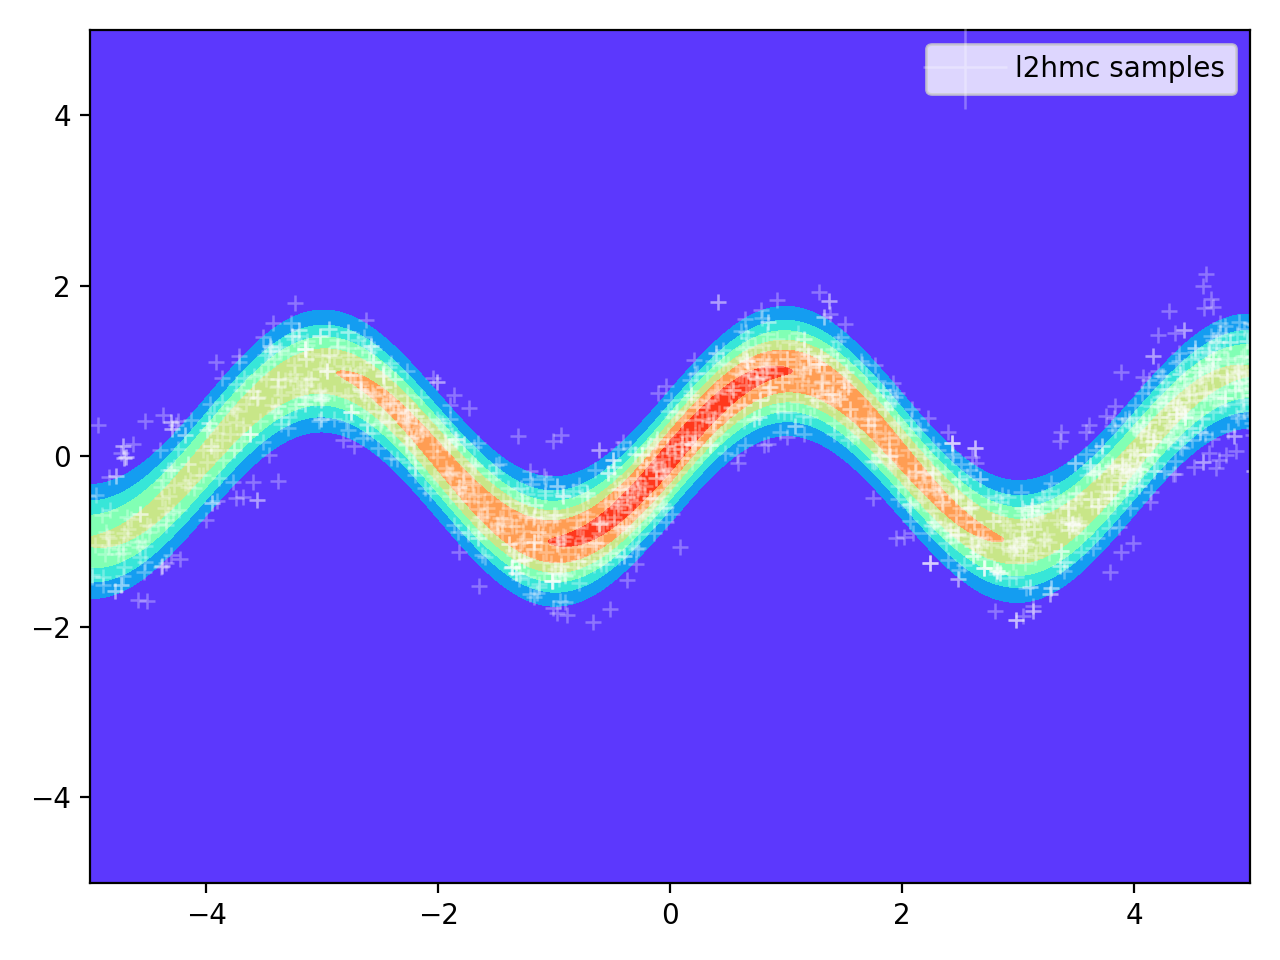

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain0.png


<IPython.core.display.Javascript object>


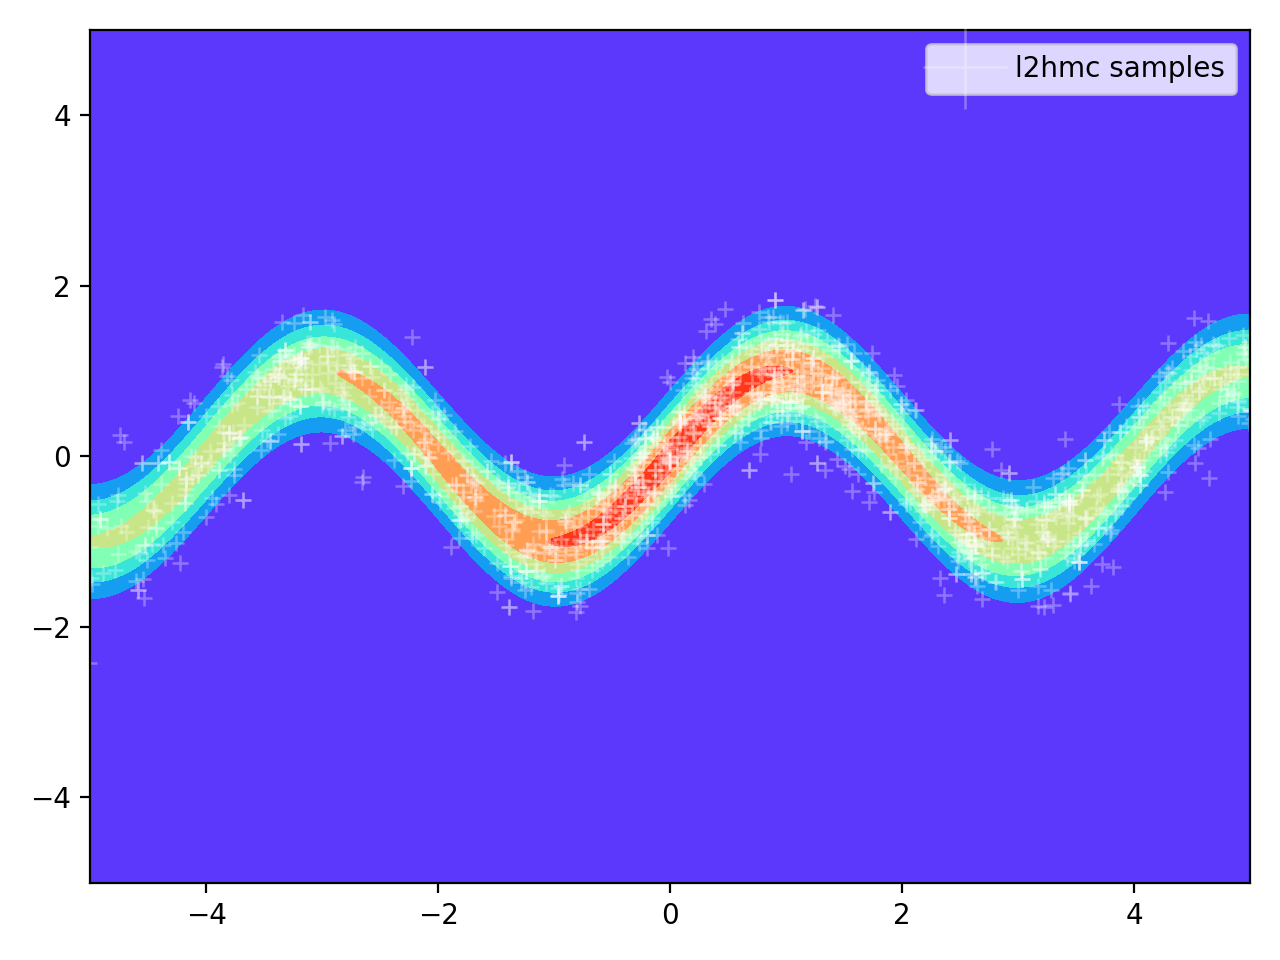

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain1.png


<IPython.core.display.Javascript object>


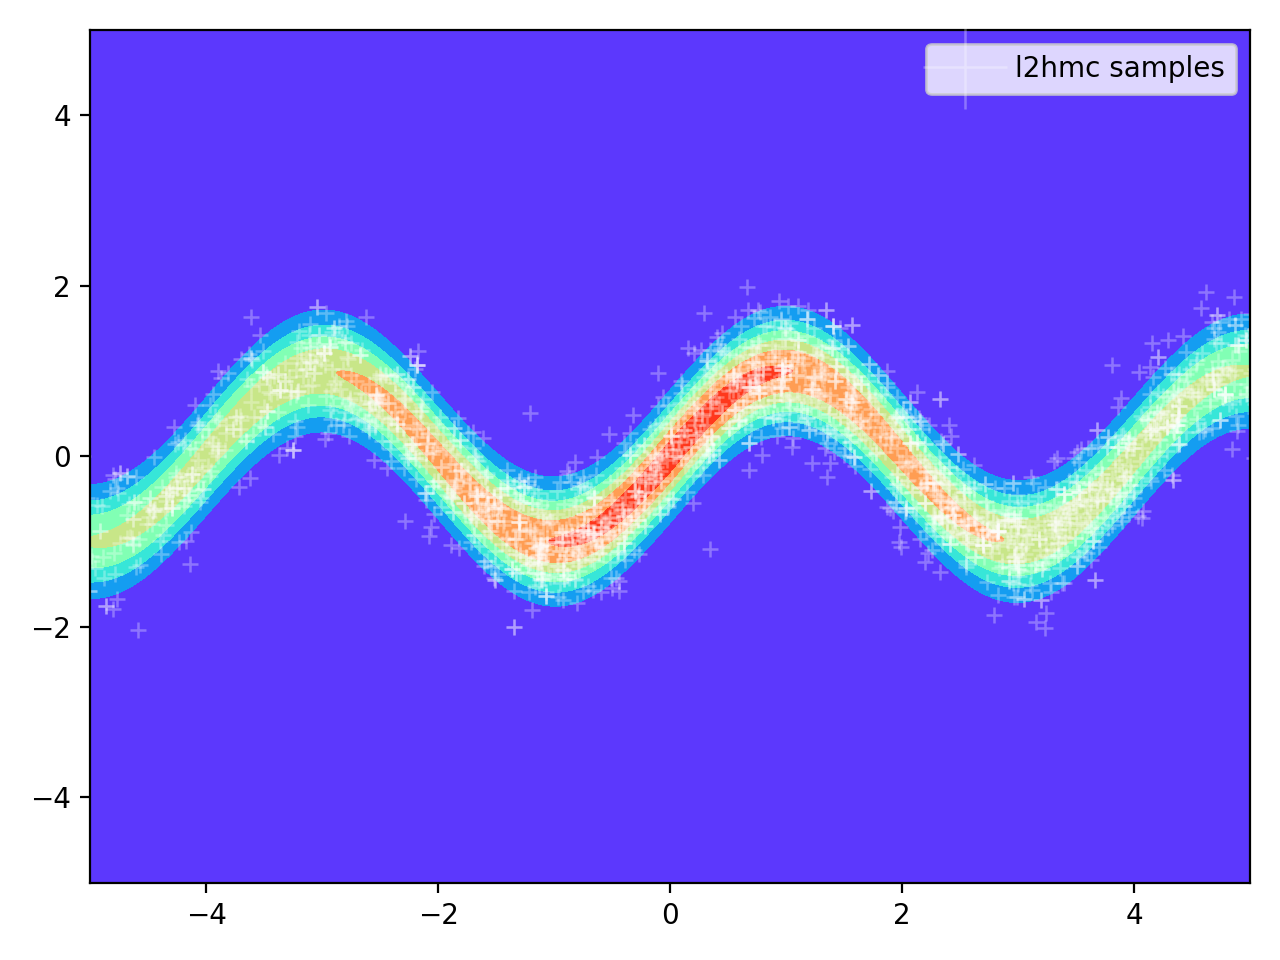

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain2.png


<IPython.core.display.Javascript object>


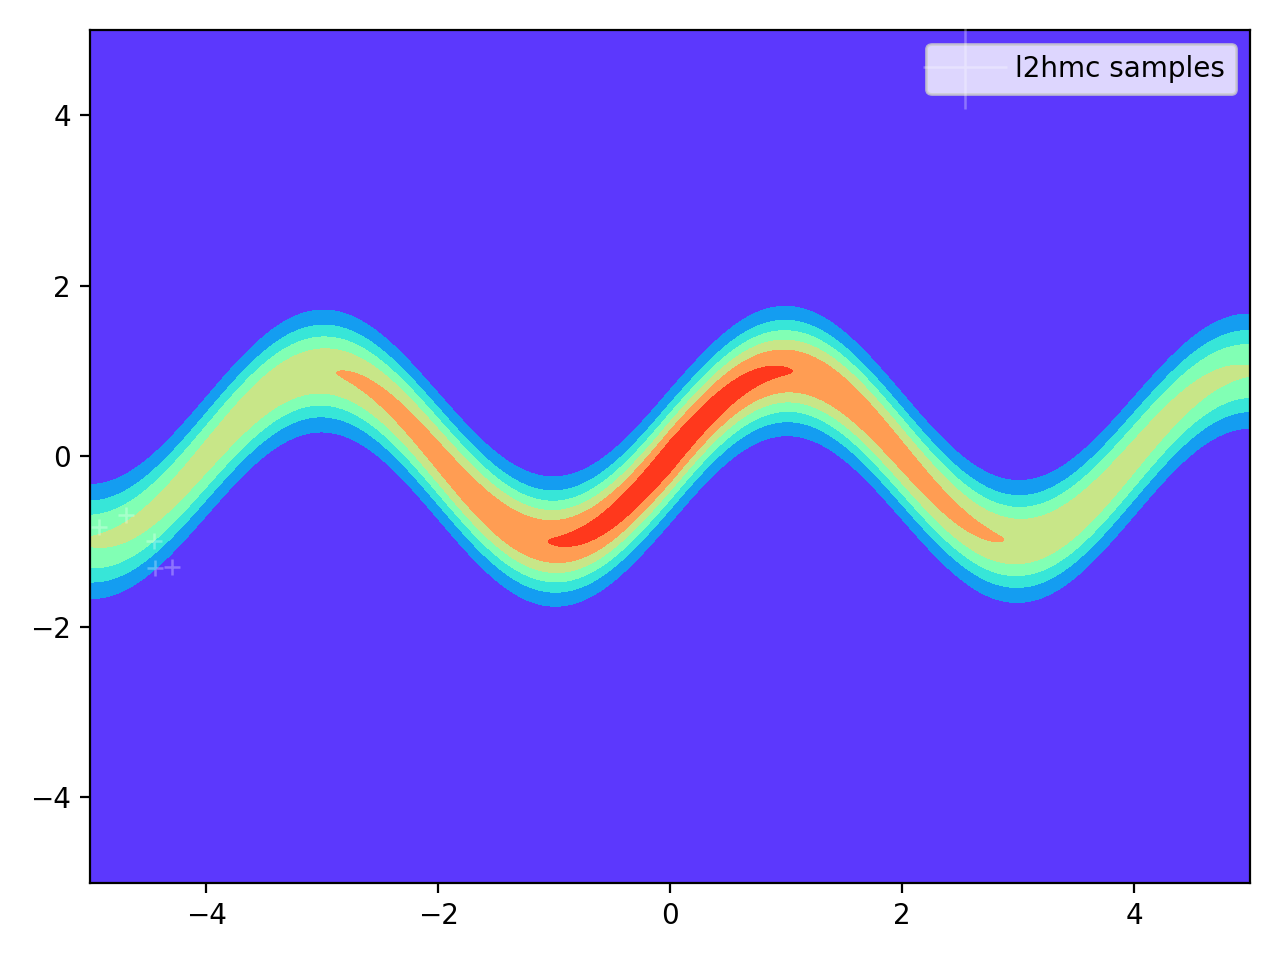

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain3.png


<IPython.core.display.Javascript object>


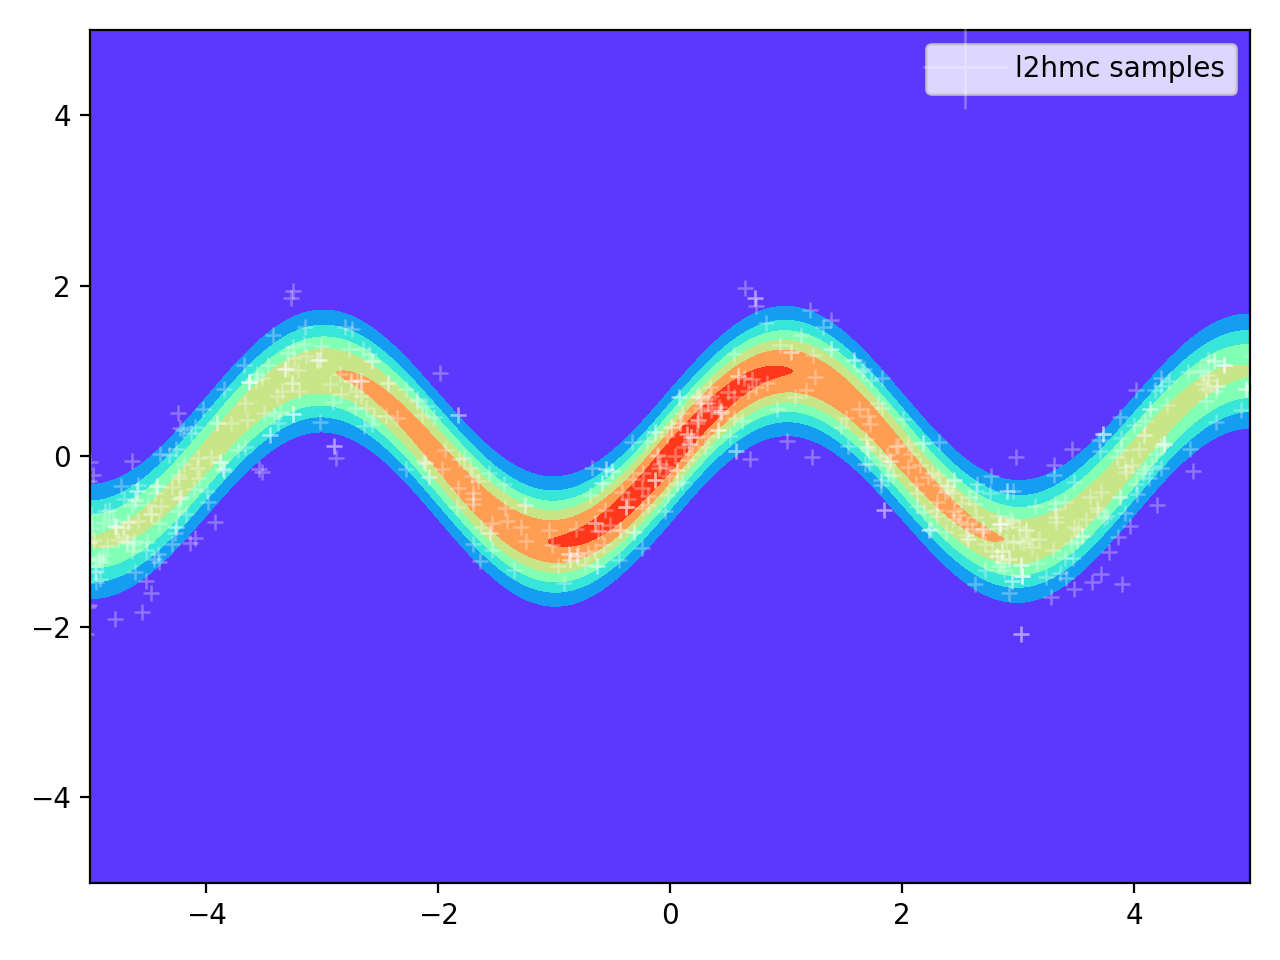

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain4.png


<IPython.core.display.Javascript object>


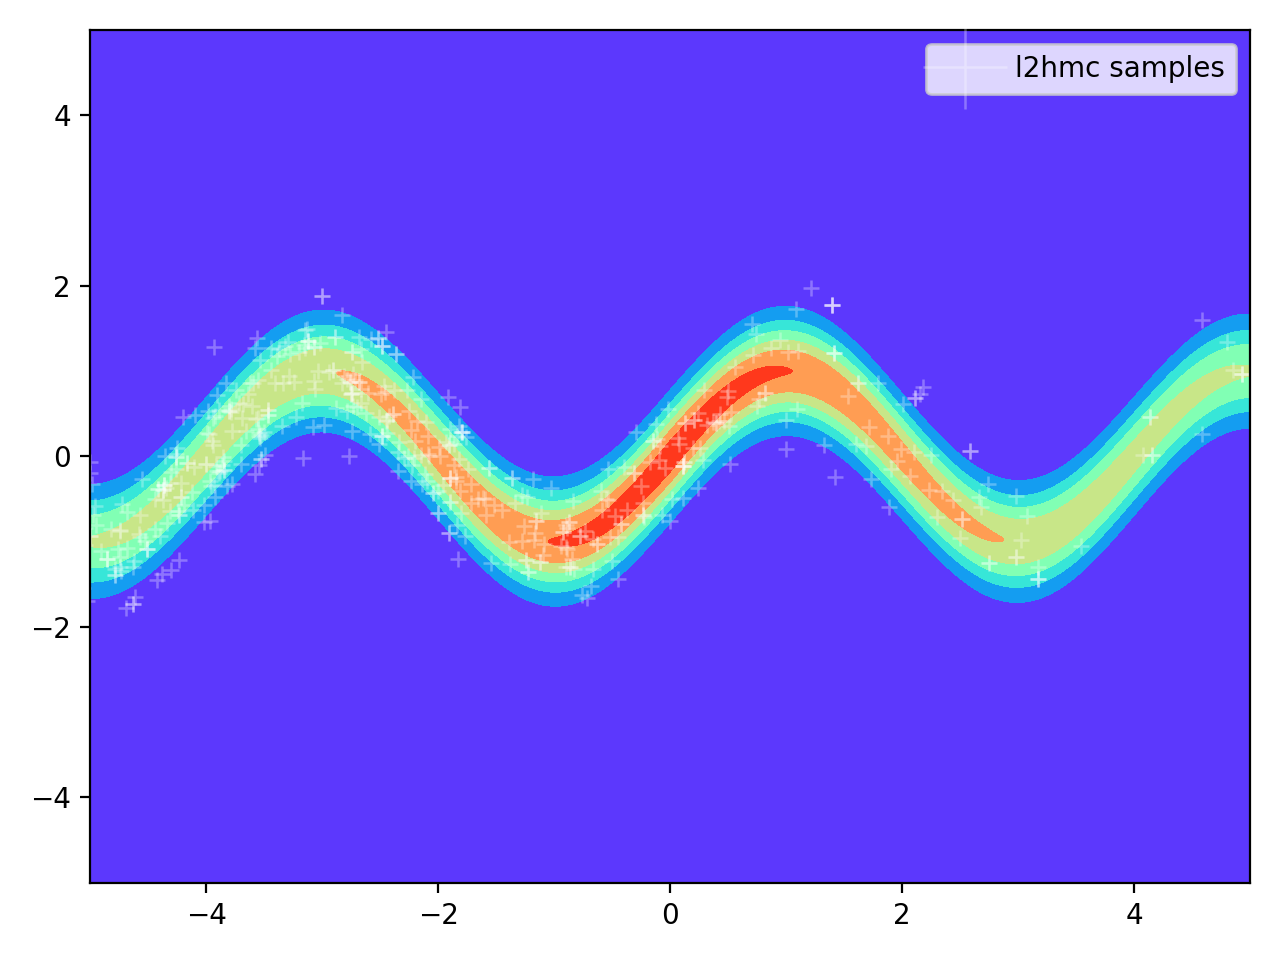

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain5.png


<IPython.core.display.Javascript object>


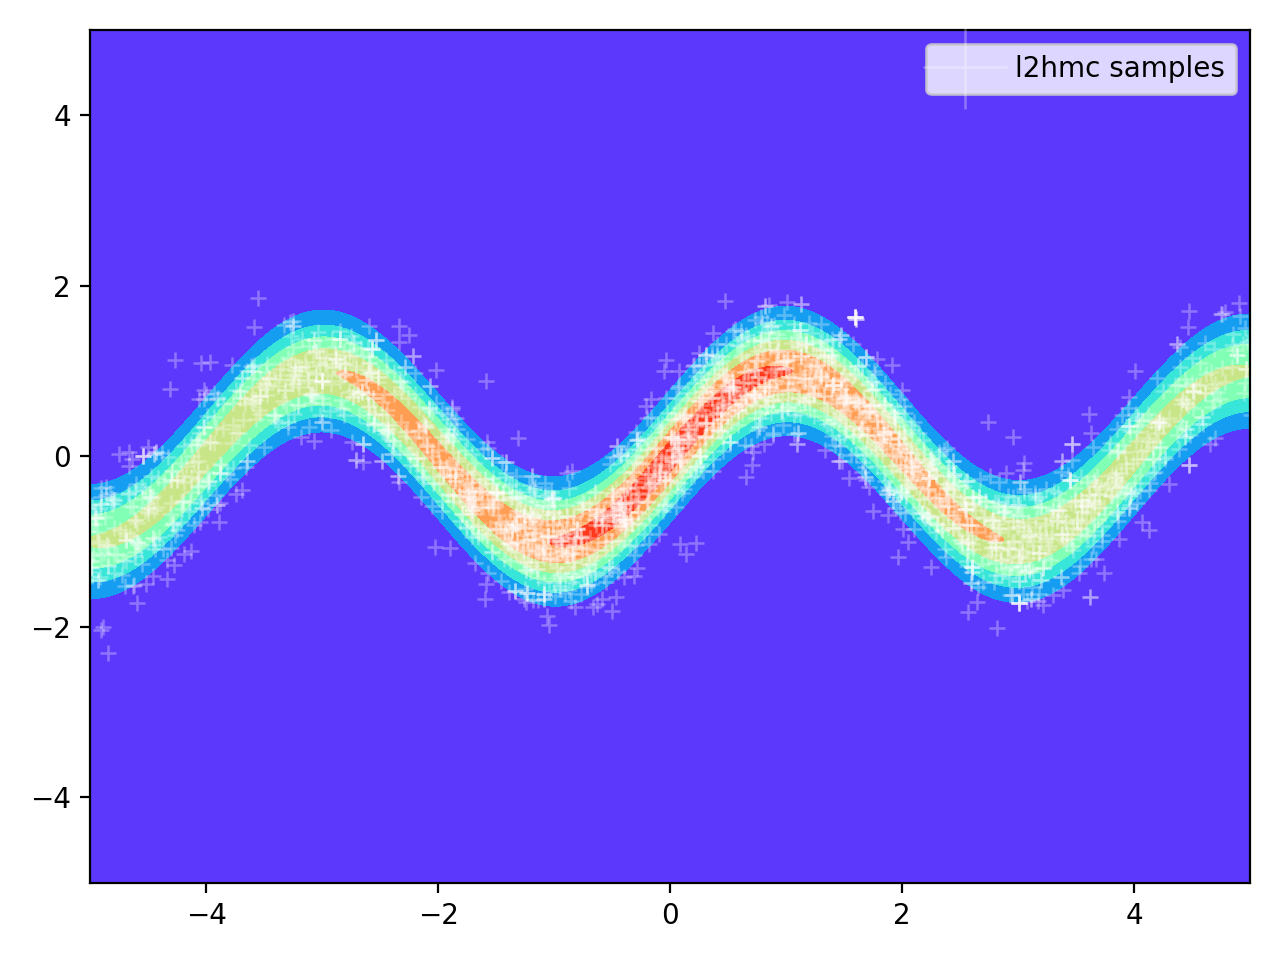

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain6.png


<IPython.core.display.Javascript object>


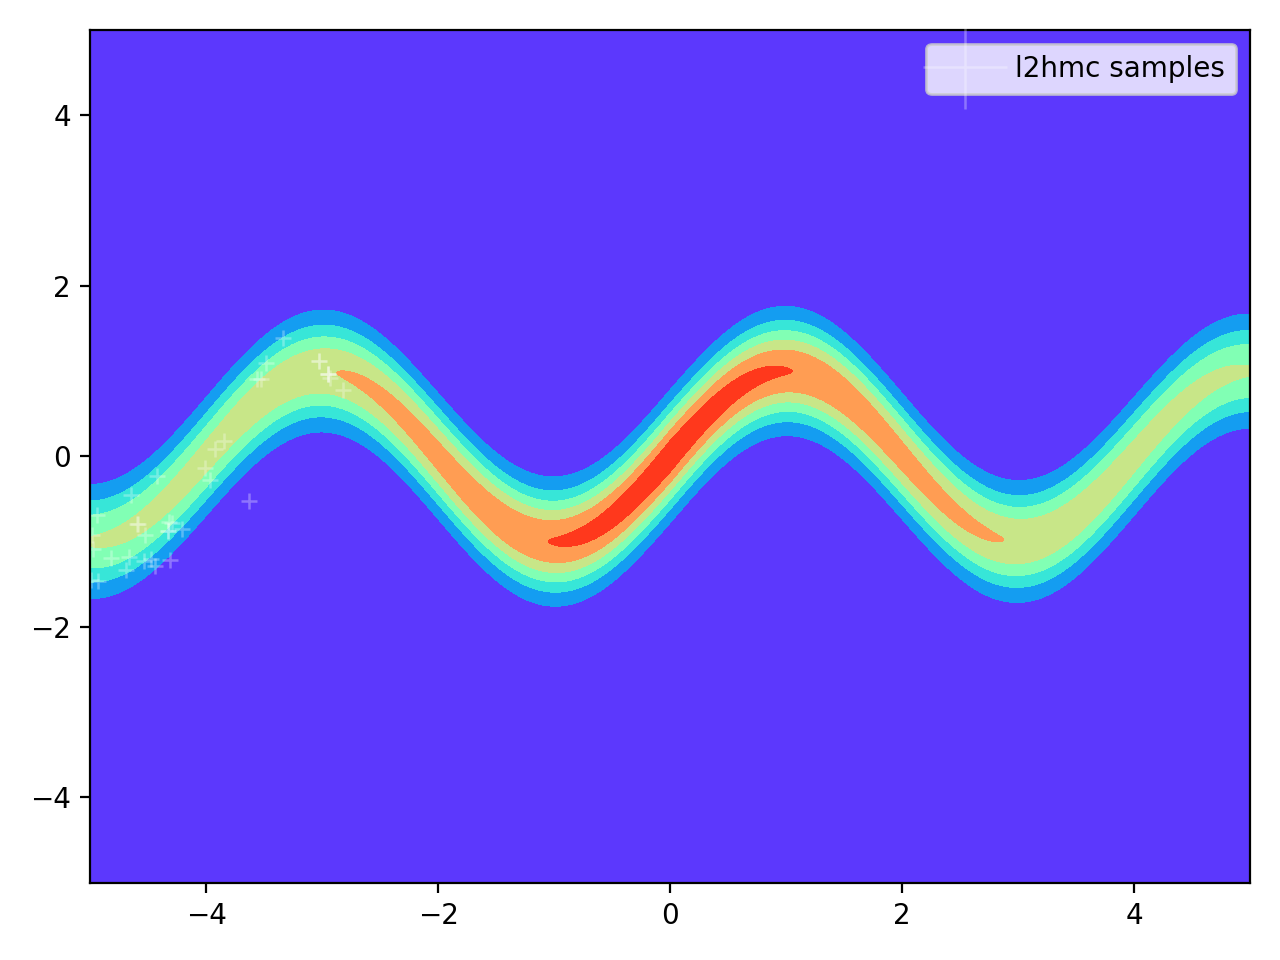

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain7.png


/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


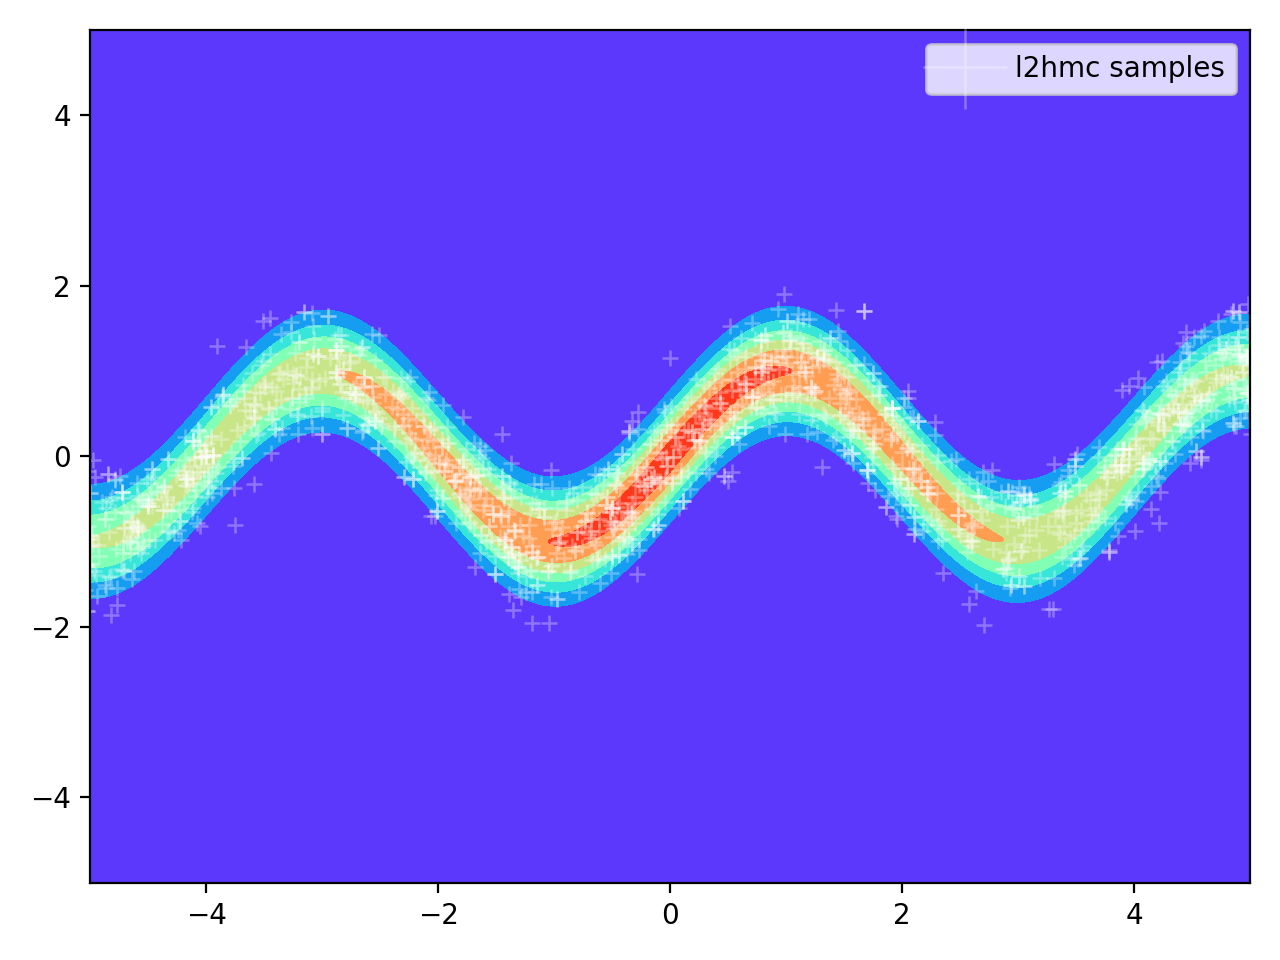

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain8.png


/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


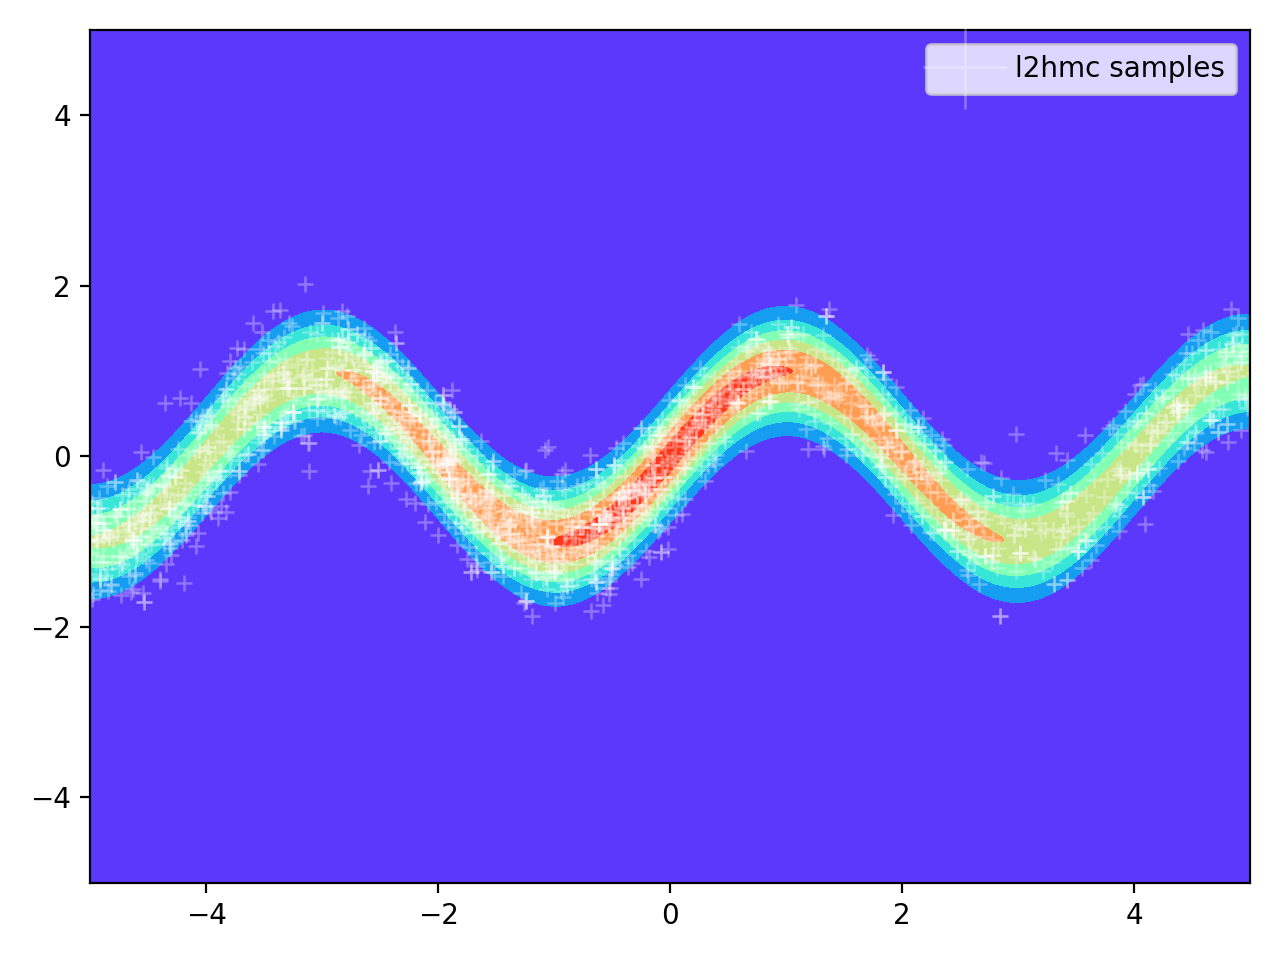

Saving figure to: /Users/saforem2/l2hmc-qcd/sin_potential/2020-08-12/2020-08-12-103408/figures/trained_samples_chain9.png


In [79]:
import utils.file_io as io
from utils.distributions import contour_potential

figs_dir = os.path.join(dirs.log_dir, 'figures')
io.check_else_make_dir(figs_dir)

x_arr = tf.convert_to_tensor(x_arr).numpy()

for chain in range(10):
    fig, ax = plt.subplots()
    xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
    #sns.kdeplot(*xy, ax=ax)
    #grid = xy.reshape(2, -1).T
    #Z = np.exp(-POTENTIAL_FN(grid))
    #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
    #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
    #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
    xlim = 5
    ylim = 5
    _ = contour_potential(POTENTIAL_FN, ax=ax, cmap='rainbow', xlim=xlim, ylim=ylim)
    _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                color='white', label='l2hmc samples')
    _ = ax.legend(markerscale=5., loc='best')
    _ = ax.set_xlim((-xlim, xlim))
    _ = ax.set_ylim((-ylim, ylim))
    out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
    print(f'Saving figure to: {out_file}')
    _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()